# Frequent Items Analysis - Visualization Report

Data stream frequency analysis using exact, approximate, and Space-Saving algorithms on Disney+ titles dataset (release_year attribute).

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.titlesize'] = 13

In [2]:
df = pd.read_csv('data/disney_plus_titles.csv')
approx_stats = pd.read_csv('results/approximate_counter_stats.csv')
approx_top10 = pd.read_csv('results/approximate_counter_top10.csv')
ss_performance = pd.read_csv('results/space_saving_performance.csv')
ss_top10 = pd.read_csv('results/space_saving_top10.csv')
order_preservation = pd.read_csv('results/order_preservation.csv')
memory_growth = pd.read_csv('results/memory_growth.csv')
prob_tradeoff = pd.read_csv('results/probability_tradeoff.csv')
exec_times = pd.read_csv('results/execution_times.csv')
least_freq = pd.read_csv('results/least_frequent_analysis.csv')

## 1. Release Year Distribution

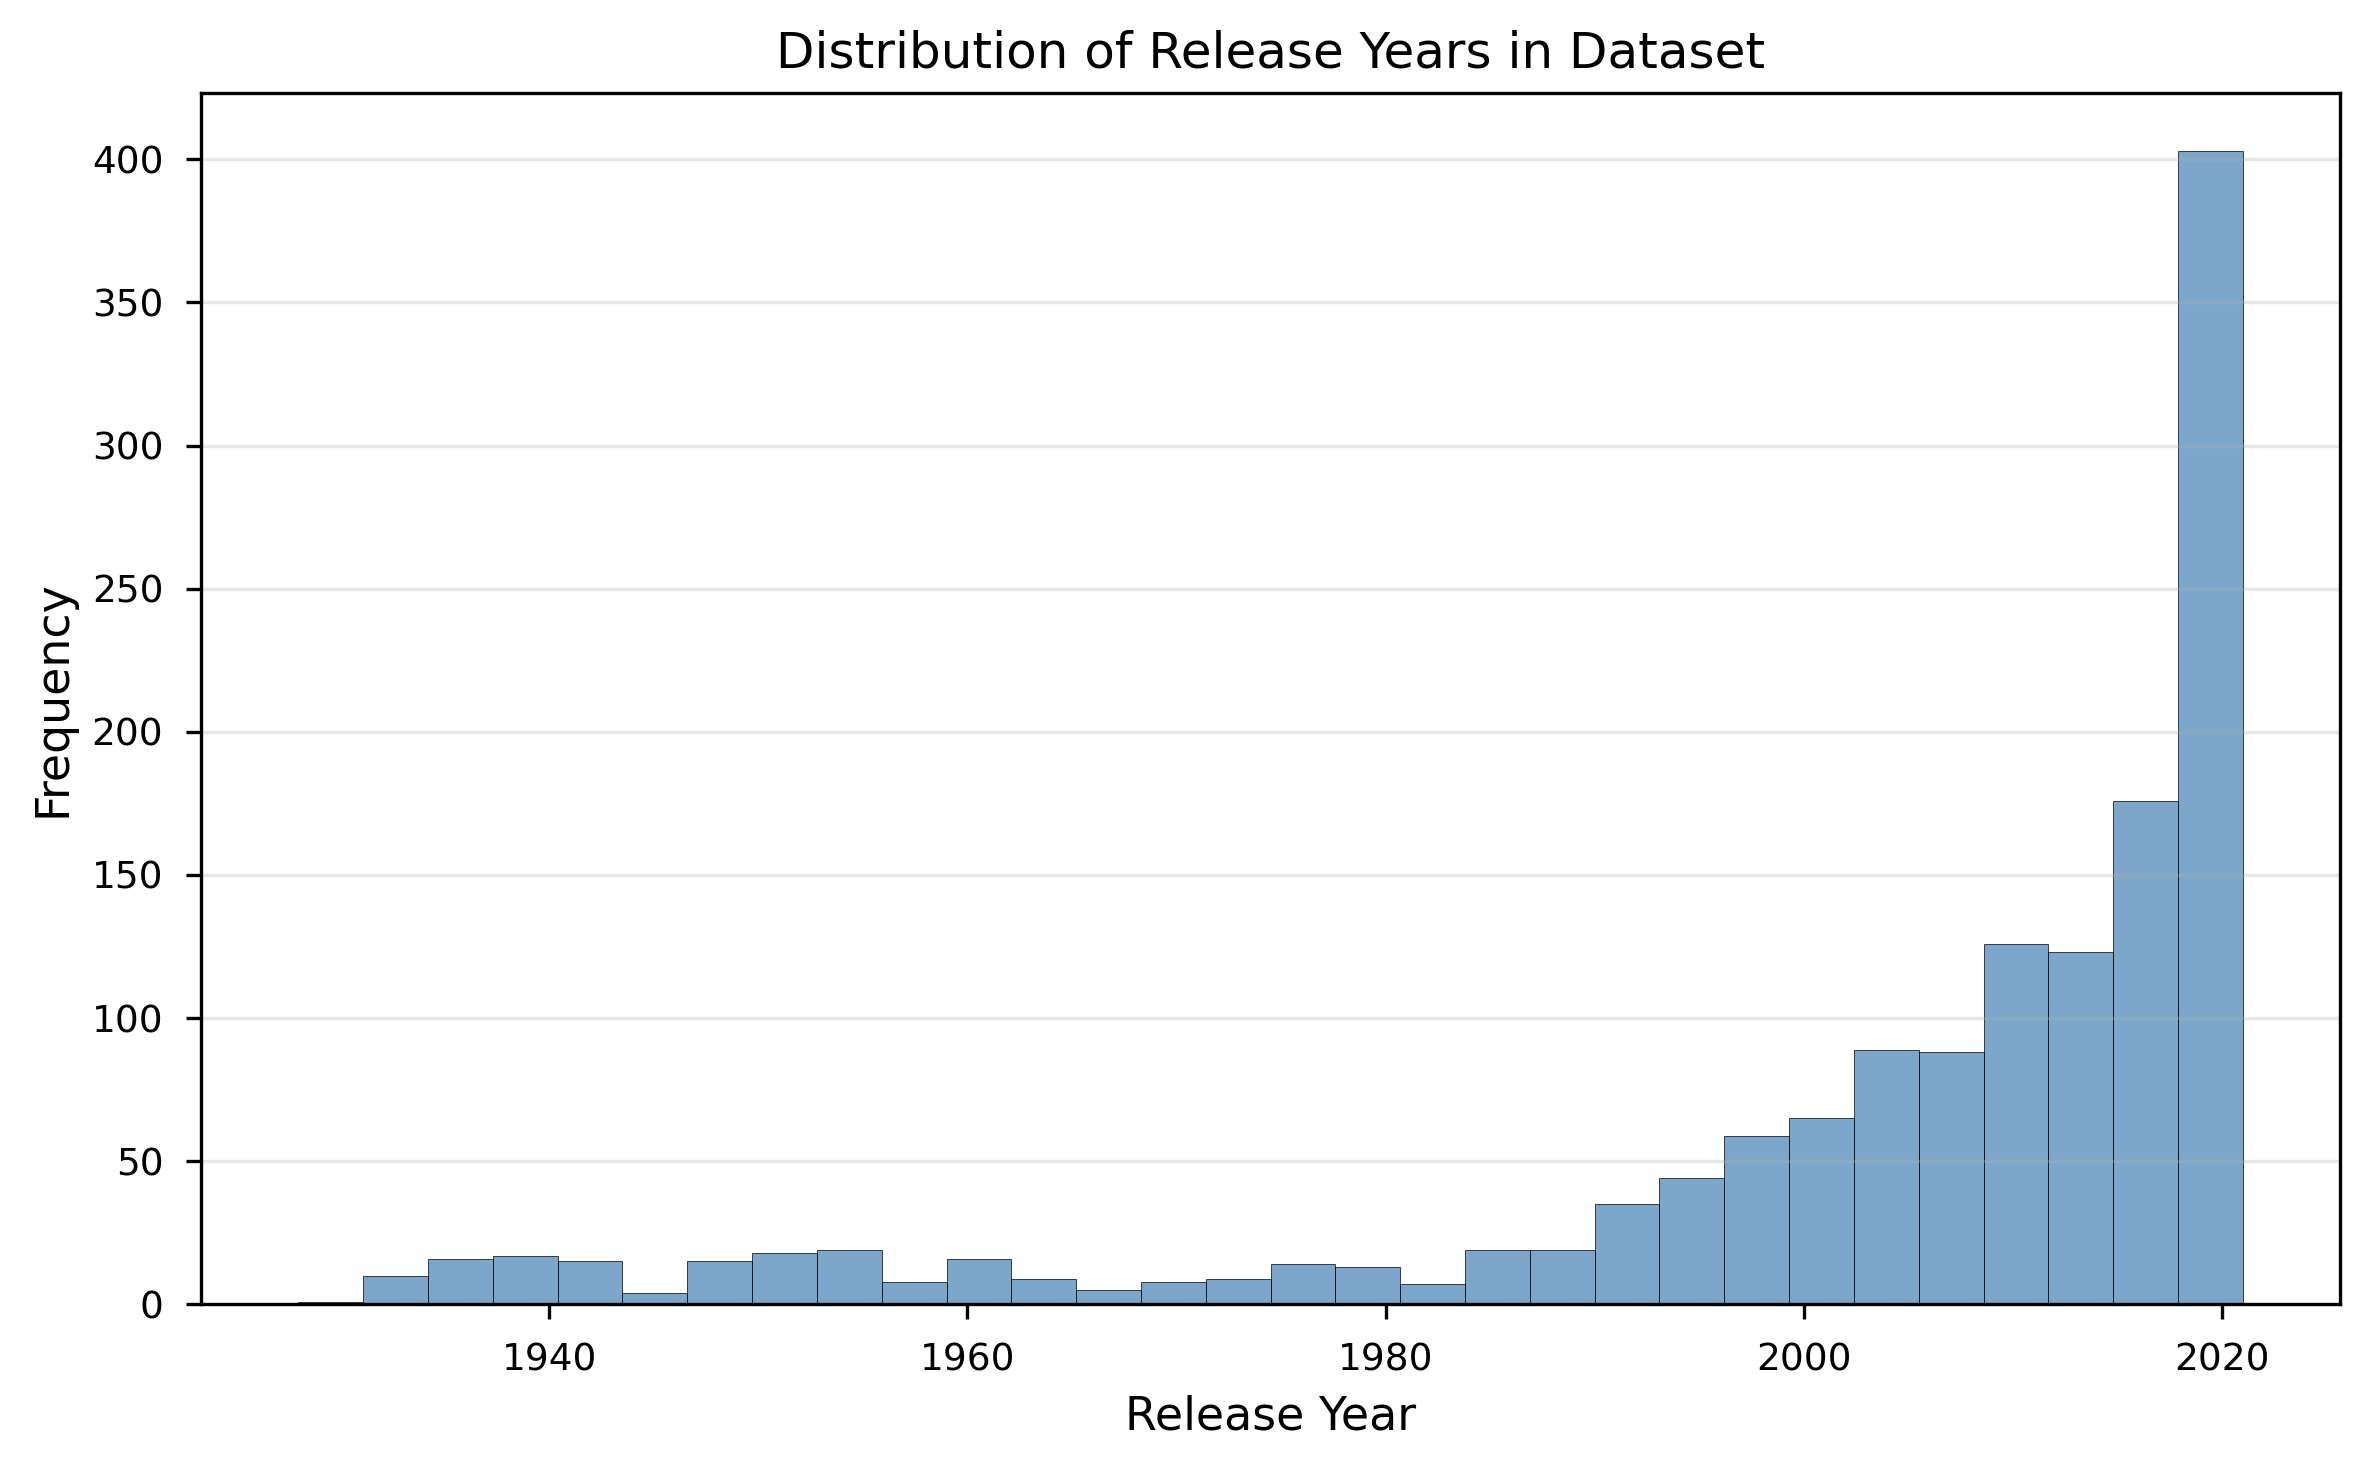

In [3]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(df['release_year'], bins=30, edgecolor='black', color='steelblue', alpha=0.7)
ax.set_xlabel('Release Year')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Release Years in Dataset')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

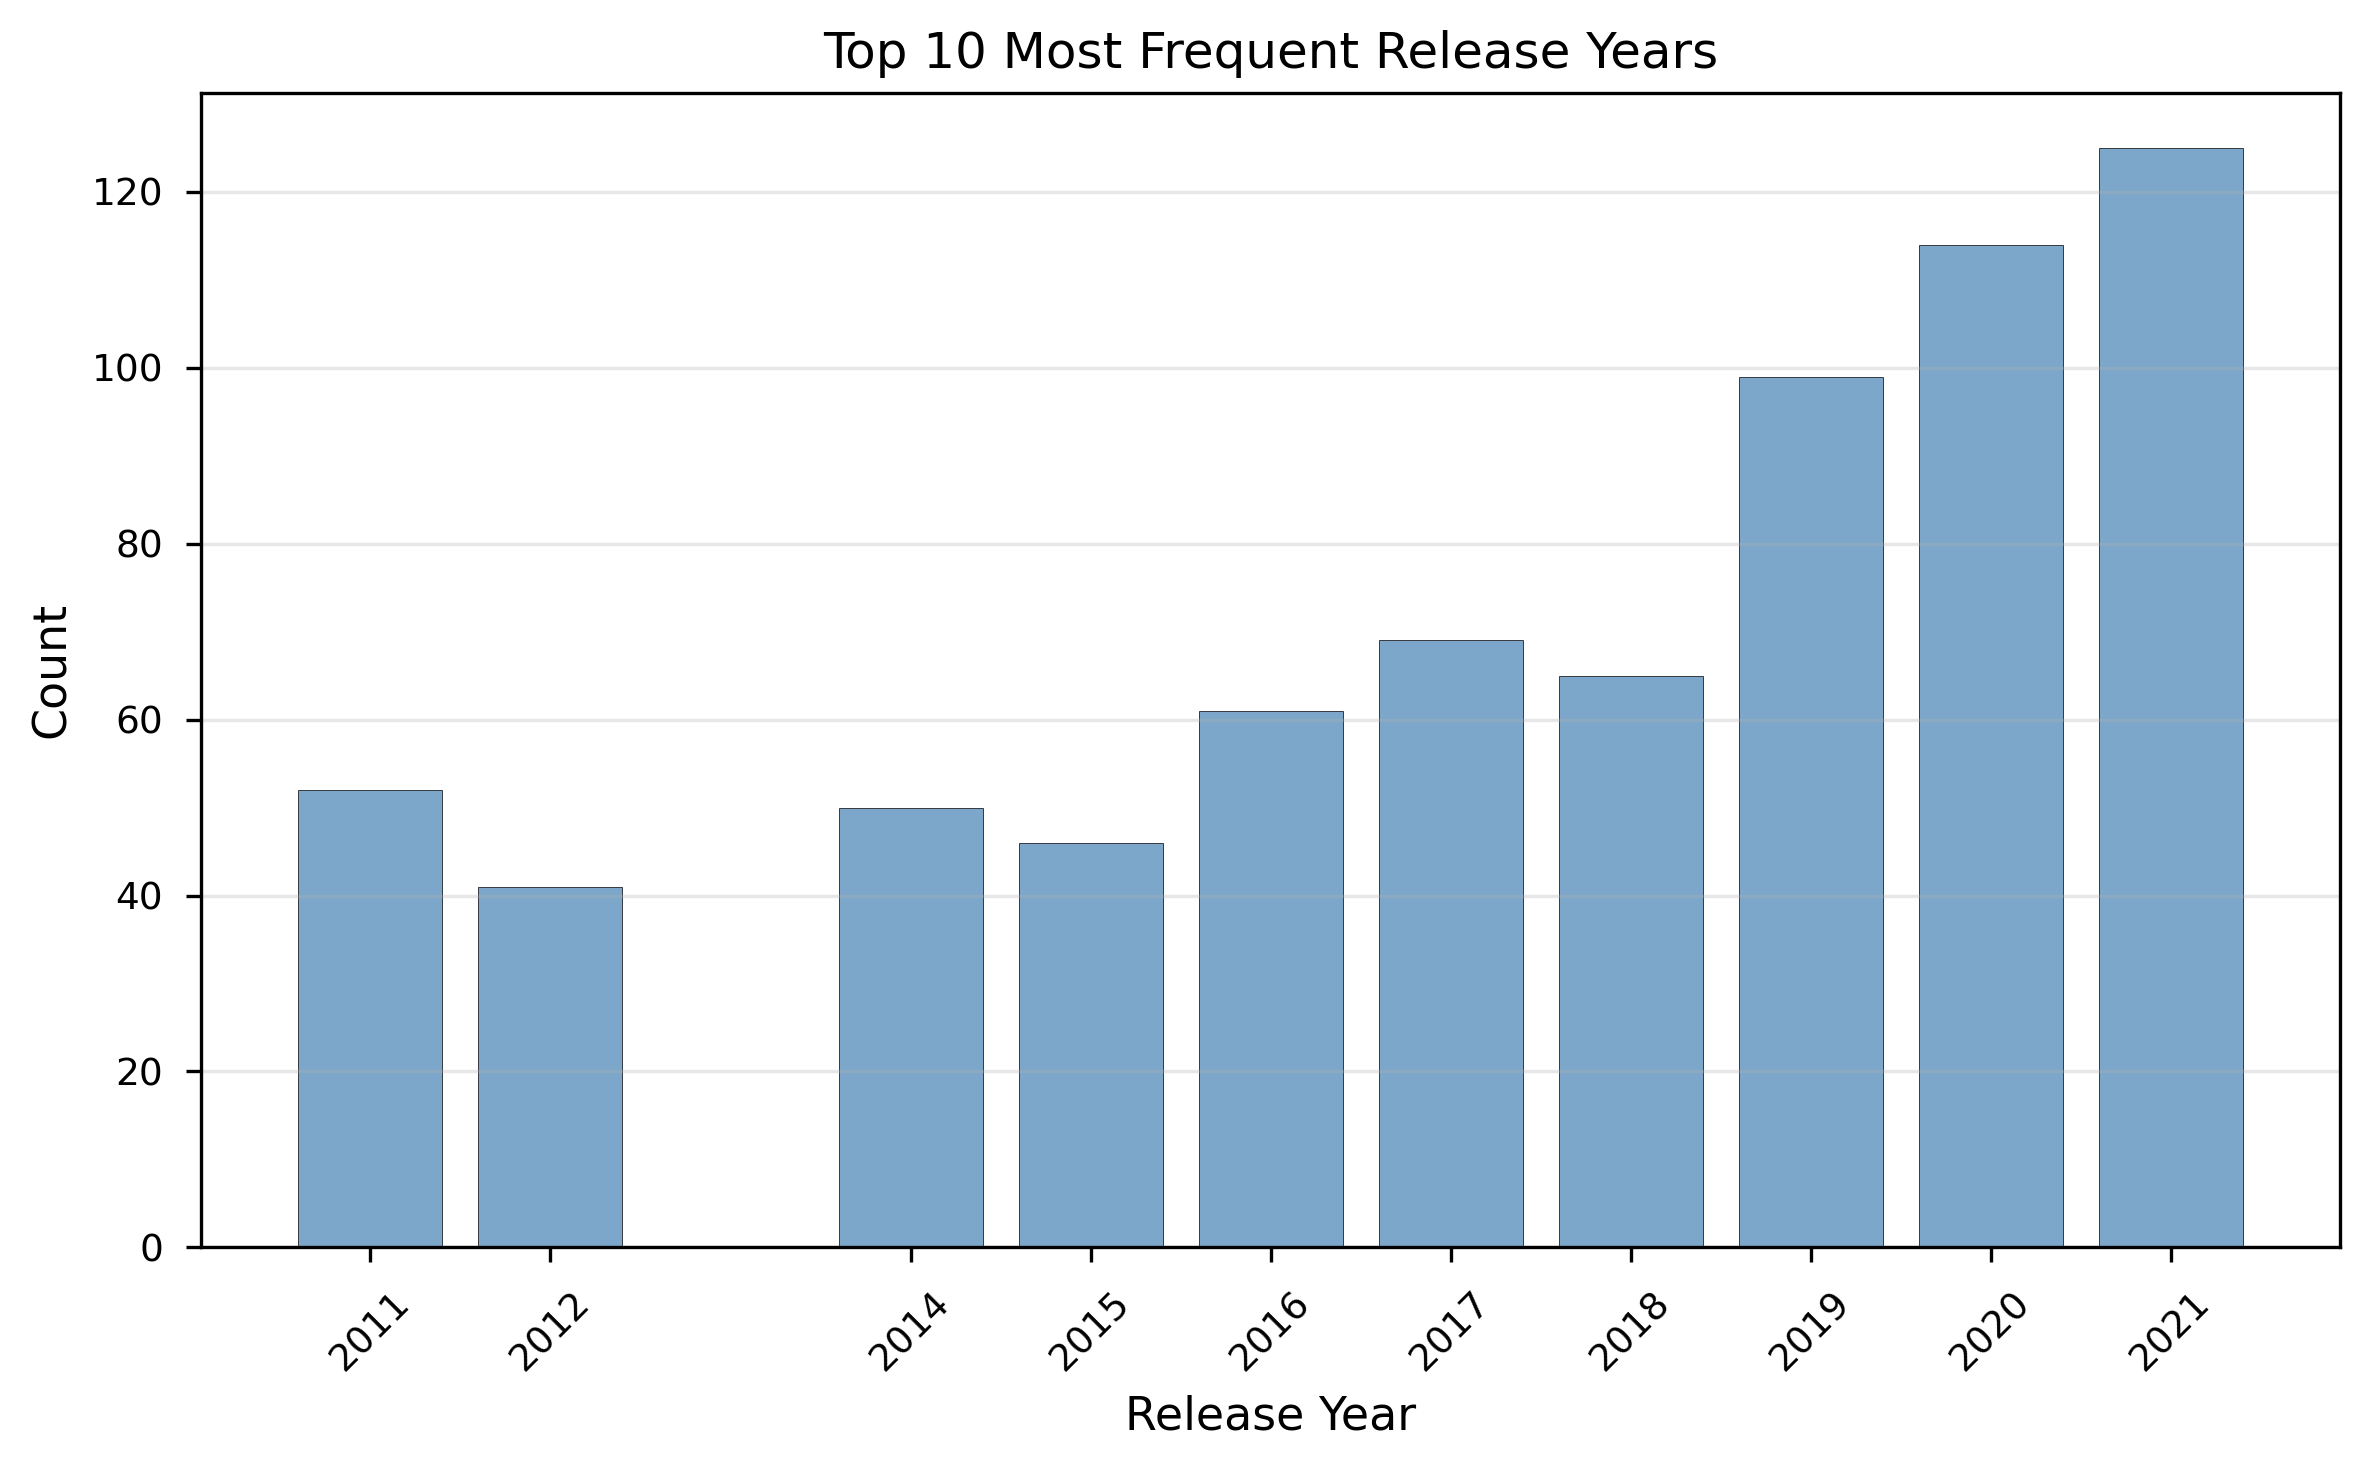

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))

year_counts = Counter(df['release_year'])
top_10_years = sorted(year_counts.items(), key=lambda x: x[1], reverse=True)[:10]
years, counts = zip(*top_10_years)

ax.bar(years, counts, edgecolor='black', color='steelblue', alpha=0.7)
ax.set_xlabel('Release Year')
ax.set_ylabel('Count')
ax.set_title('Top 10 Most Frequent Release Years')
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 1.5. Memory Growth: Exact Counting O(|U|) Complexity

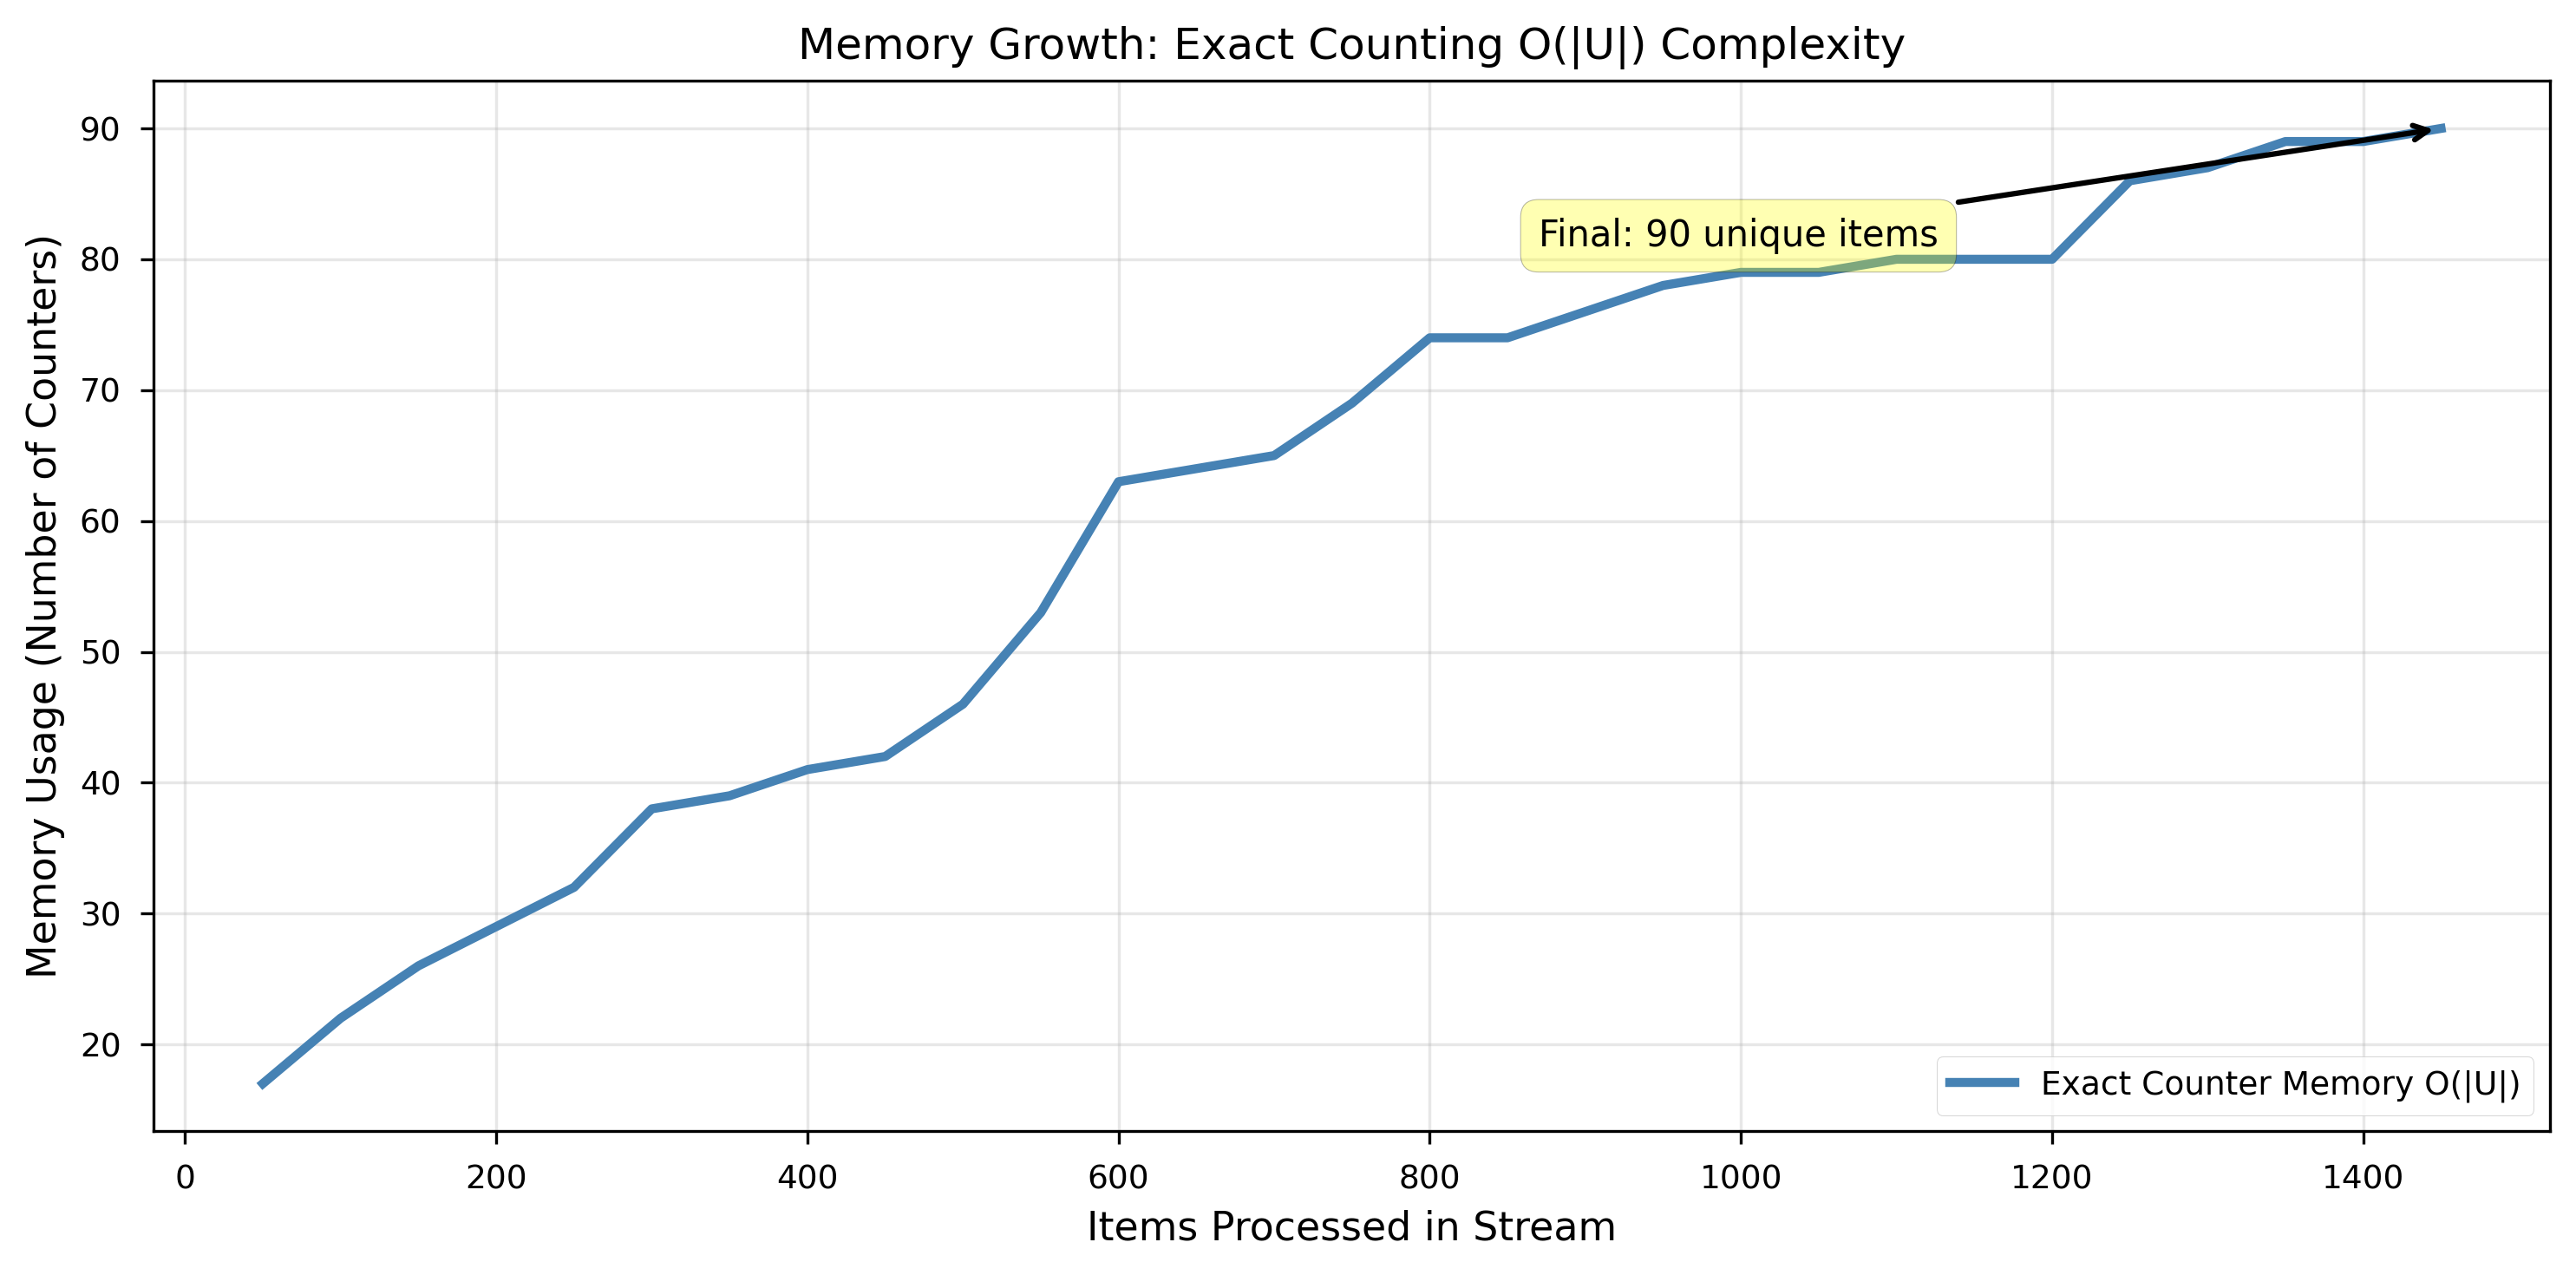

In [5]:
stream = df['release_year'].tolist()
unique_items_over_time = []
items_processed = []
seen = set()

for i, item in enumerate(stream, 1):
    seen.add(item)
    if i % 50 == 0 or i == len(stream):
        items_processed.append(i)
        unique_items_over_time.append(len(seen))

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(items_processed, unique_items_over_time, 
        linewidth=2.5, color='steelblue', label='Exact Counter Memory O(|U|)')

ax.set_xlabel('Items Processed in Stream')
ax.set_ylabel('Memory Usage (Number of Counters)')
ax.set_title('Memory Growth: Exact Counting O(|U|) Complexity')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

ax.annotate(f'Final: {len(seen)} unique items', 
            xy=(len(stream), len(seen)), 
            xytext=(len(stream)*0.6, len(seen)*0.9),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
            fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.show()


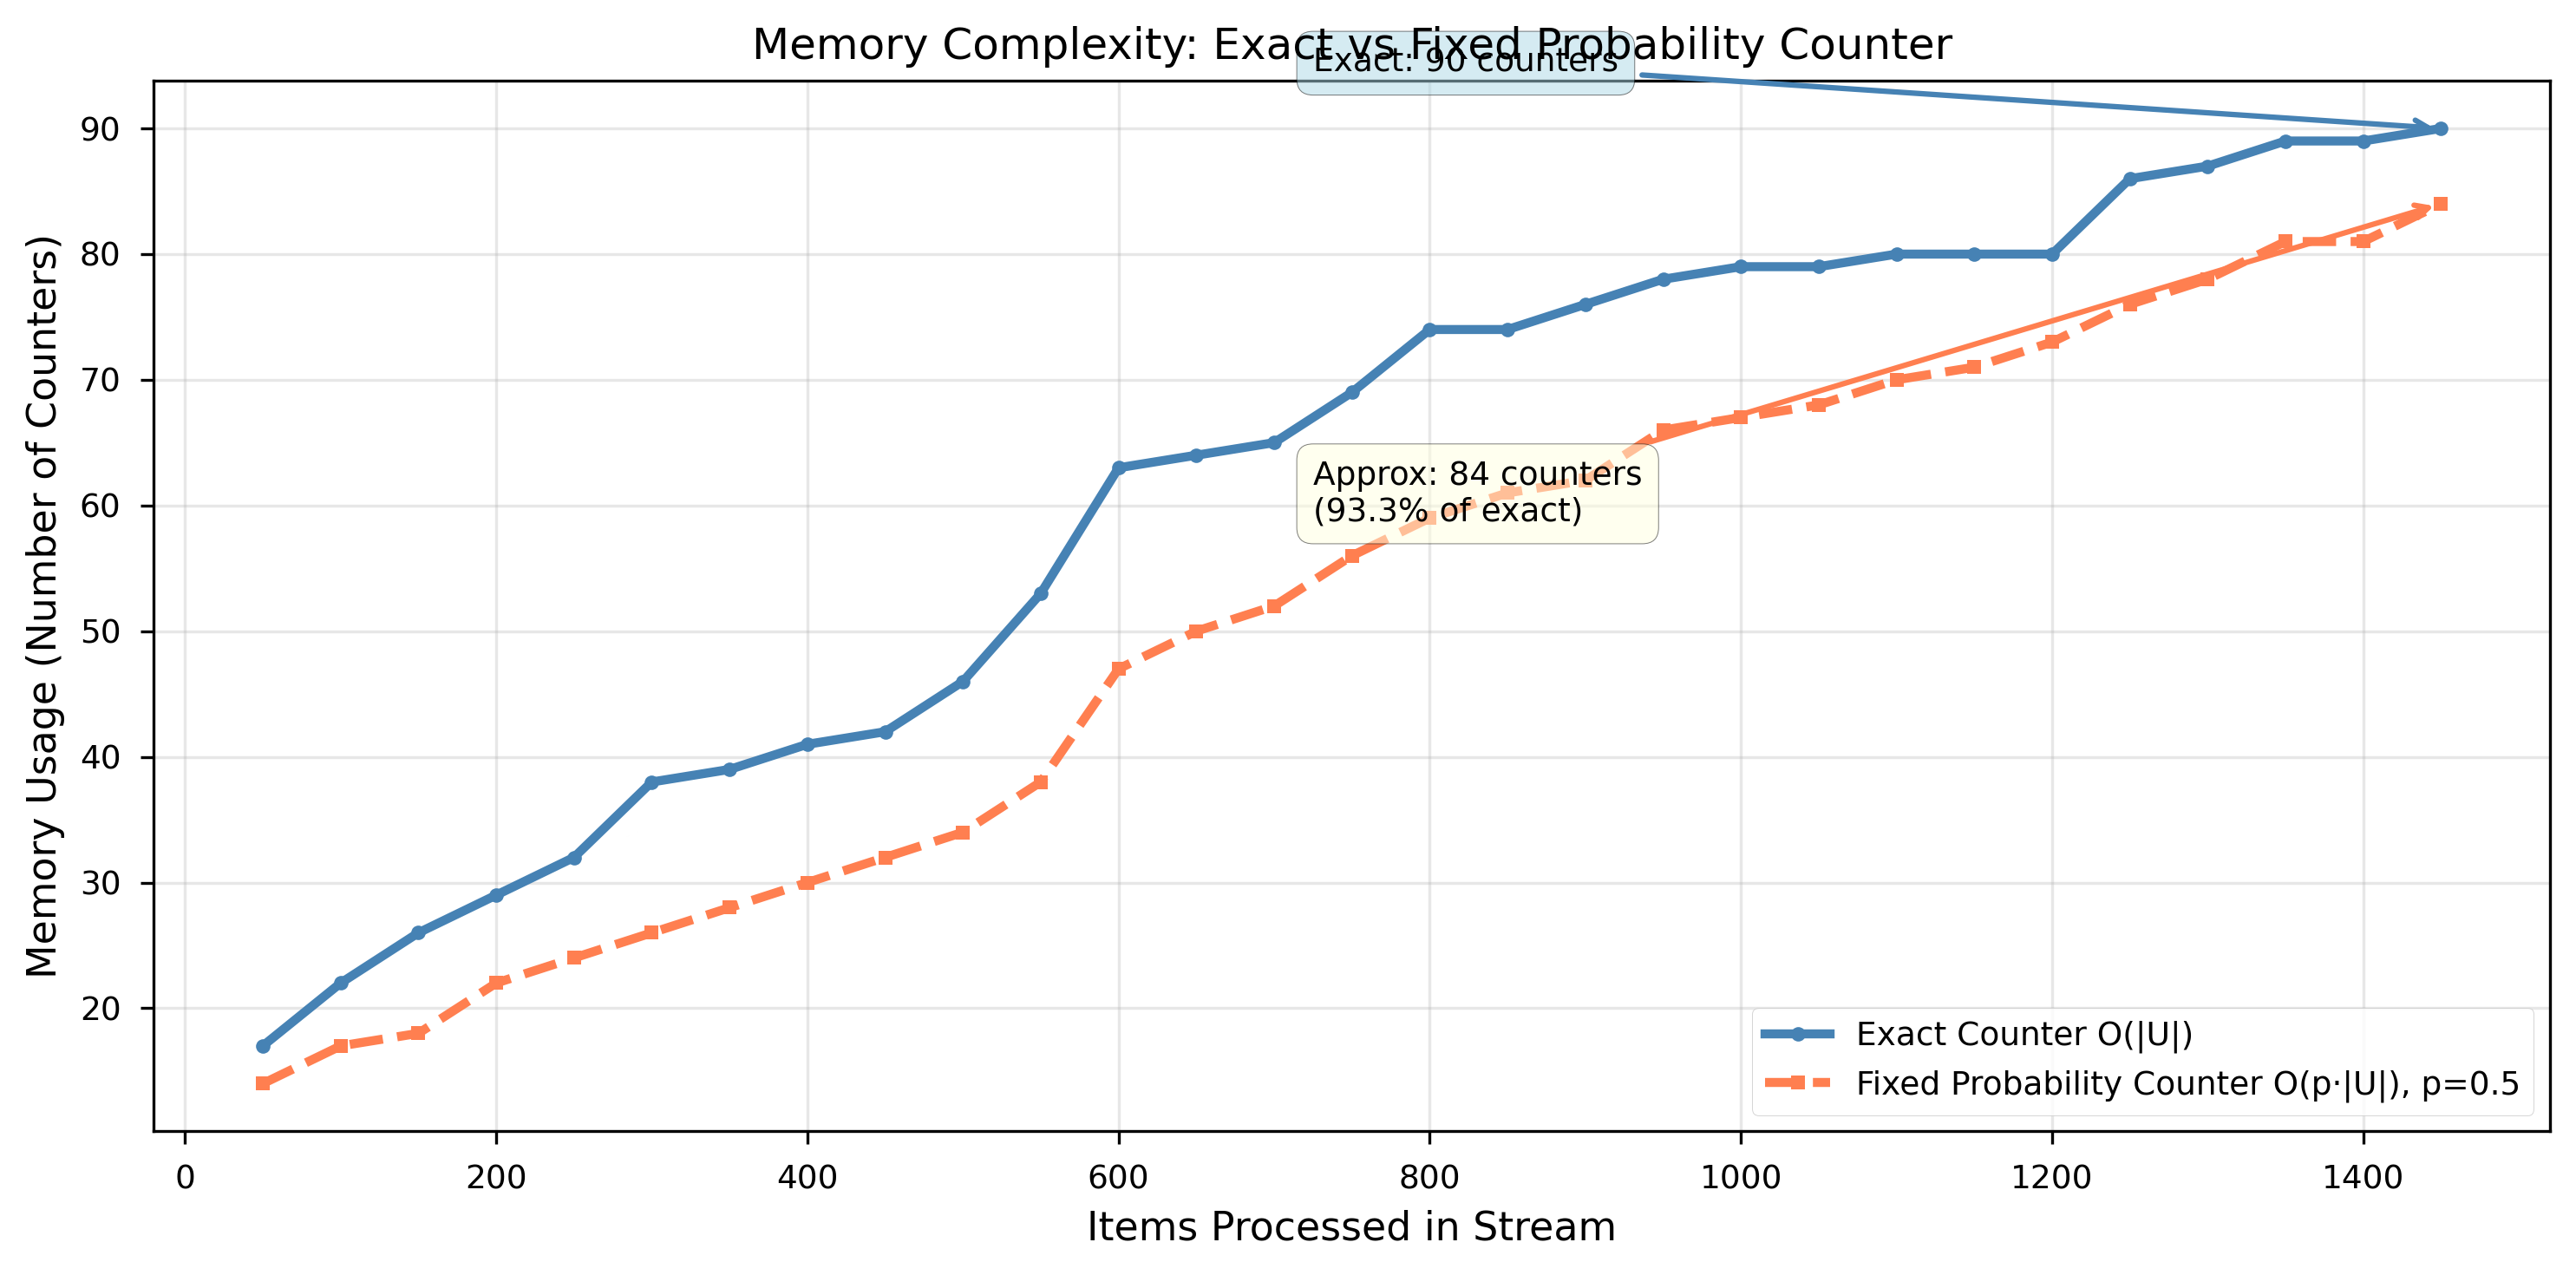

Memory Usage Comparison:
  Exact Counter: 90 counters (100% of |U|)
  Fixed Probability Counter (p=0.5): 84 counters (93.3% of |U|)
  Memory Reduction: 6.7%


In [6]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(memory_growth['items_processed'], memory_growth['exact_counters'], 
        linewidth=2.5, color='steelblue', label='Exact Counter O(|U|)', marker='o', markersize=4)

ax.plot(memory_growth['items_processed'], memory_growth['approx_counters'], 
        linewidth=2.5, color='coral', label='Fixed Probability Counter O(p·|U|), p=0.5', 
        marker='s', markersize=4, linestyle='--')

ax.set_xlabel('Items Processed in Stream')
ax.set_ylabel('Memory Usage (Number of Counters)')
ax.set_title('Memory Complexity: Exact vs Fixed Probability Counter')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

# Get final values
final_exact = memory_growth['exact_counters'].iloc[-1]
final_approx = memory_growth['approx_counters'].iloc[-1]
final_items = memory_growth['items_processed'].iloc[-1]

# Annotations
ax.annotate(f'Exact: {final_exact} counters', 
            xy=(final_items, final_exact), 
            xytext=(final_items*0.5, final_exact*1.05),
            arrowprops=dict(arrowstyle='->', color='steelblue', lw=1.5),
            fontsize=9, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.5))

ax.annotate(f'Approx: {final_approx} counters\n({final_approx/final_exact*100:.1f}% of exact)', 
            xy=(final_items, final_approx), 
            xytext=(final_items*0.5, final_approx*0.7),
            arrowprops=dict(arrowstyle='->', color='coral', lw=1.5),
            fontsize=9, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"Memory Usage Comparison:")
print(f"  Exact Counter: {final_exact} counters (100% of |U|)")
print(f"  Fixed Probability Counter (p=0.5): {final_approx} counters ({final_approx/final_exact*100:.1f}% of |U|)")
print(f"  Memory Reduction: {(1 - final_approx/final_exact)*100:.1f}%")

## 1.6. Trade-off: Memory vs Stability (Sampling Probability p)

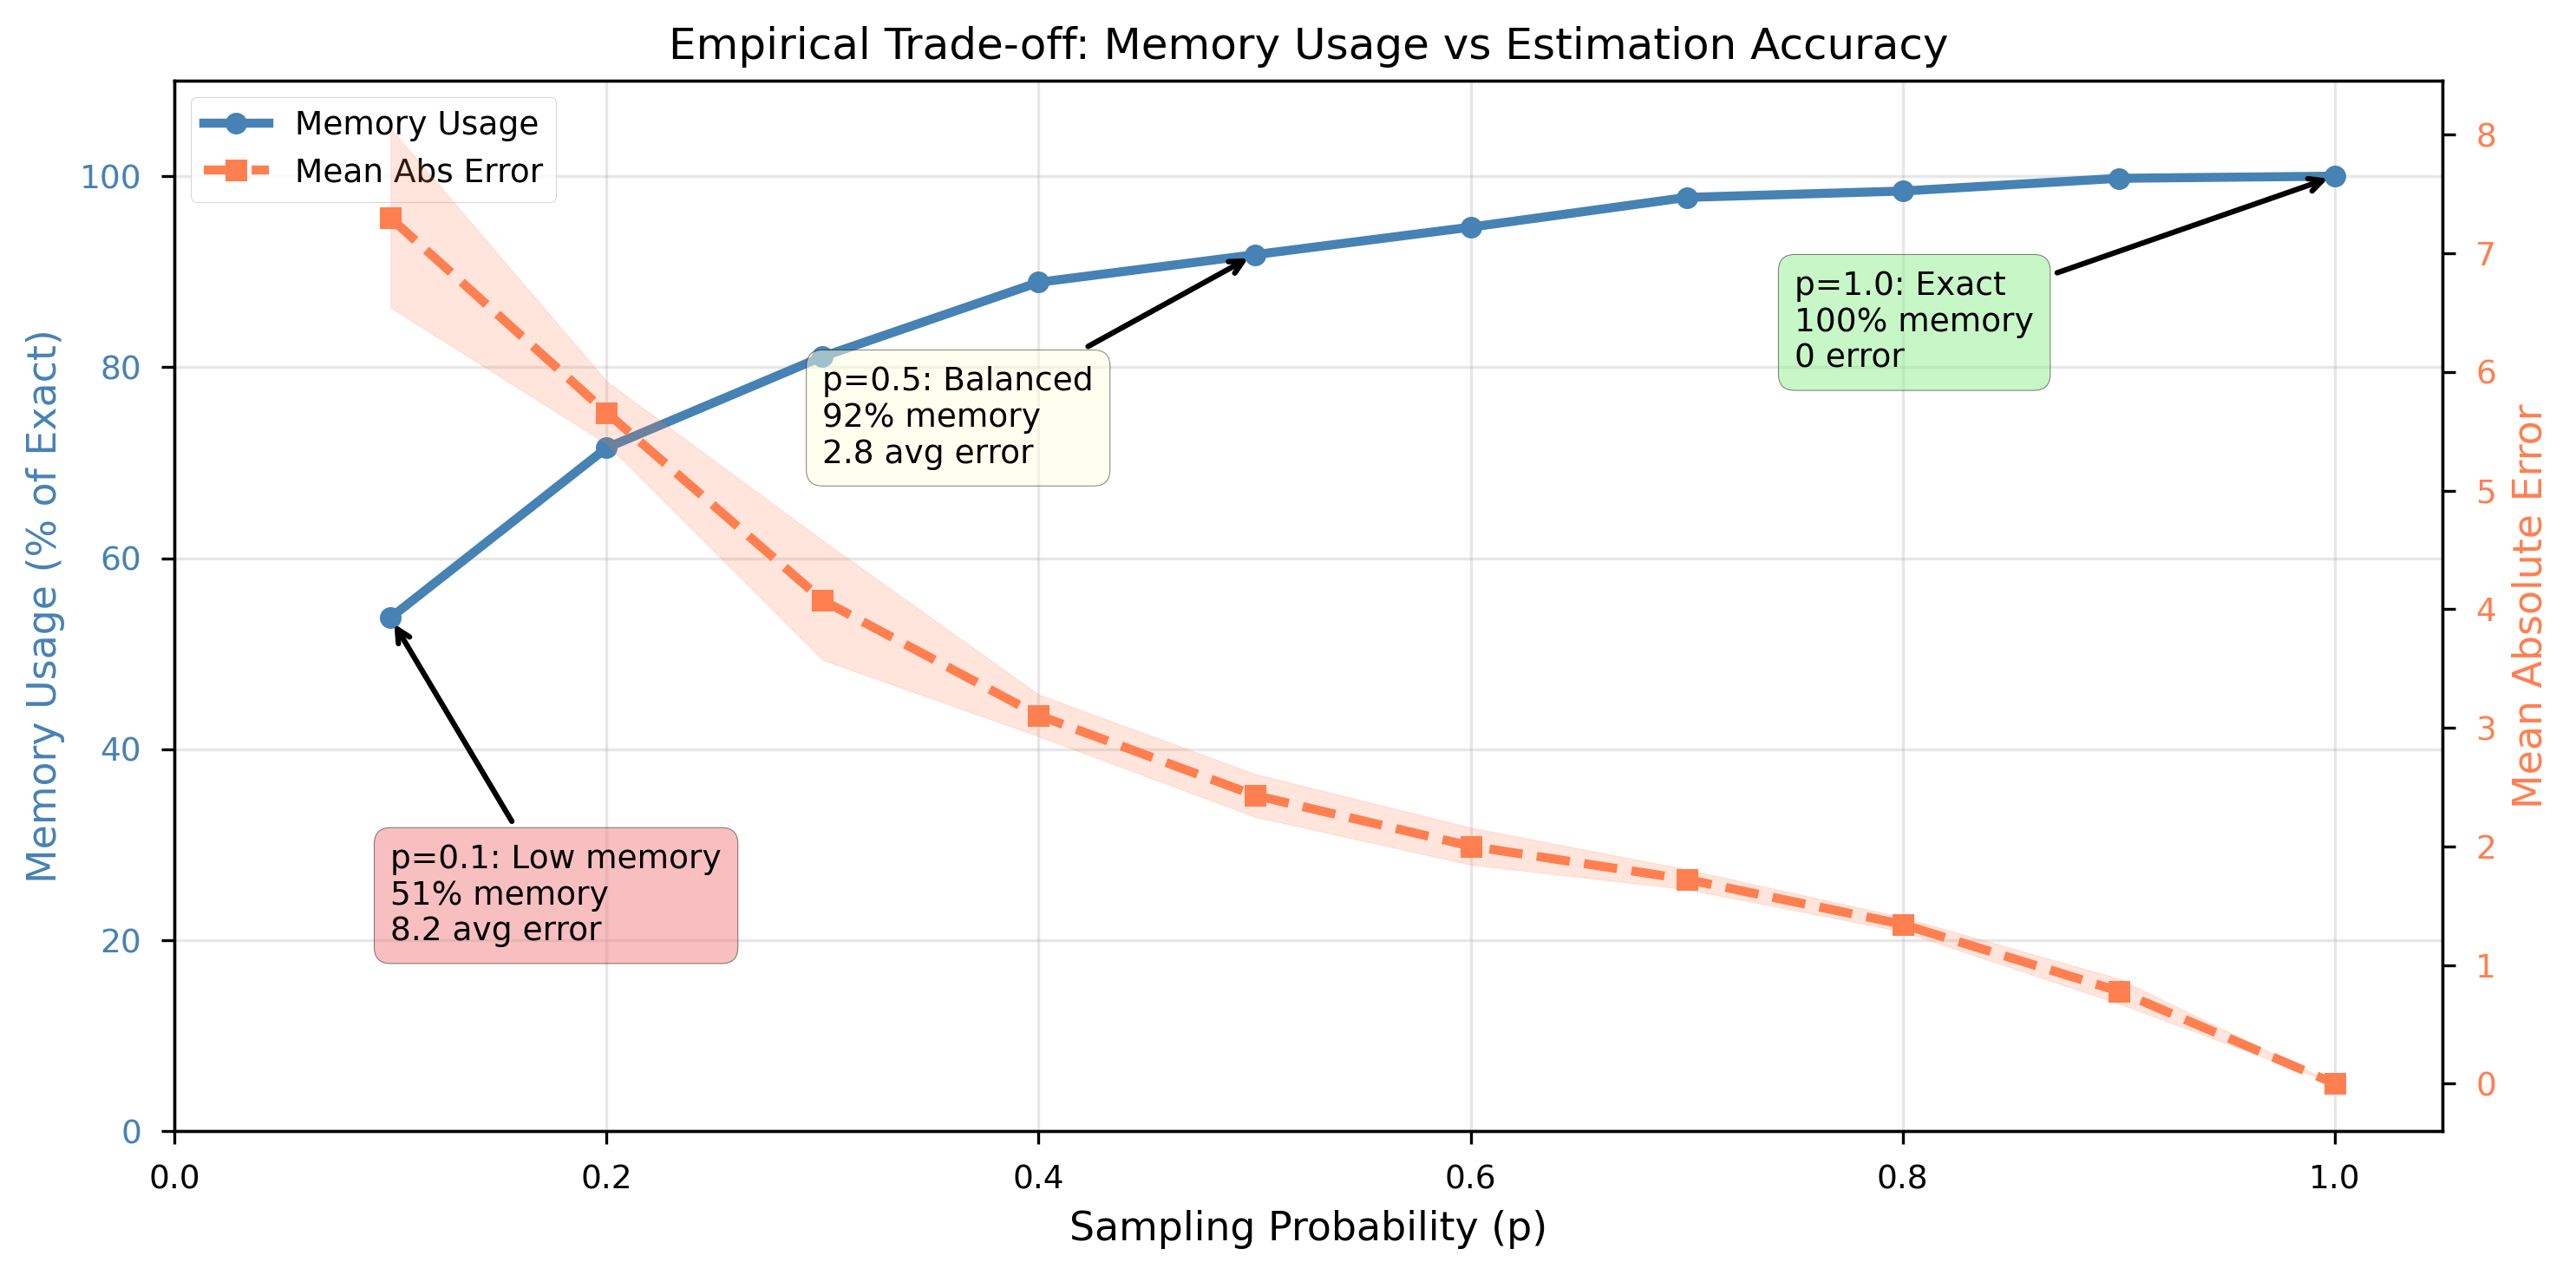

Empirical Trade-off Analysis (Fixed Probability Counter):
    p |  Memory % |  Avg Error | Missing Items %
------------------------------------------------------------
  0.1 |     53.8% |       7.30 |           46.2%
  0.2 |     71.6% |       5.66 |           28.4%
  0.3 |     81.1% |       4.08 |           18.9%
  0.4 |     88.9% |       3.10 |           11.1%
  0.5 |     91.8% |       2.43 |            8.2%
  0.6 |     94.7% |       2.00 |            5.3%
  0.7 |     97.8% |       1.72 |            2.2%
  0.8 |     98.4% |       1.34 |            1.6%
  0.9 |     99.8% |       0.78 |            0.2%
  1.0 |    100.0% |       0.00 |            0.0%


In [7]:
# Use empirical data from probability_tradeoff.csv
p_values = prob_tradeoff['probability_p']
memory_usage = prob_tradeoff['memory_percentage']
mean_abs_error = prob_tradeoff['mean_abs_error']
std_abs_error = prob_tradeoff['std_abs_error']

# Create figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot memory usage on left y-axis
color_memory = 'steelblue'
ax1.set_xlabel('Sampling Probability (p)')
ax1.set_ylabel('Memory Usage (% of Exact)', color=color_memory)
line1 = ax1.plot(p_values, memory_usage, linewidth=2.5, color=color_memory, 
                  label='Memory Usage', marker='o', markersize=6)
ax1.tick_params(axis='y', labelcolor=color_memory)
ax1.grid(alpha=0.3)
ax1.set_xlim(0, 1.05)
ax1.set_ylim(0, 110)

# Create second y-axis for absolute error (stability metric)
ax2 = ax1.twinx()
color_stability = 'coral'
ax2.set_ylabel('Mean Absolute Error', color=color_stability)
line2 = ax2.plot(p_values, mean_abs_error, linewidth=2.5, color=color_stability, 
                  linestyle='--', label='Mean Abs Error', marker='s', markersize=6)
ax2.tick_params(axis='y', labelcolor=color_stability)

# Add error bars for stability
ax2.fill_between(p_values, 
                  mean_abs_error - std_abs_error, 
                  mean_abs_error + std_abs_error, 
                  color=color_stability, alpha=0.2, label='±1 Std Dev')

# Add title
ax1.set_title('Empirical Trade-off: Memory Usage vs Estimation Accuracy')

# Combine legends from both axes
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

# Add annotations for key trade-off points
ax1.annotate('p=1.0: Exact\n100% memory\n0 error', 
             xy=(1.0, 100), xytext=(0.75, 80),
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
             fontsize=9, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.5))

ax1.annotate('p=0.5: Balanced\n92% memory\n2.8 avg error', 
             xy=(0.5, prob_tradeoff[prob_tradeoff['probability_p']==0.5]['memory_percentage'].values[0]), 
             xytext=(0.3, 70),
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
             fontsize=9, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.5))

ax1.annotate('p=0.1: Low memory\n51% memory\n8.2 avg error', 
             xy=(0.1, prob_tradeoff[prob_tradeoff['probability_p']==0.1]['memory_percentage'].values[0]), 
             xytext=(0.1, 20),
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
             fontsize=9, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"Empirical Trade-off Analysis (Fixed Probability Counter):")
print(f"{'p':>5} | {'Memory %':>9} | {'Avg Error':>10} | {'Missing Items %':>15}")
print("-" * 60)
for _, row in prob_tradeoff.iterrows():
    print(f"{row['probability_p']:>5.1f} | {row['memory_percentage']:>8.1f}% | {row['mean_abs_error']:>10.2f} | {row['missing_items_pct']:>14.1f}%")

## 2. Exact vs Approximate Counter

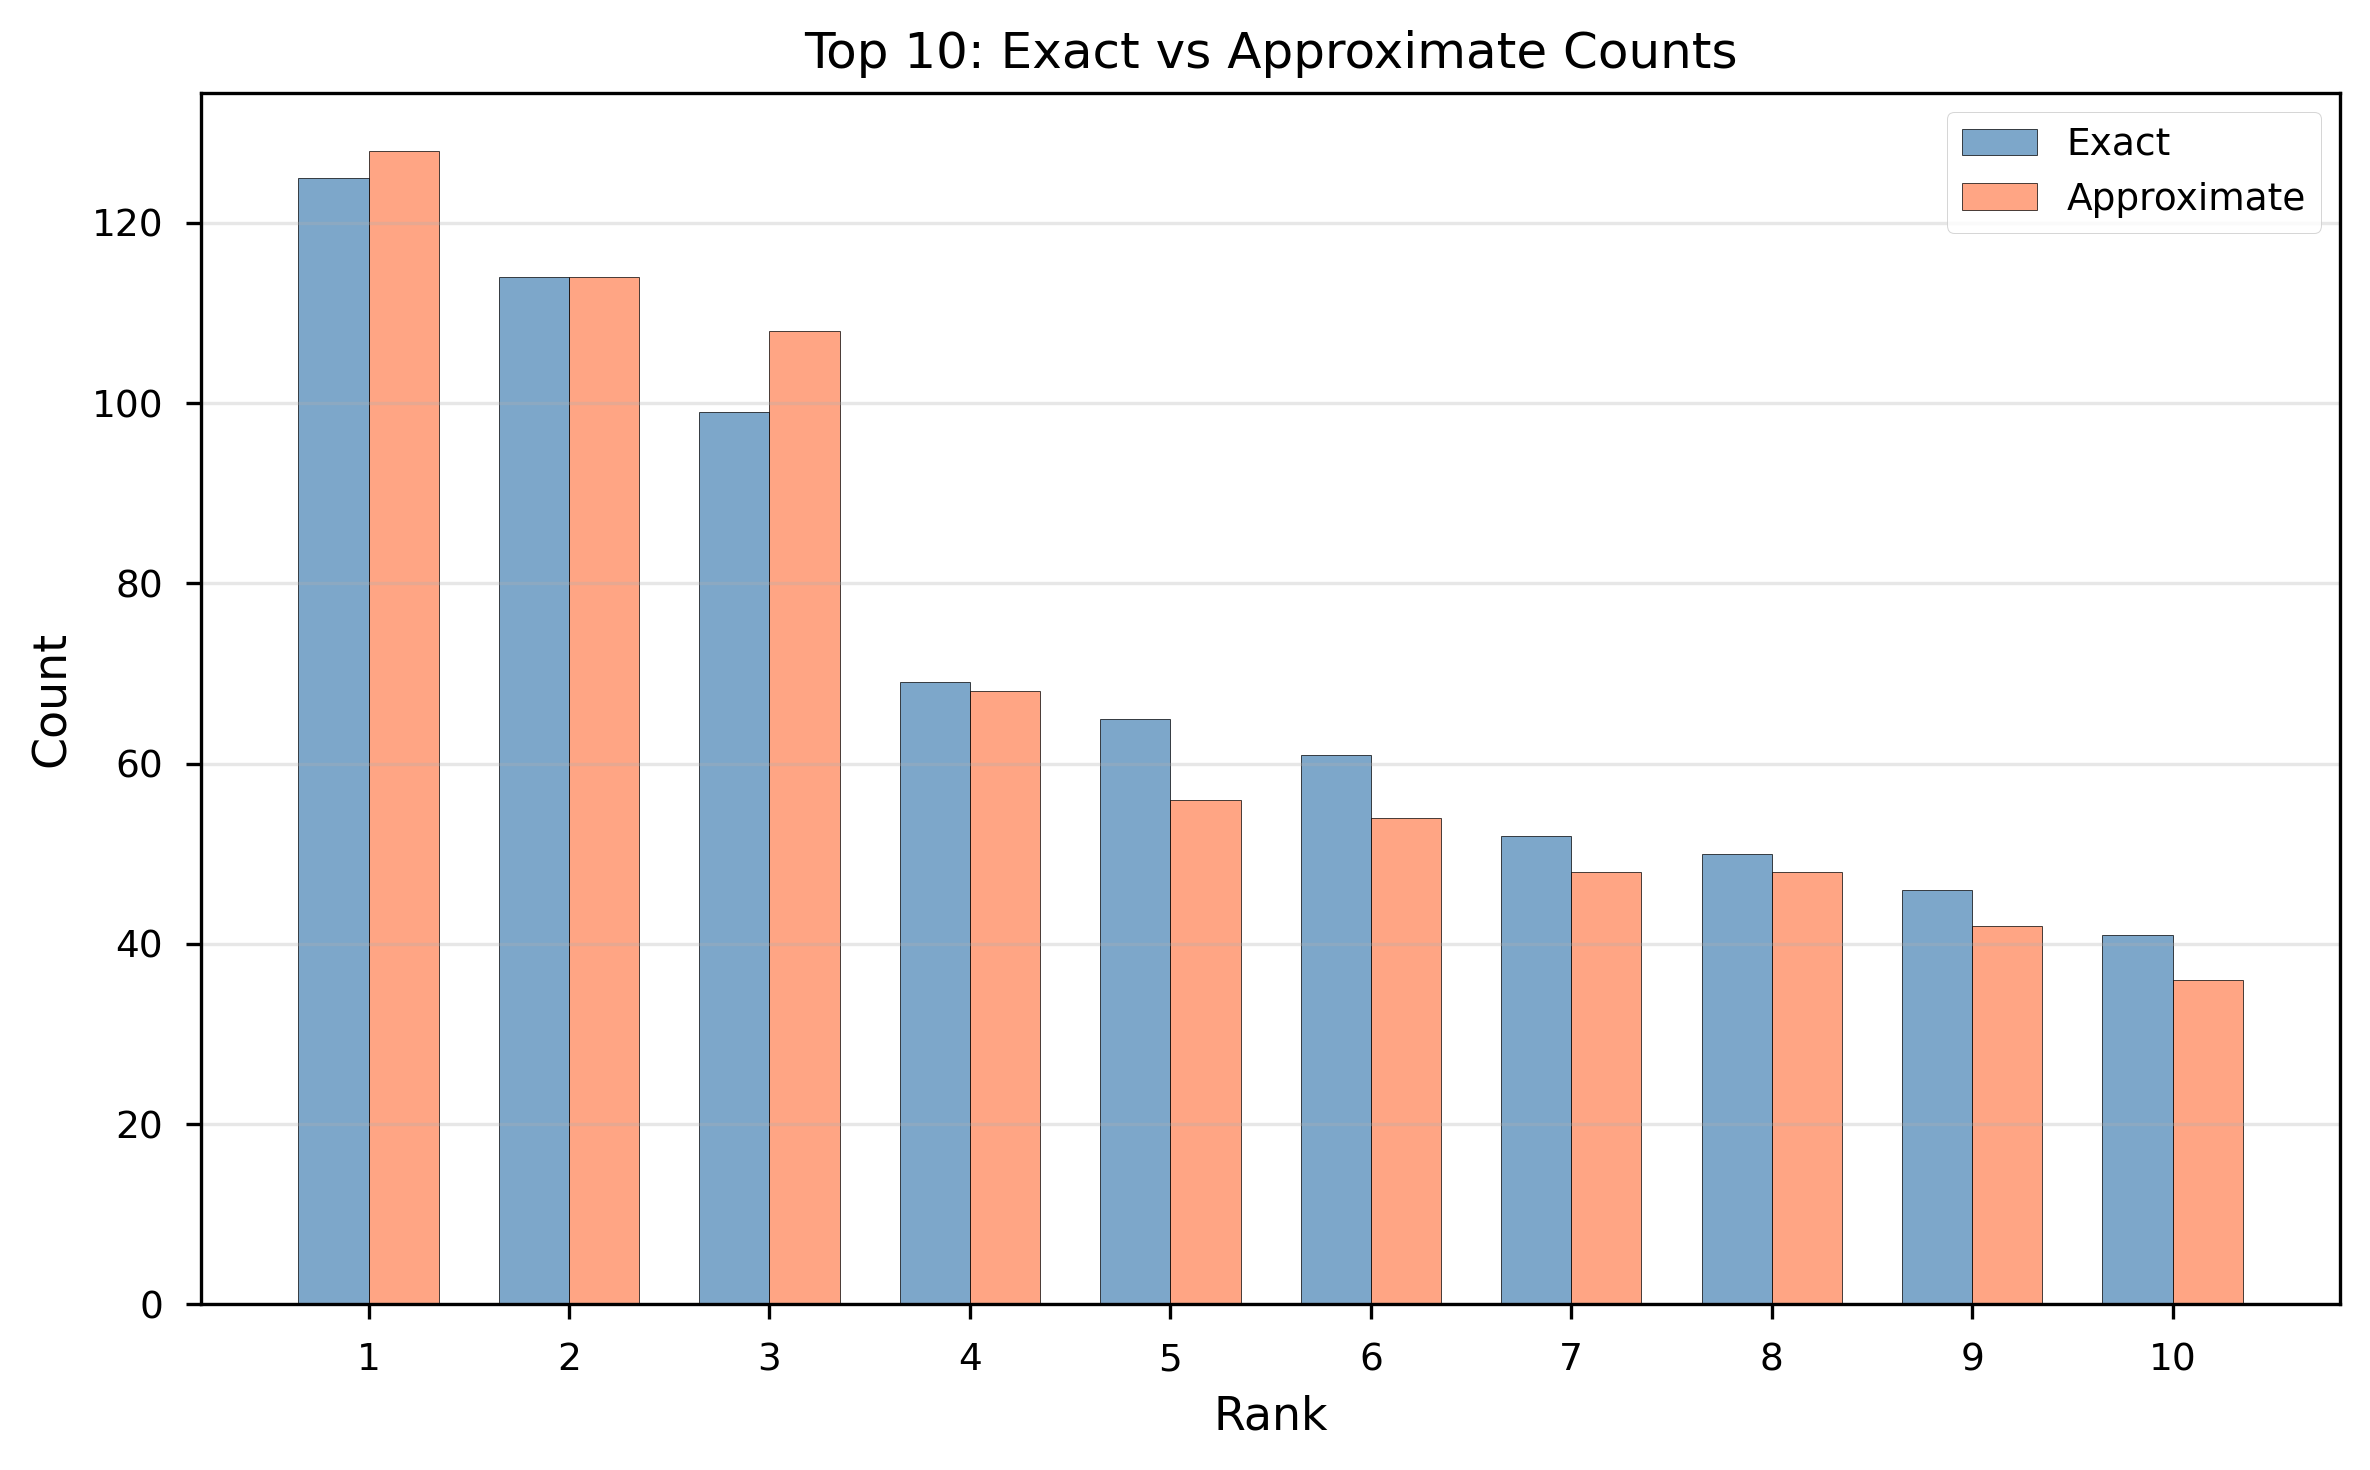

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(approx_top10))
width = 0.35

ax.bar(x - width/2, approx_top10['exact_count'], width, label='Exact', 
       edgecolor='black', color='steelblue', alpha=0.7)
ax.bar(x + width/2, approx_top10['approx_count'], width, label='Approximate', 
       edgecolor='black', color='coral', alpha=0.7)
ax.set_xlabel('Rank')
ax.set_ylabel('Count')
ax.set_title('Top 10: Exact vs Approximate Counts')
ax.set_xticks(x)
ax.set_xticklabels(approx_top10['rank'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

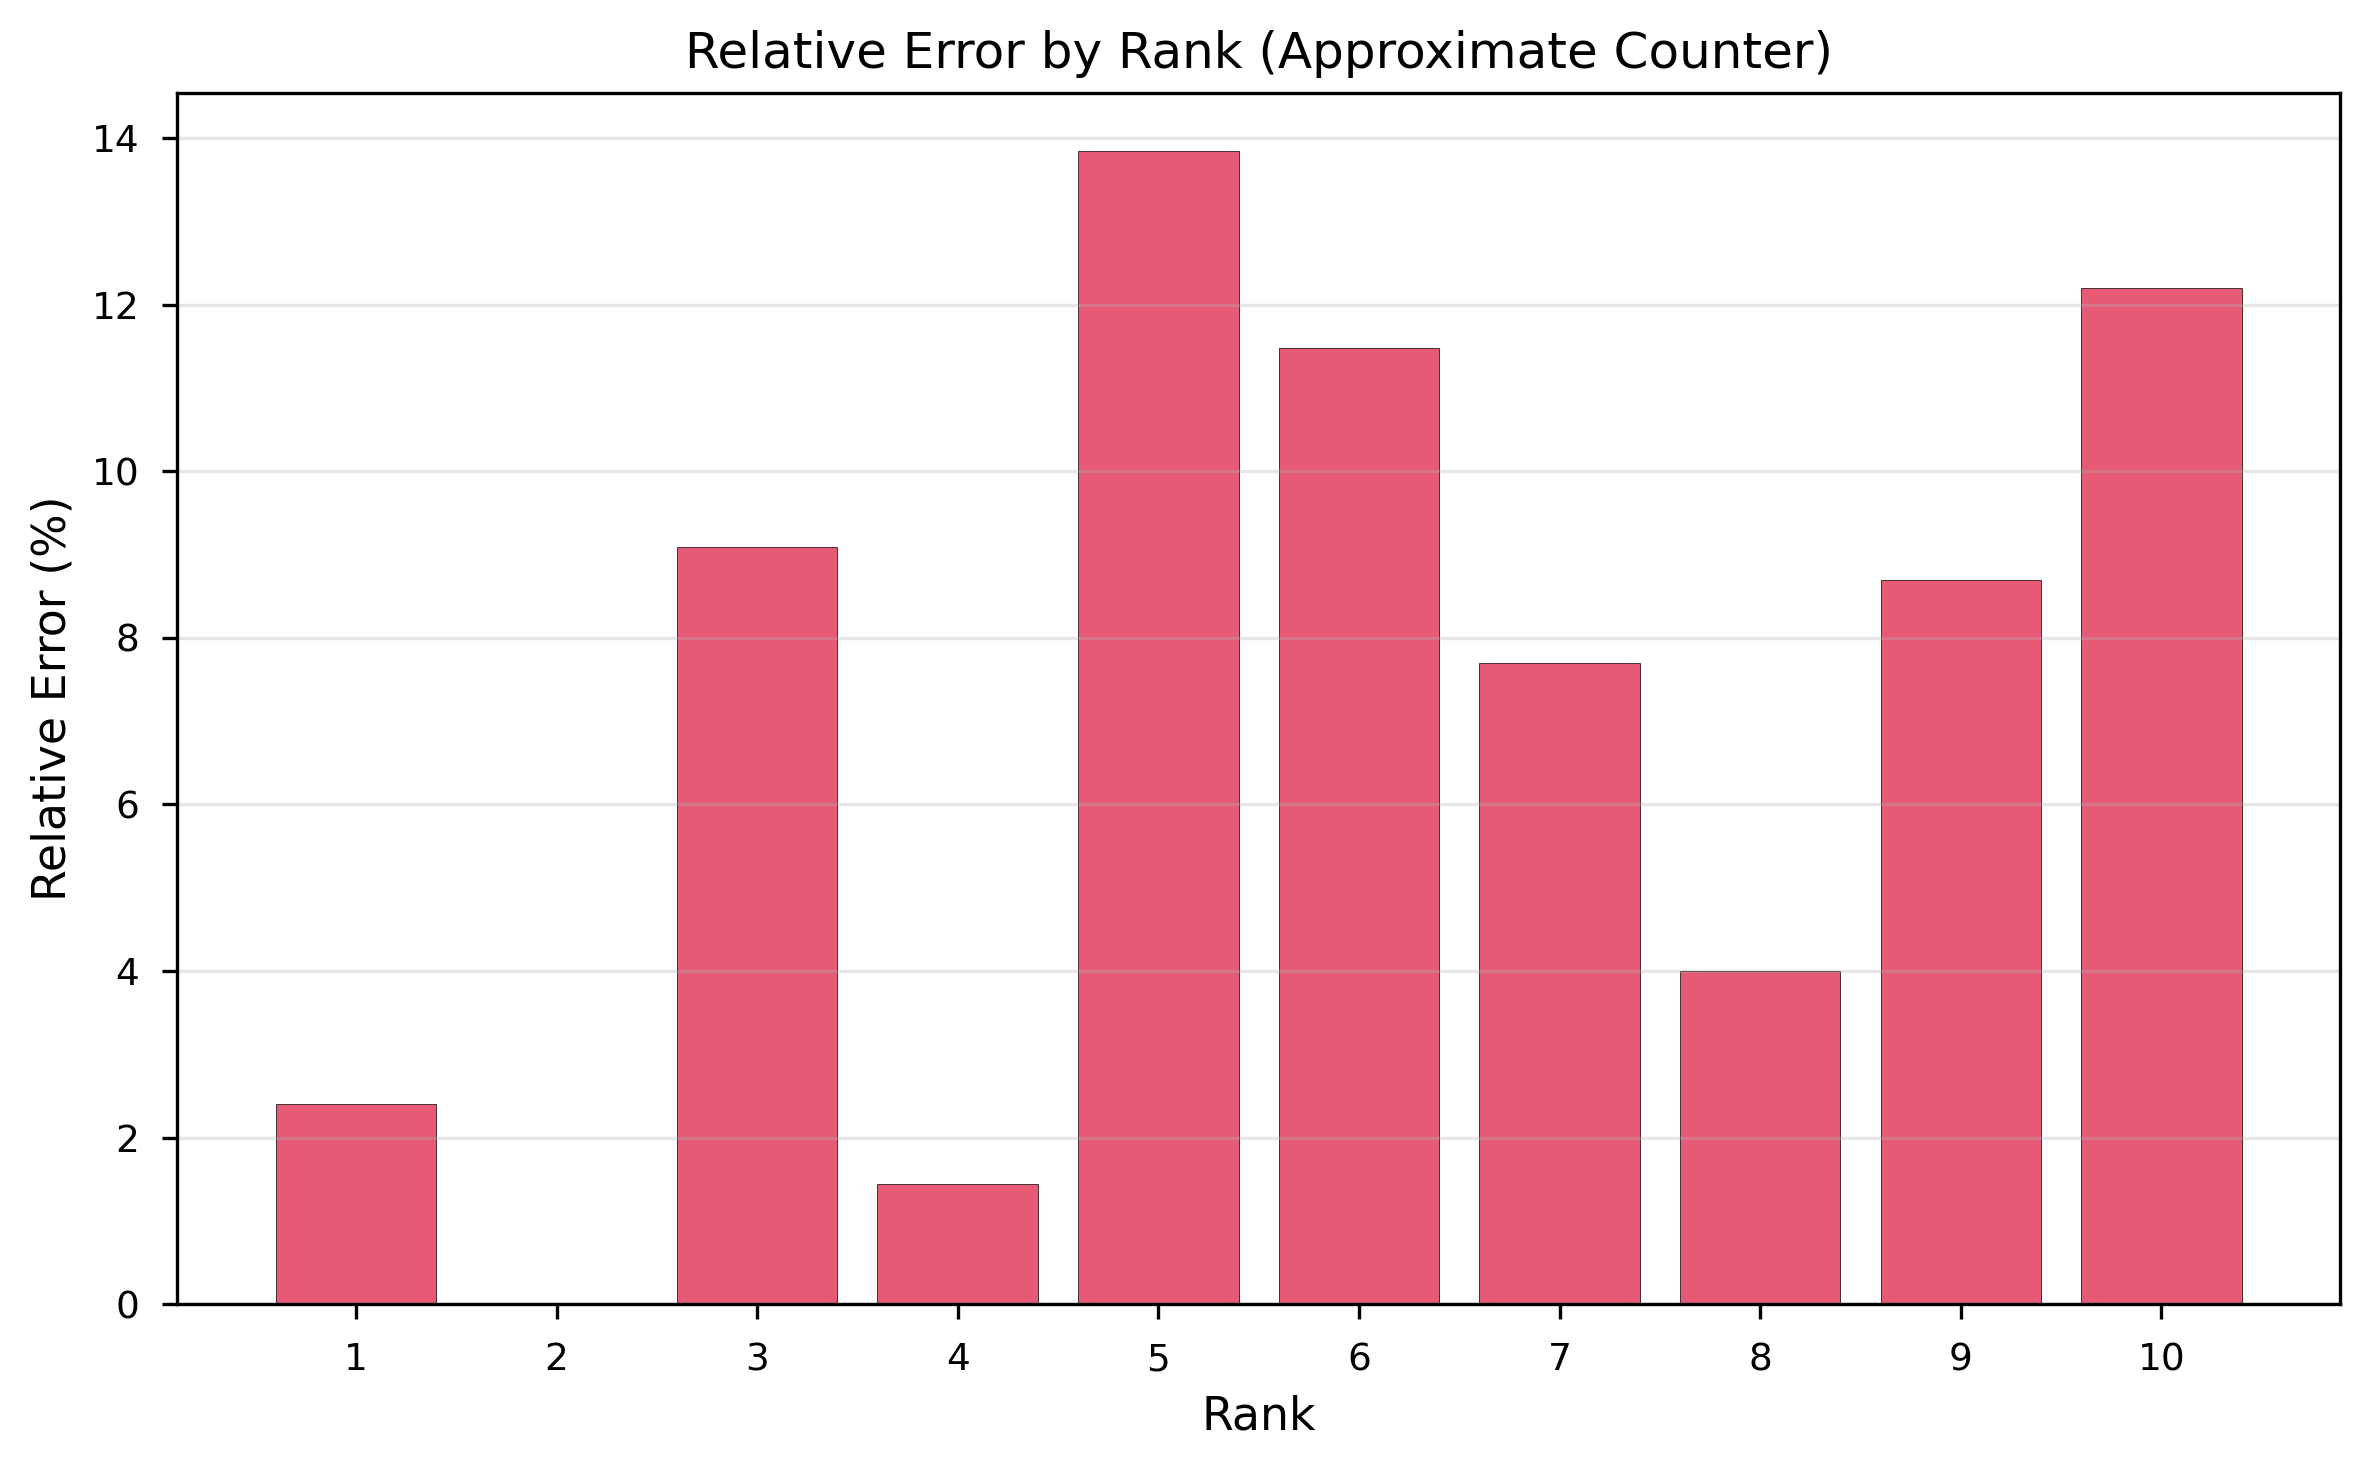

In [9]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(approx_top10['rank'], approx_top10['rel_error_pct'], 
       edgecolor='black', color='crimson', alpha=0.7)
ax.set_xlabel('Rank')
ax.set_ylabel('Relative Error (%)')
ax.set_title('Relative Error by Rank (Approximate Counter)')
ax.set_xticks(approx_top10['rank'])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Approximate Counter Error Statistics

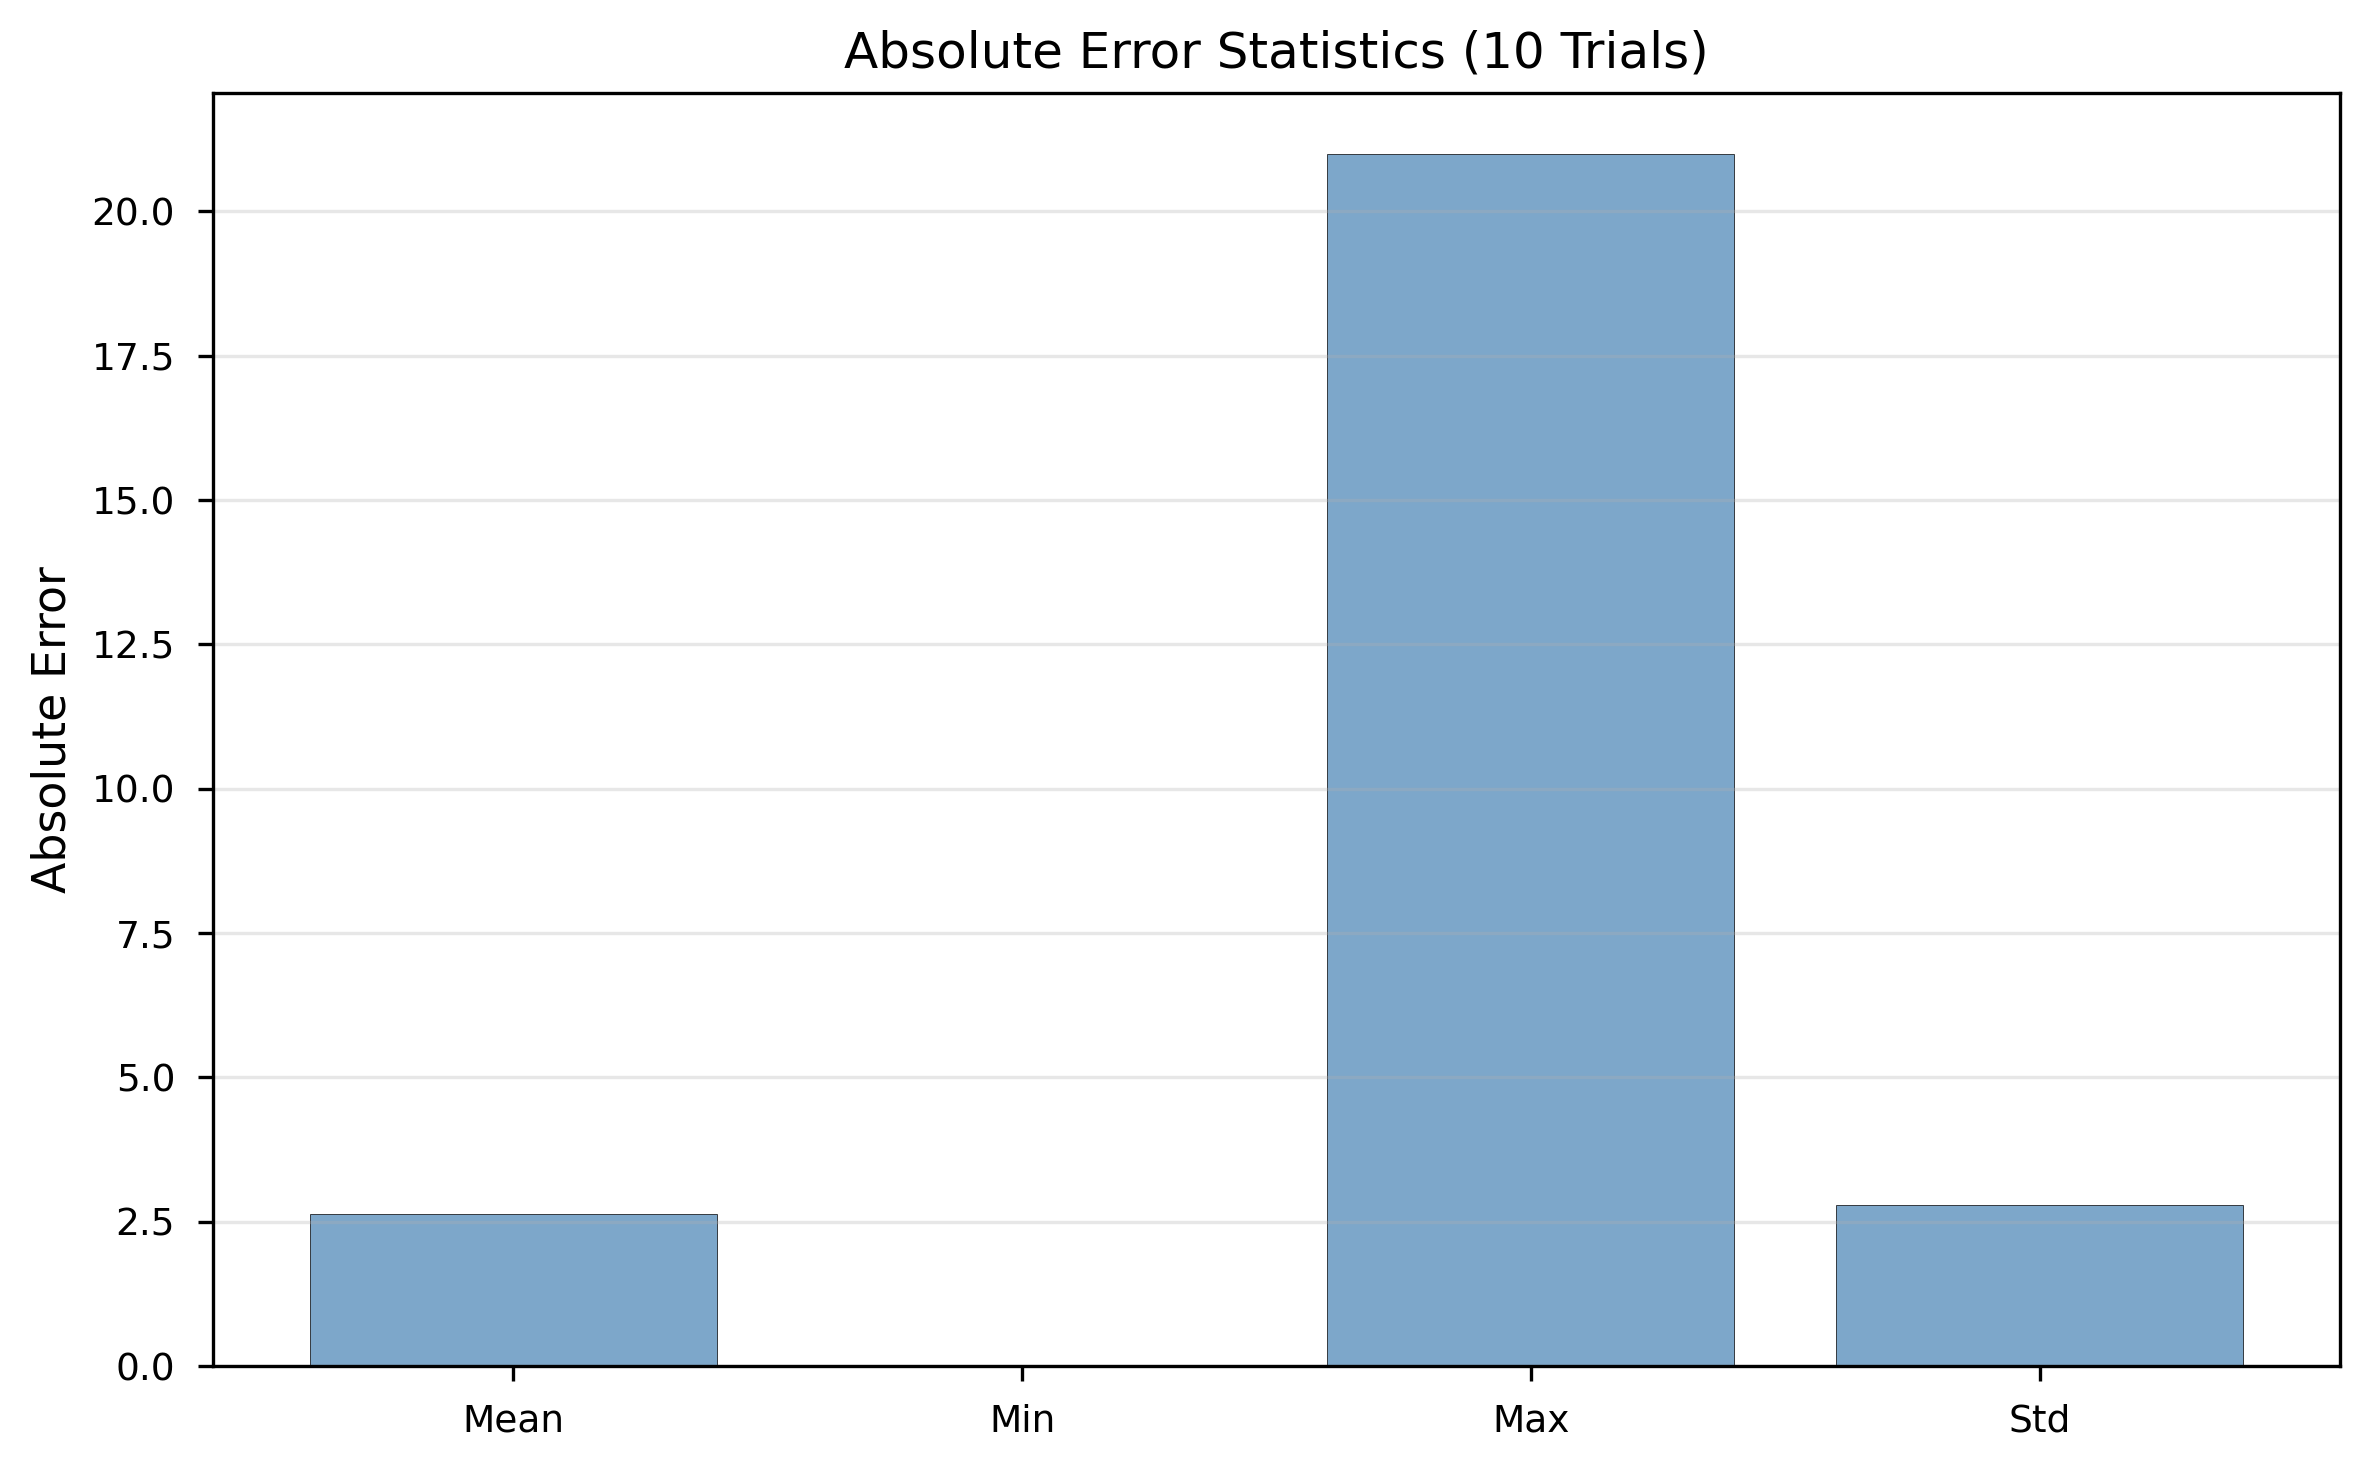

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

abs_metrics = approx_stats[approx_stats['metric'].str.contains('absolute_error')]
metrics_labels = ['Mean', 'Min', 'Max', 'Std']
abs_values = abs_metrics['value'].values

ax.bar(metrics_labels, abs_values, edgecolor='black', color='steelblue', alpha=0.7)
ax.set_ylabel('Absolute Error')
ax.set_title('Absolute Error Statistics (10 Trials)')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

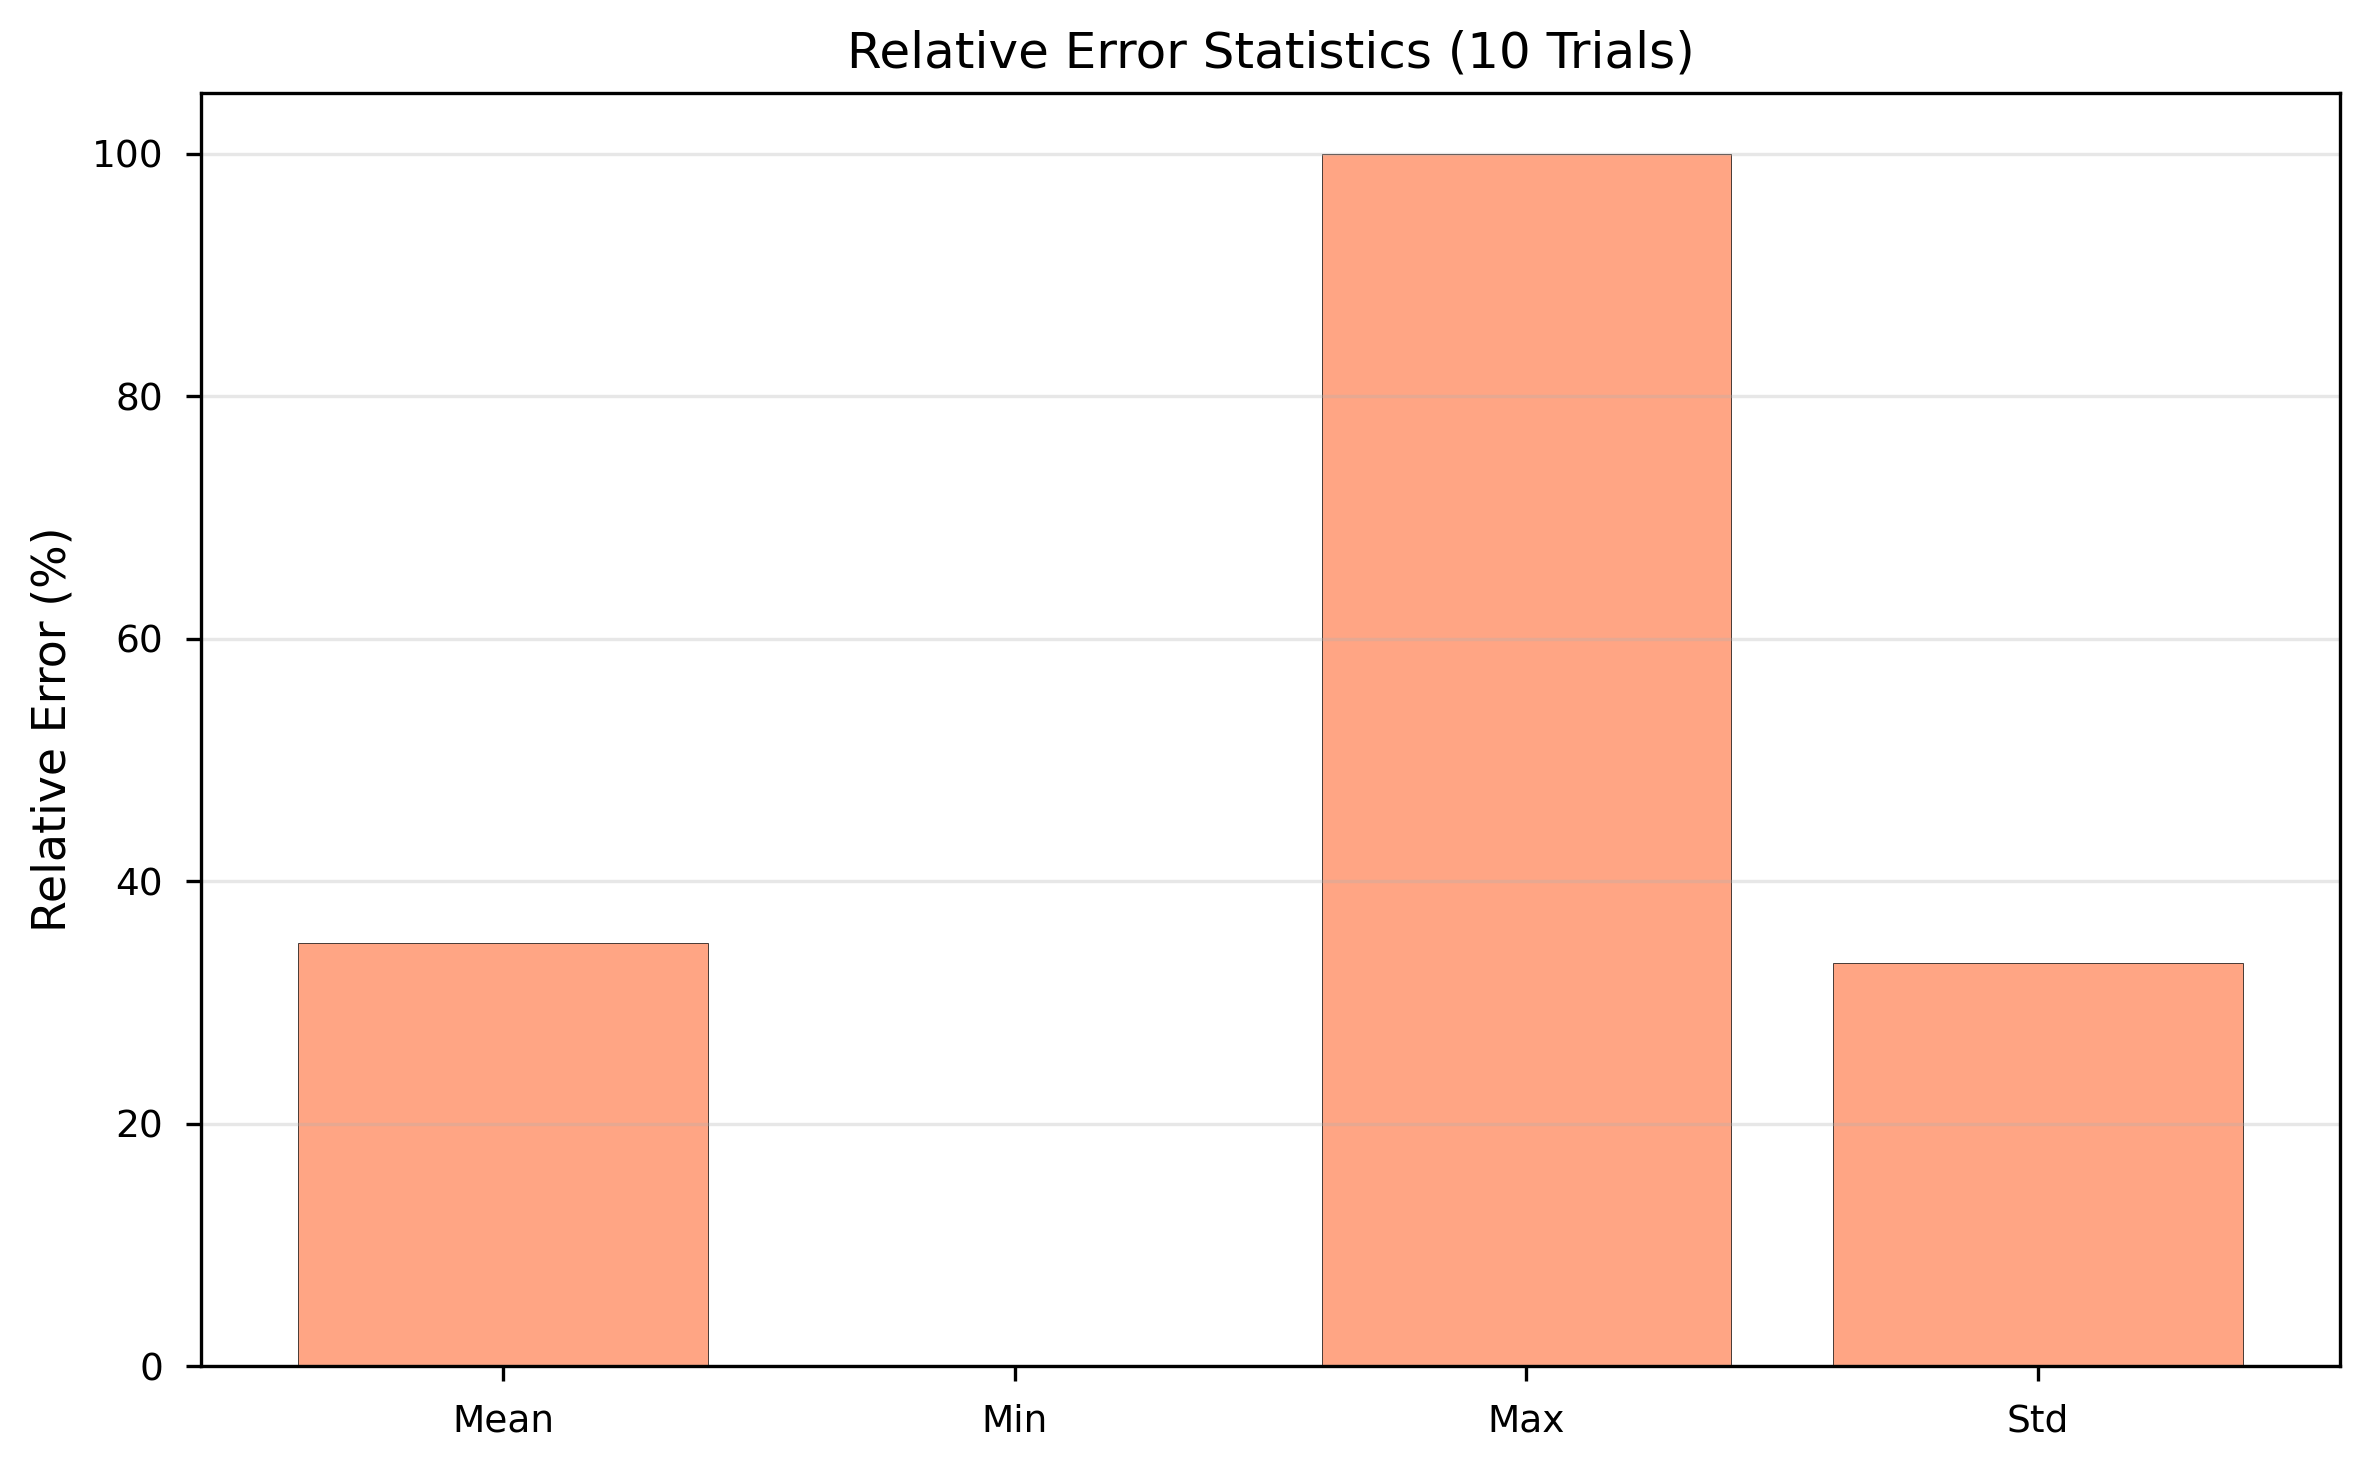

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

rel_metrics = approx_stats[approx_stats['metric'].str.contains('relative_error')]
metrics_labels = ['Mean', 'Min', 'Max', 'Std']
rel_values = rel_metrics['value'].values

ax.bar(metrics_labels, rel_values, edgecolor='black', color='coral', alpha=0.7)
ax.set_ylabel('Relative Error (%)')
ax.set_title('Relative Error Statistics (10 Trials)')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Space-Saving Algorithm Performance

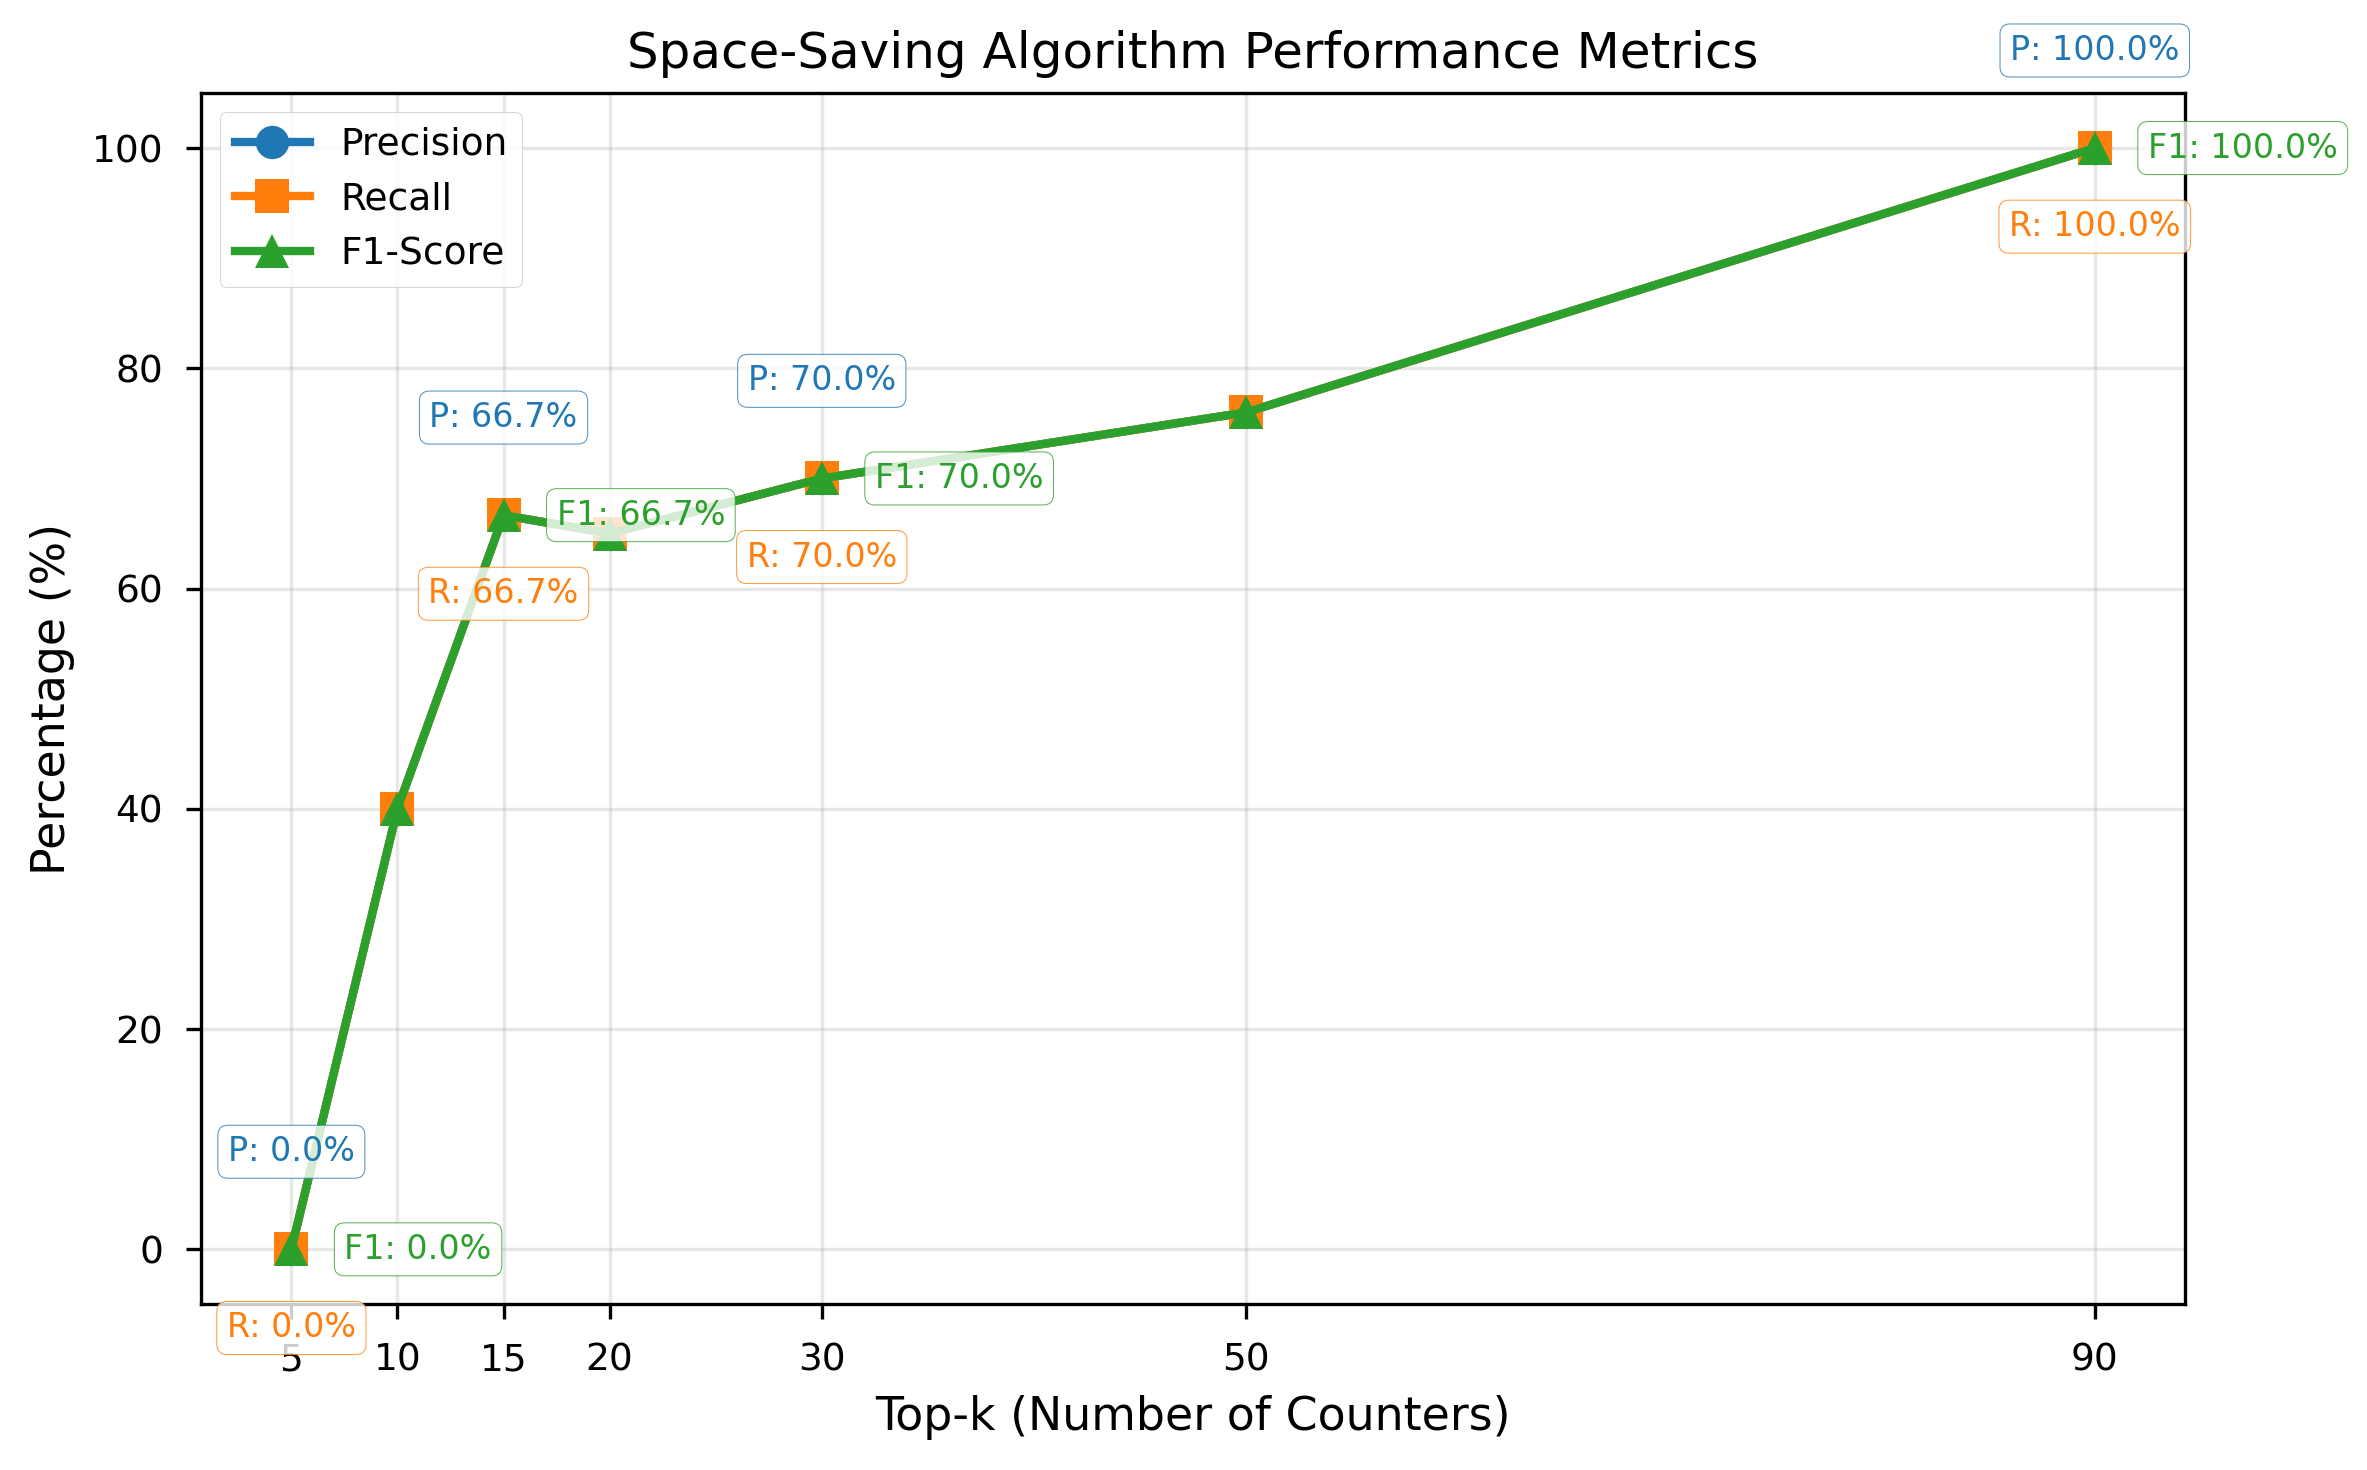

In [22]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(ss_performance['top_k'], ss_performance['precision_pct'], 
        marker='o', label='Precision', linewidth=2, markersize=8)
ax.plot(ss_performance['top_k'], ss_performance['recall_pct'], 
        marker='s', label='Recall', linewidth=2, markersize=8)
ax.plot(ss_performance['top_k'], ss_performance['f1_score_pct'], 
        marker='^', label='F1-Score', linewidth=2, markersize=8)

ax.set_xlabel('Top-k (Number of Counters)')
ax.set_ylabel('Percentage (%)')
ax.set_title('Space-Saving Algorithm Performance Metrics')
ax.set_xticks(ss_performance['top_k'])
ax.legend()
ax.grid(alpha=0.3)

# Add percentage labels at key points only (to avoid clutter)
key_points = [0, 2, 4, 6]  # Indices for m=5, 15, 30, 90
for idx in key_points:
    row = ss_performance.iloc[idx]
    
    # Precision label (above, with background)
    ax.text(row['top_k'], row['precision_pct'] + 8, 
            f"P: {row['precision_pct']:.1f}%", 
            ha='center', fontsize=8, color='C0',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='C0', alpha=0.8))
    
    # Recall label (below, with background)
    ax.text(row['top_k'], row['recall_pct'] - 8, 
            f"R: {row['recall_pct']:.1f}%", 
            ha='center', fontsize=8, color='C1',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='C1', alpha=0.8))
    
    # F1-Score label (to the right, with background)
    ax.text(row['top_k'] + 2.5, row['f1_score_pct'], 
            f"F1: {row['f1_score_pct']:.1f}%", 
            ha='left', fontsize=8, color='C2', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='C2', alpha=0.8))

plt.tight_layout()
plt.show()

## 5. Algorithm Comparison (Top 10)

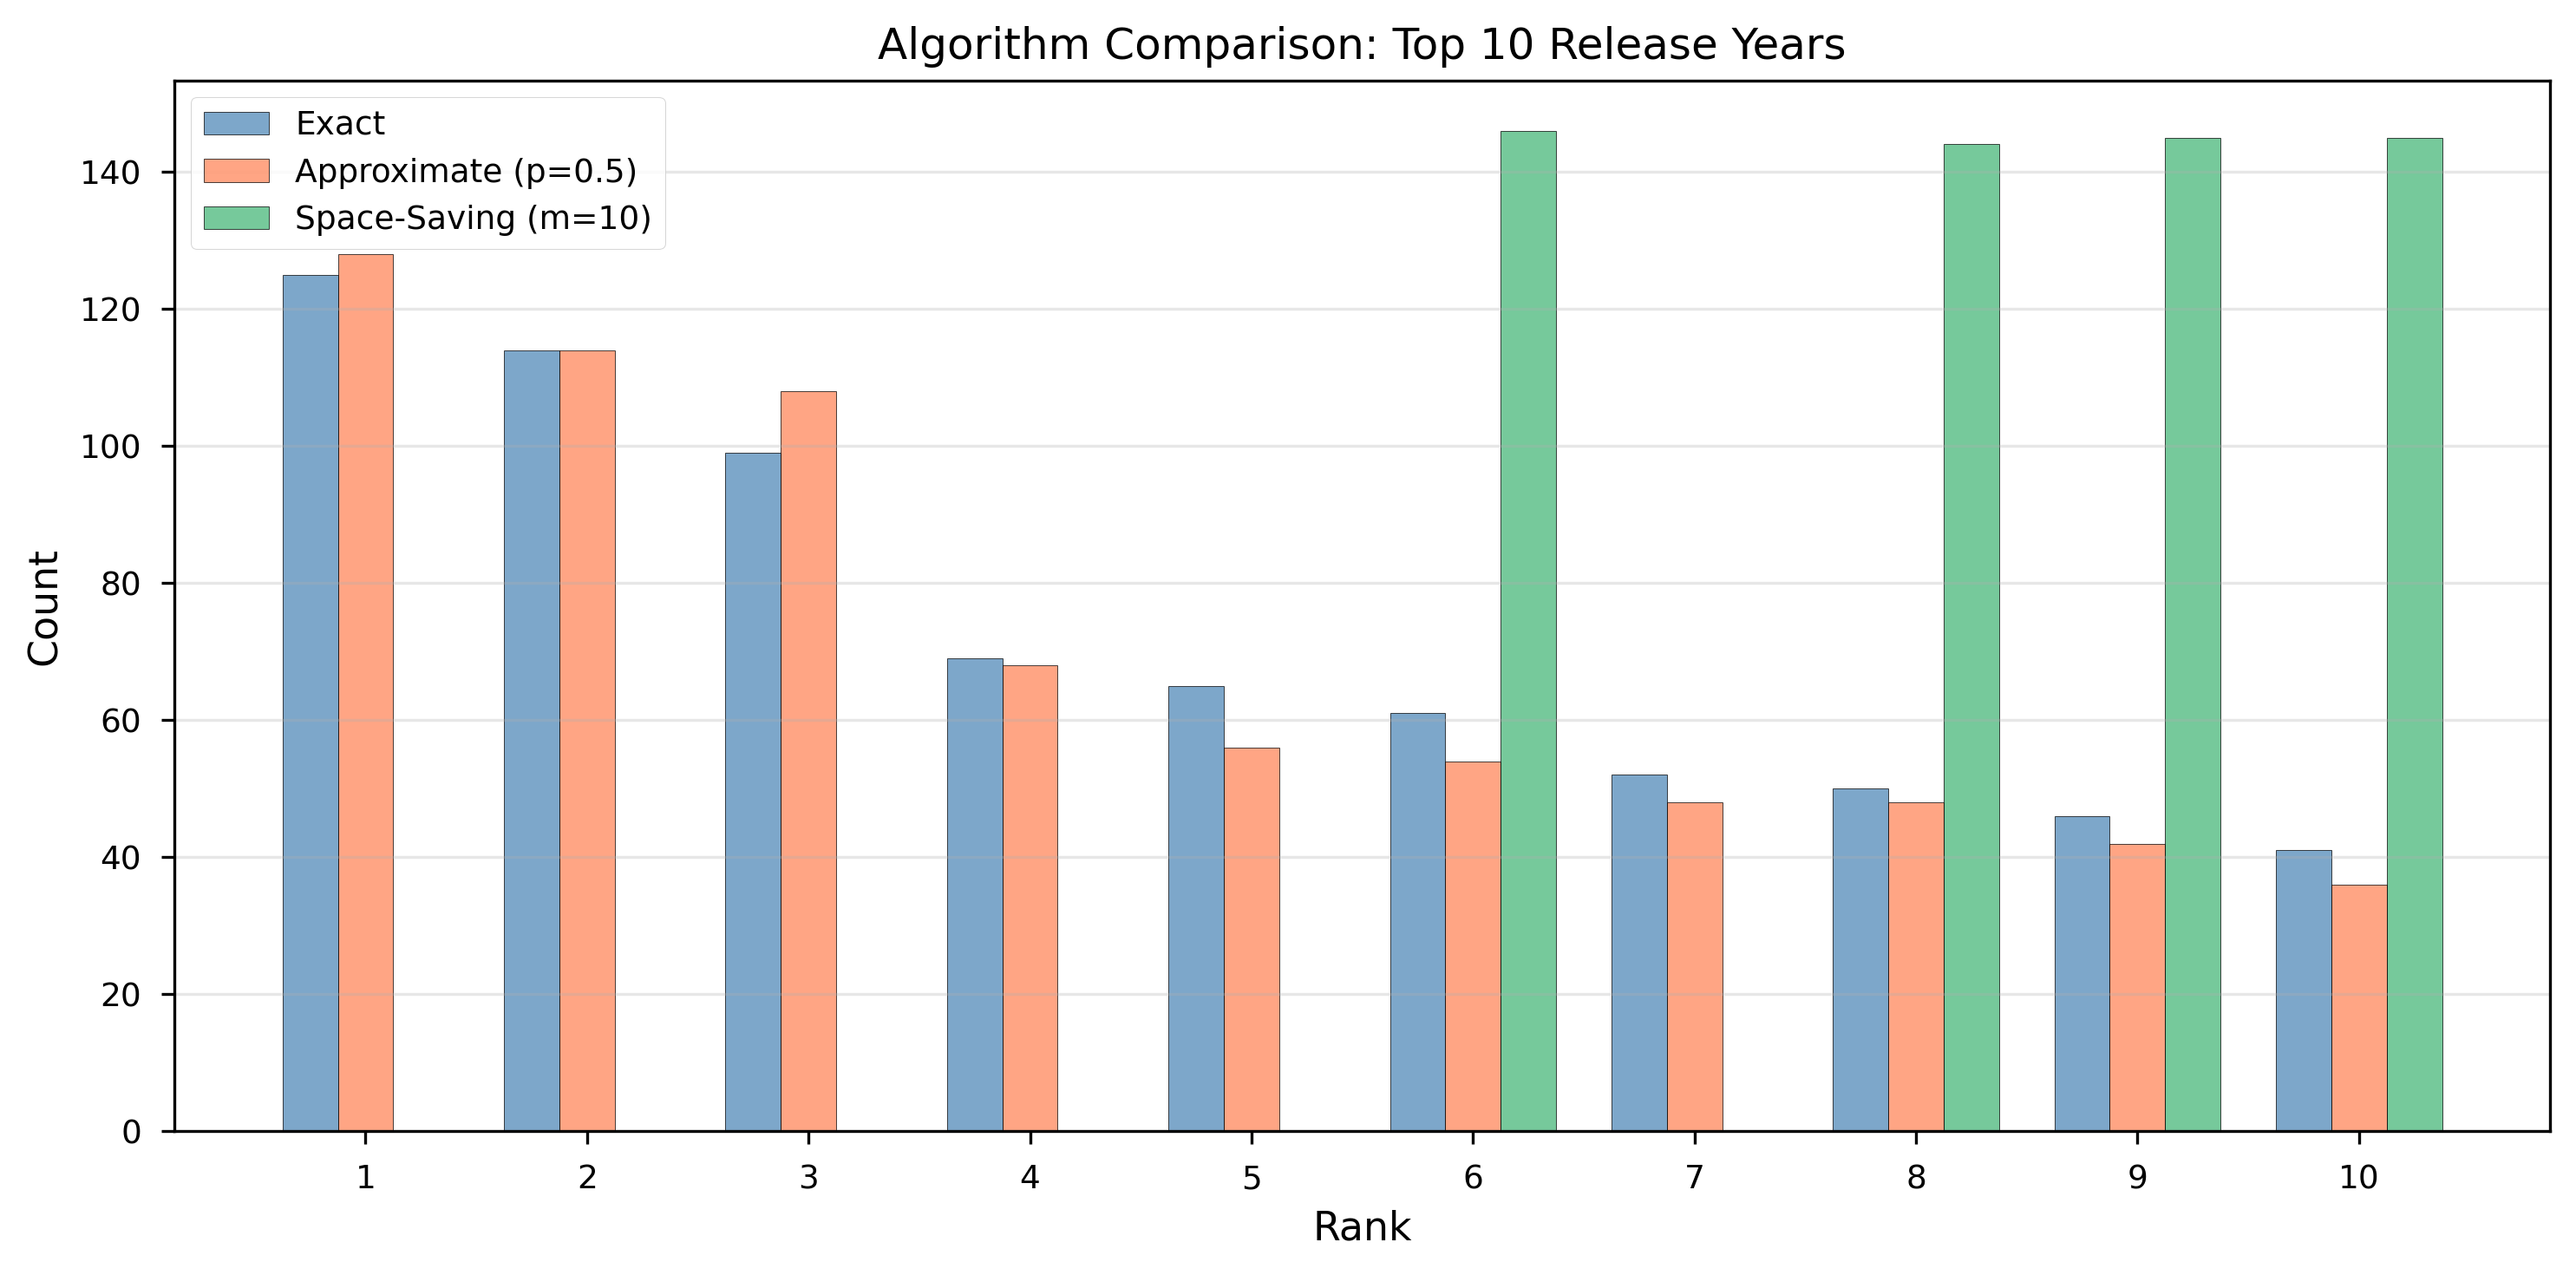

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(approx_top10))
width = 0.25

ax.bar(x - width, approx_top10['exact_count'], width, label='Exact', 
       edgecolor='black', color='steelblue', alpha=0.7)
ax.bar(x, approx_top10['approx_count'], width, label='Approximate (p=0.5)', 
       edgecolor='black', color='coral', alpha=0.7)
ax.bar(x + width, ss_top10['ss_count'], width, label='Space-Saving (m=10)', 
       edgecolor='black', color='mediumseagreen', alpha=0.7)

ax.set_xlabel('Rank')
ax.set_ylabel('Count')
ax.set_title('Algorithm Comparison: Top 10 Release Years')
ax.set_xticks(x)
ax.set_xticklabels(approx_top10['rank'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Order Preservation Analysis

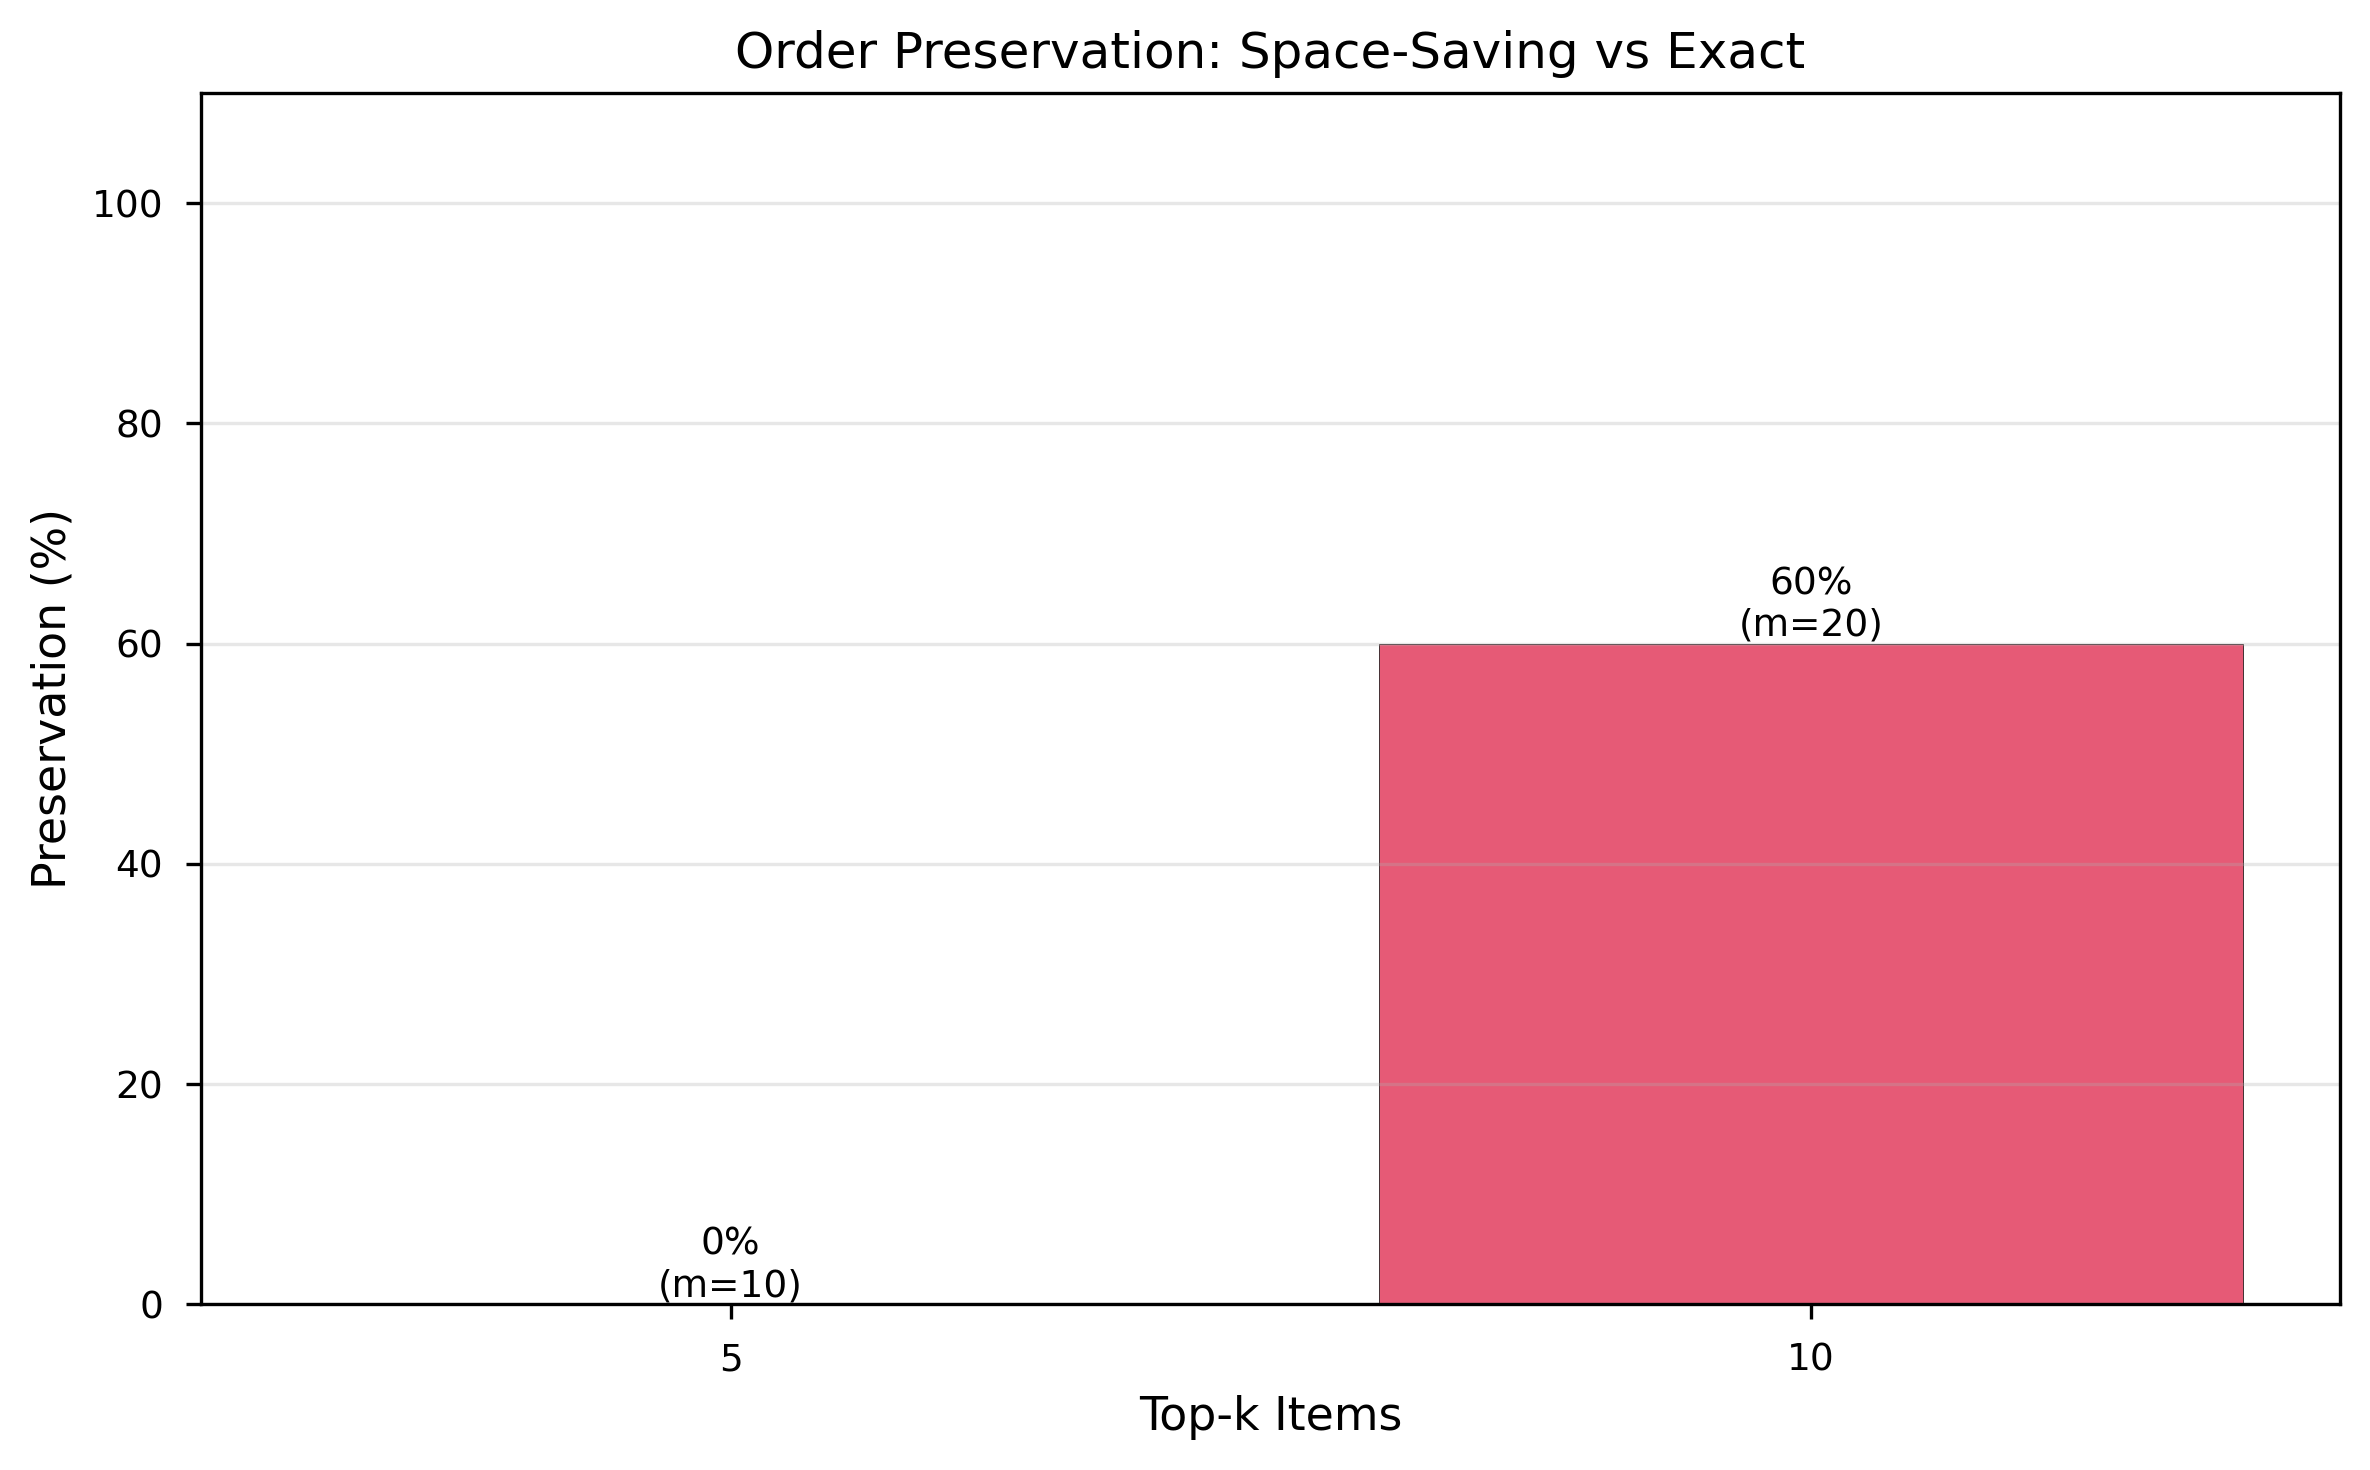

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))

colors = ['crimson' if p < 100 else 'mediumseagreen' 
          for p in order_preservation['preservation_pct']]

bars = ax.bar(order_preservation['top_k'].astype(str), 
              order_preservation['preservation_pct'], 
              edgecolor='black', color=colors, alpha=0.7)

for i, (bar, count) in enumerate(zip(bars, order_preservation['num_counters'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f}%\n(m={count})',
            ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Top-k Items')
ax.set_ylabel('Preservation (%)')
ax.set_title('Order Preservation: Space-Saving vs Exact')
ax.set_ylim(0, 110)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Summary: Accuracy vs Memory Trade-off

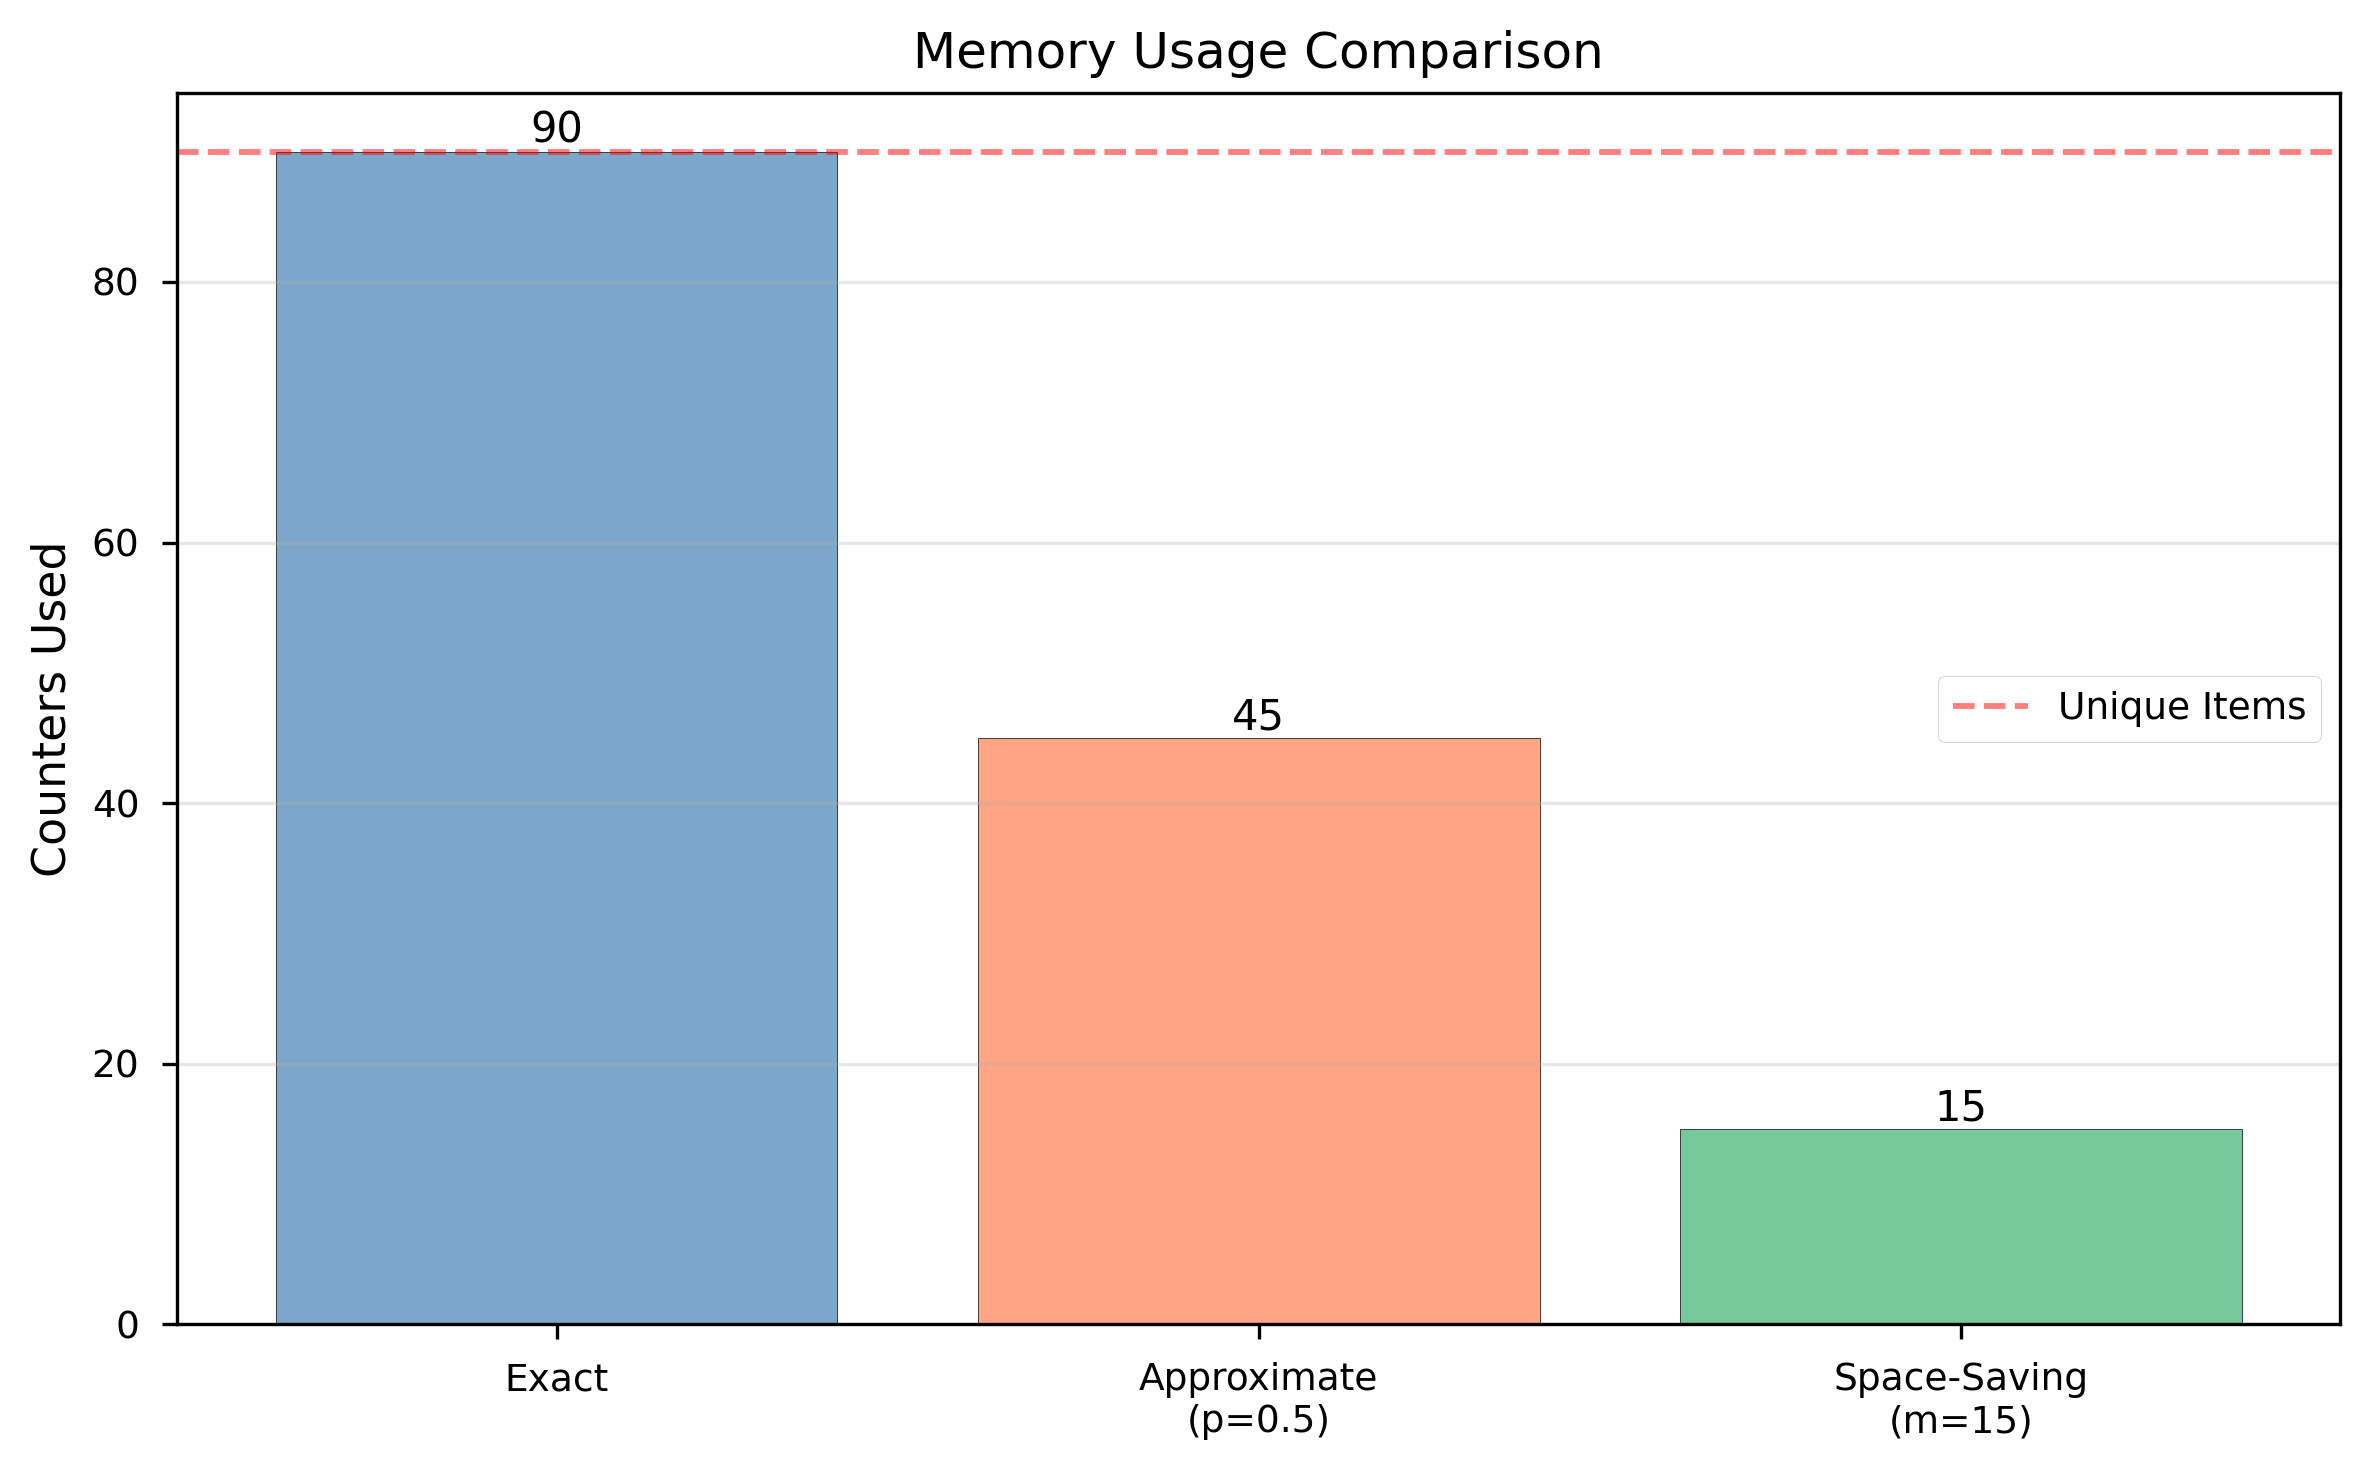

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))

unique_items = len(df['release_year'].unique())
methods = ['Exact', 'Approximate\n(p=0.5)', 'Space-Saving\n(m=15)']
memory_usage = [unique_items, unique_items * 0.5, 15]

bars = ax.bar(methods, memory_usage, edgecolor='black', 
              color=['steelblue', 'coral', 'mediumseagreen'], alpha=0.7)
ax.axhline(y=unique_items, color='red', linestyle='--', alpha=0.5, label='Unique Items')
ax.set_ylabel('Counters Used')
ax.set_title('Memory Usage Comparison')
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, memory_usage):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

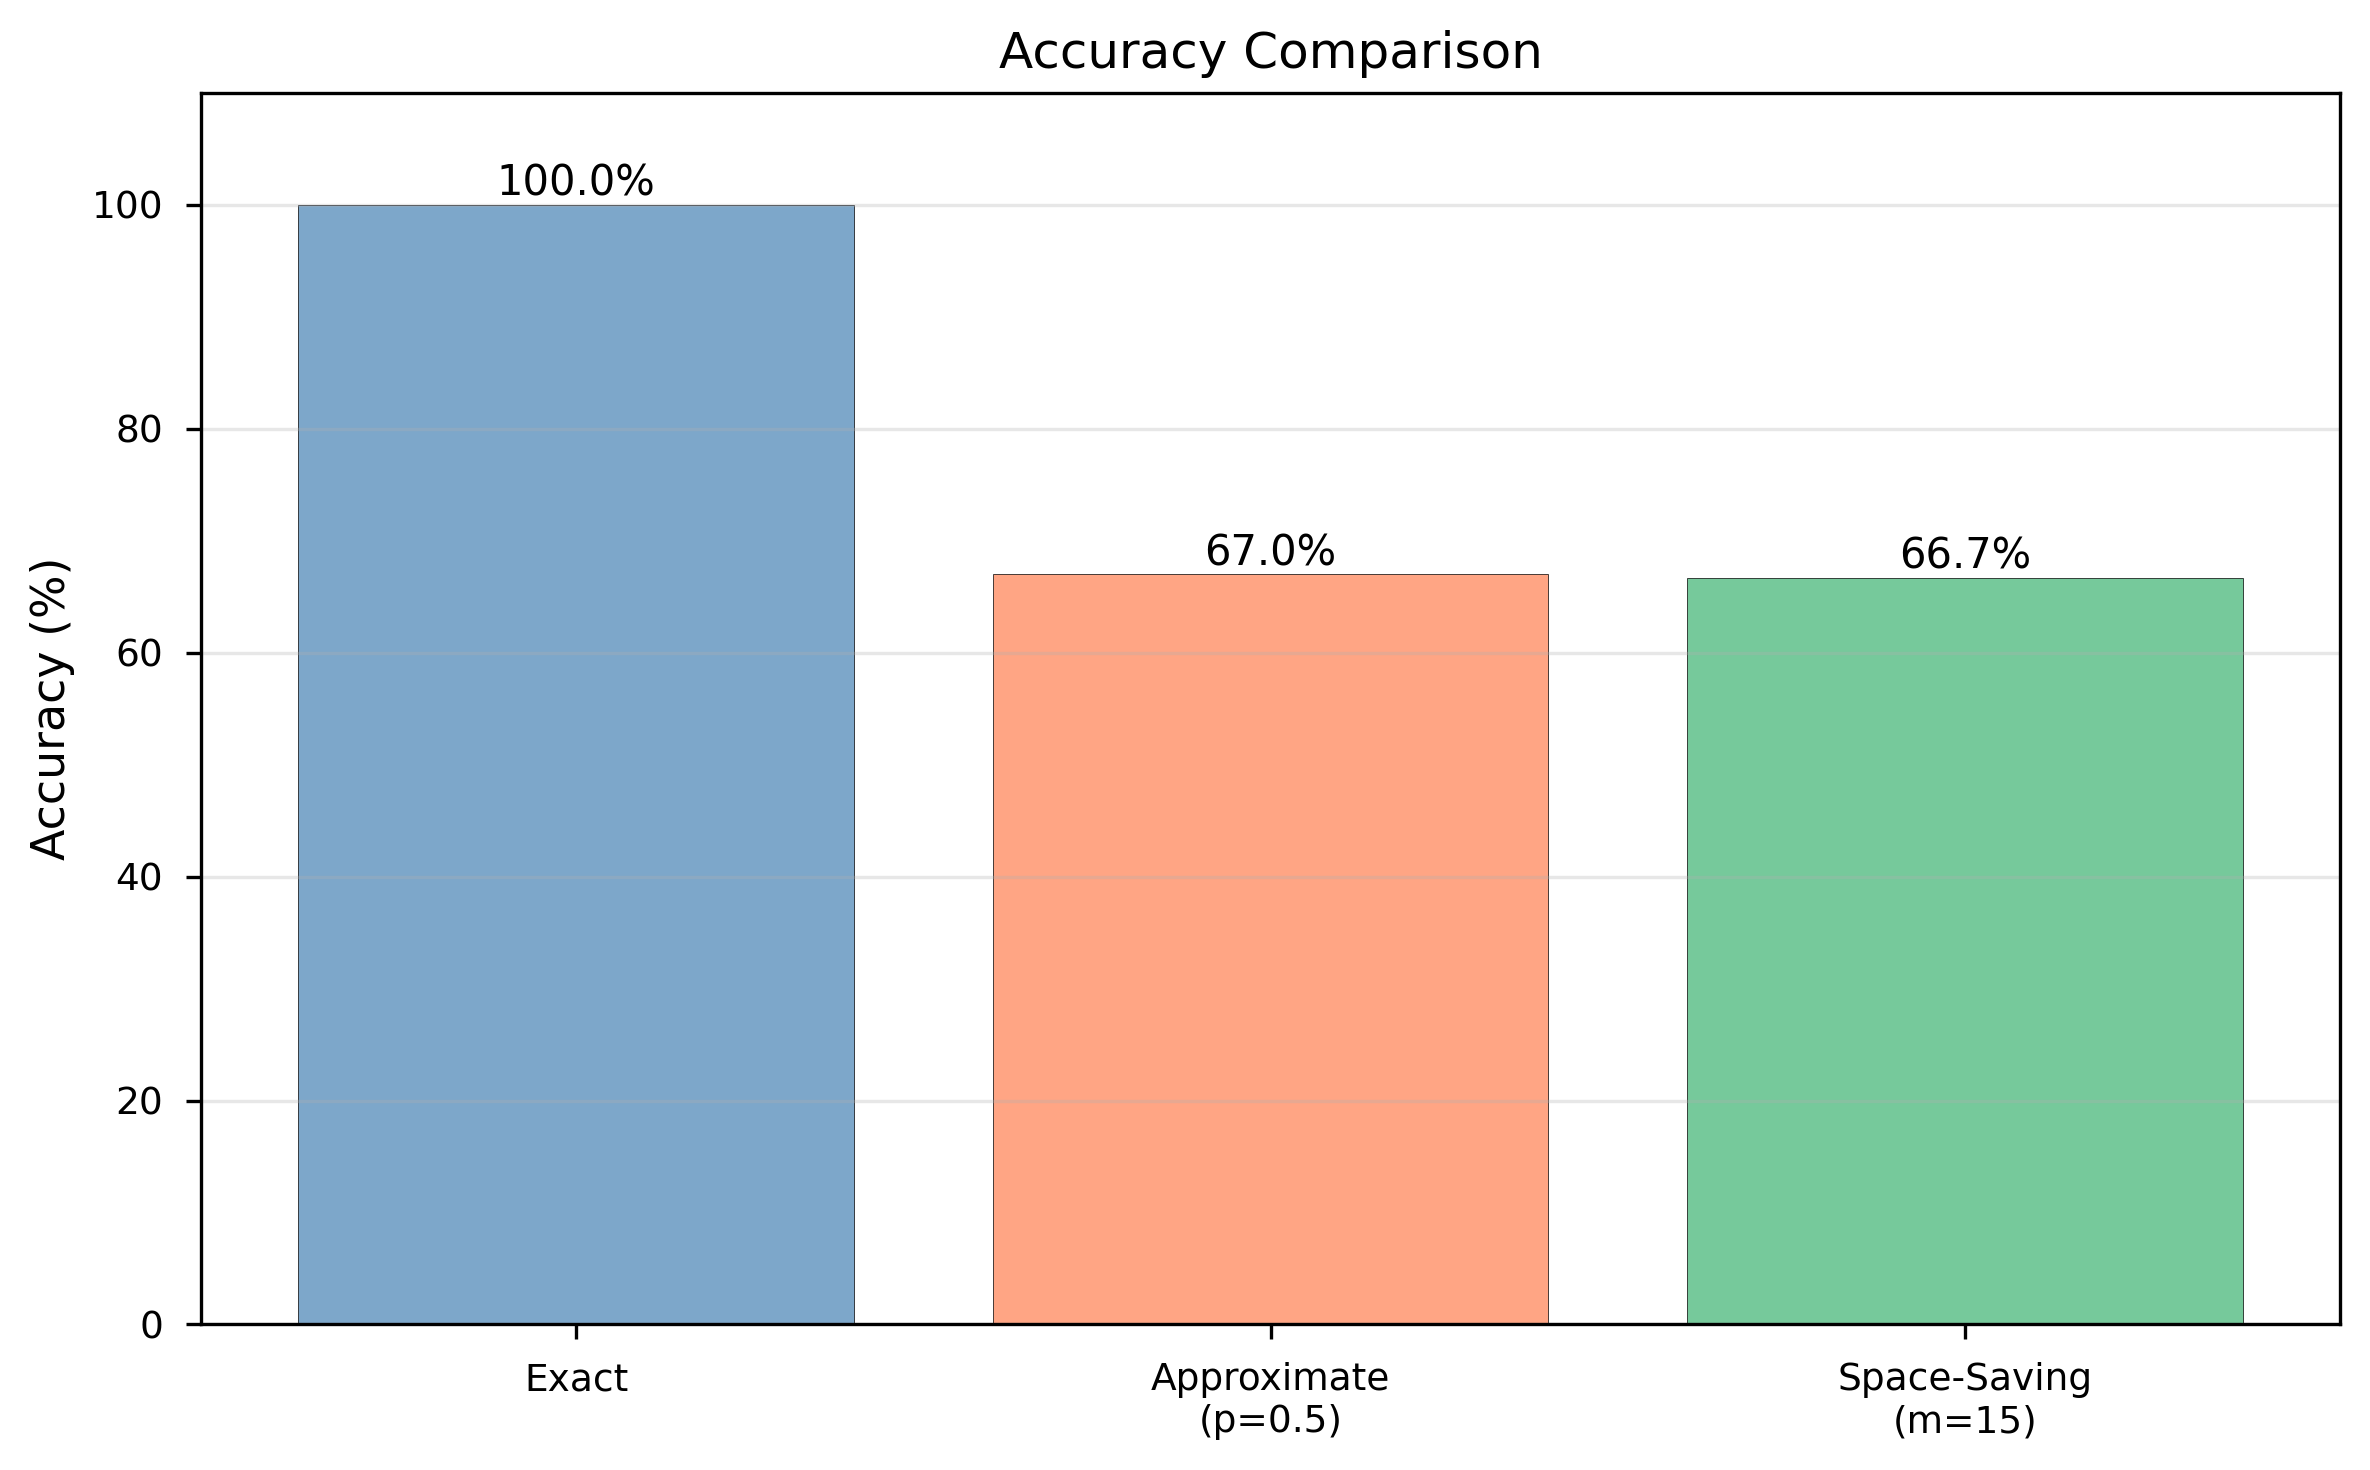

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))

methods = ['Exact', 'Approximate\n(p=0.5)', 'Space-Saving\n(m=15)']
accuracy = [100, 67, 66.7]

bars = ax.bar(methods, accuracy, edgecolor='black', 
              color=['steelblue', 'coral', 'mediumseagreen'], alpha=0.7)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy Comparison')
ax.set_ylim(0, 110)
ax.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, accuracy):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{val:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 8. Execution Time Analysis

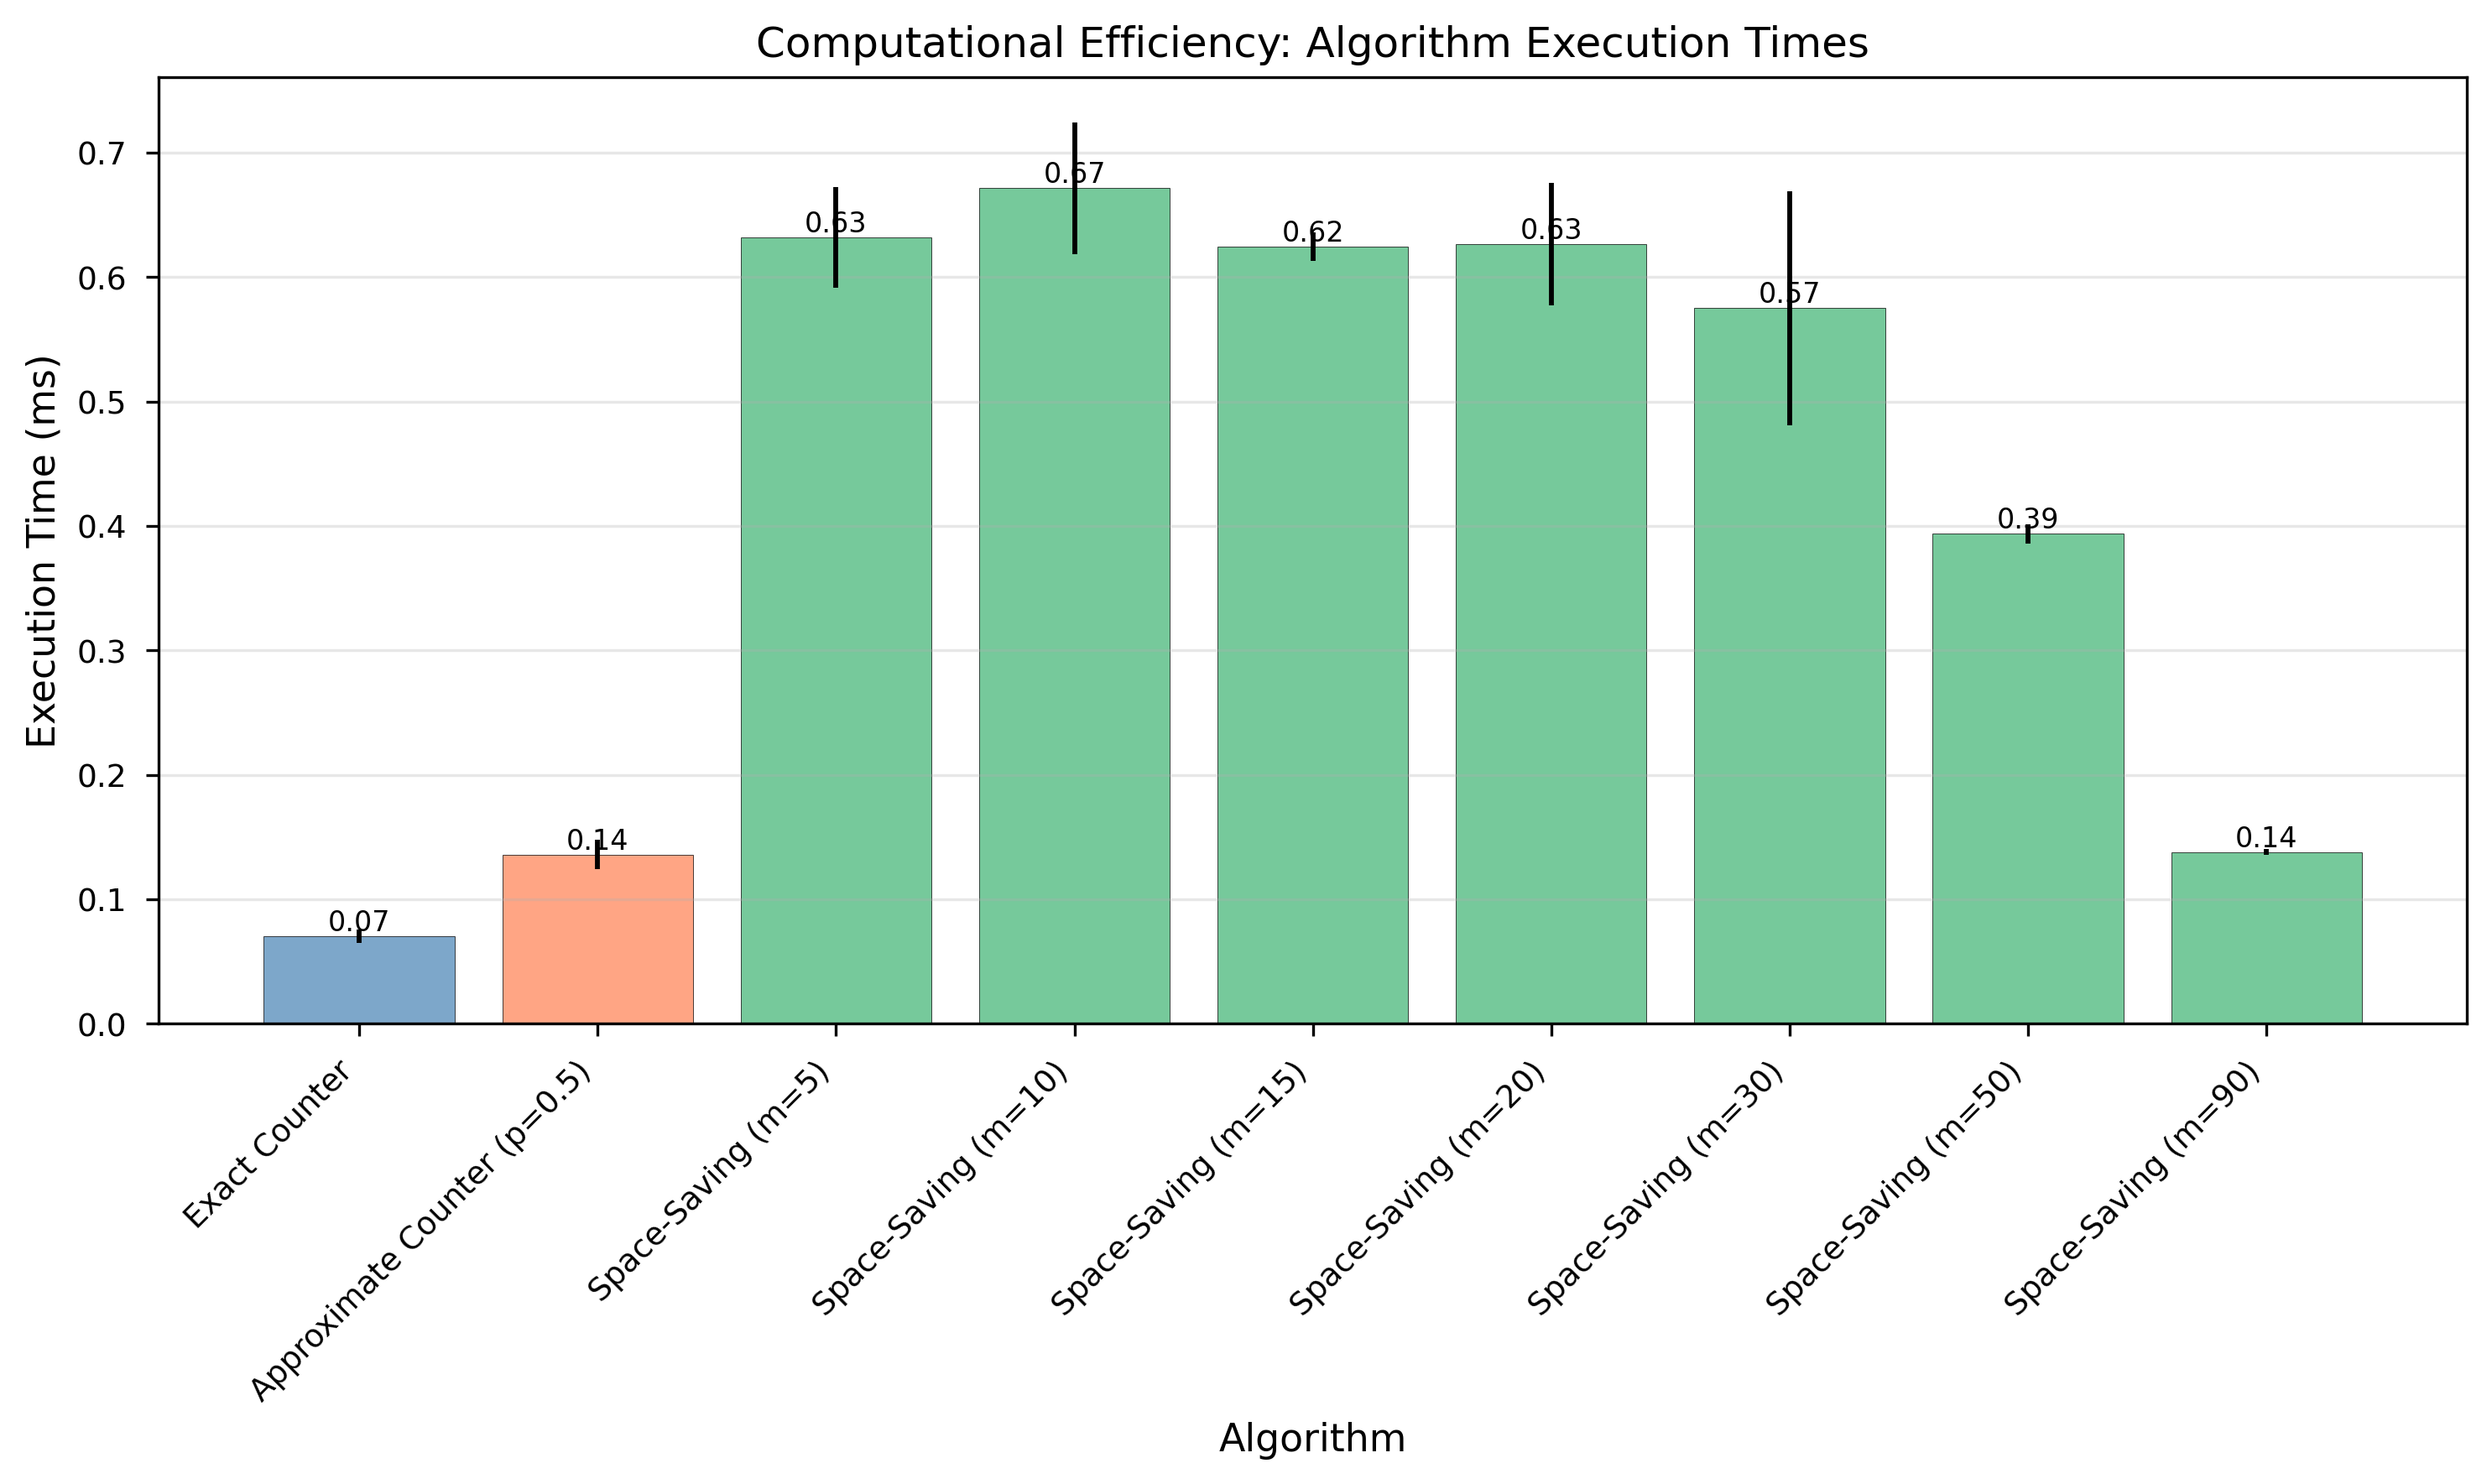

Execution Time Summary (processing 1,450 records):
Algorithm                      |  Mean (ms) |   Std (ms)
-------------------------------------------------------
Exact Counter                  |      0.070 |      0.005
Approximate Counter (p=0.5)    |      0.136 |      0.012
Space-Saving (m=5)             |      0.632 |      0.040
Space-Saving (m=10)            |      0.671 |      0.053
Space-Saving (m=15)            |      0.624 |      0.011
Space-Saving (m=20)            |      0.626 |      0.049
Space-Saving (m=30)            |      0.575 |      0.094
Space-Saving (m=50)            |      0.394 |      0.008
Space-Saving (m=90)            |      0.138 |      0.002


In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

# Separate algorithms by type
exact_data = exec_times[exec_times['algorithm'] == 'Exact Counter']
approx_data = exec_times[exec_times['algorithm'] == 'Approximate Counter (p=0.5)']
ss_data = exec_times[exec_times['algorithm'].str.contains('Space-Saving')]

# Plot bars with error bars
x_positions = np.arange(len(exec_times))
bars = ax.bar(x_positions, exec_times['mean_time_ms'], 
               yerr=exec_times['std_time_ms'],
               capsize=5, edgecolor='black', alpha=0.7,
               color=['steelblue', 'coral'] + ['mediumseagreen']*7)

ax.set_xlabel('Algorithm')
ax.set_ylabel('Execution Time (ms)')
ax.set_title('Computational Efficiency: Algorithm Execution Times')
ax.set_xticks(x_positions)
ax.set_xticklabels(exec_times['algorithm'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, mean_val) in enumerate(zip(bars, exec_times['mean_time_ms'])):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'{mean_val:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("Execution Time Summary (processing 1,450 records):")
print(f"{'Algorithm':<30} | {'Mean (ms)':>10} | {'Std (ms)':>10}")
print("-" * 55)
for _, row in exec_times.iterrows():
    print(f"{row['algorithm']:<30} | {row['mean_time_ms']:>10.3f} | {row['std_time_ms']:>10.3f}")

## 9. Space-Saving Convergence Analysis

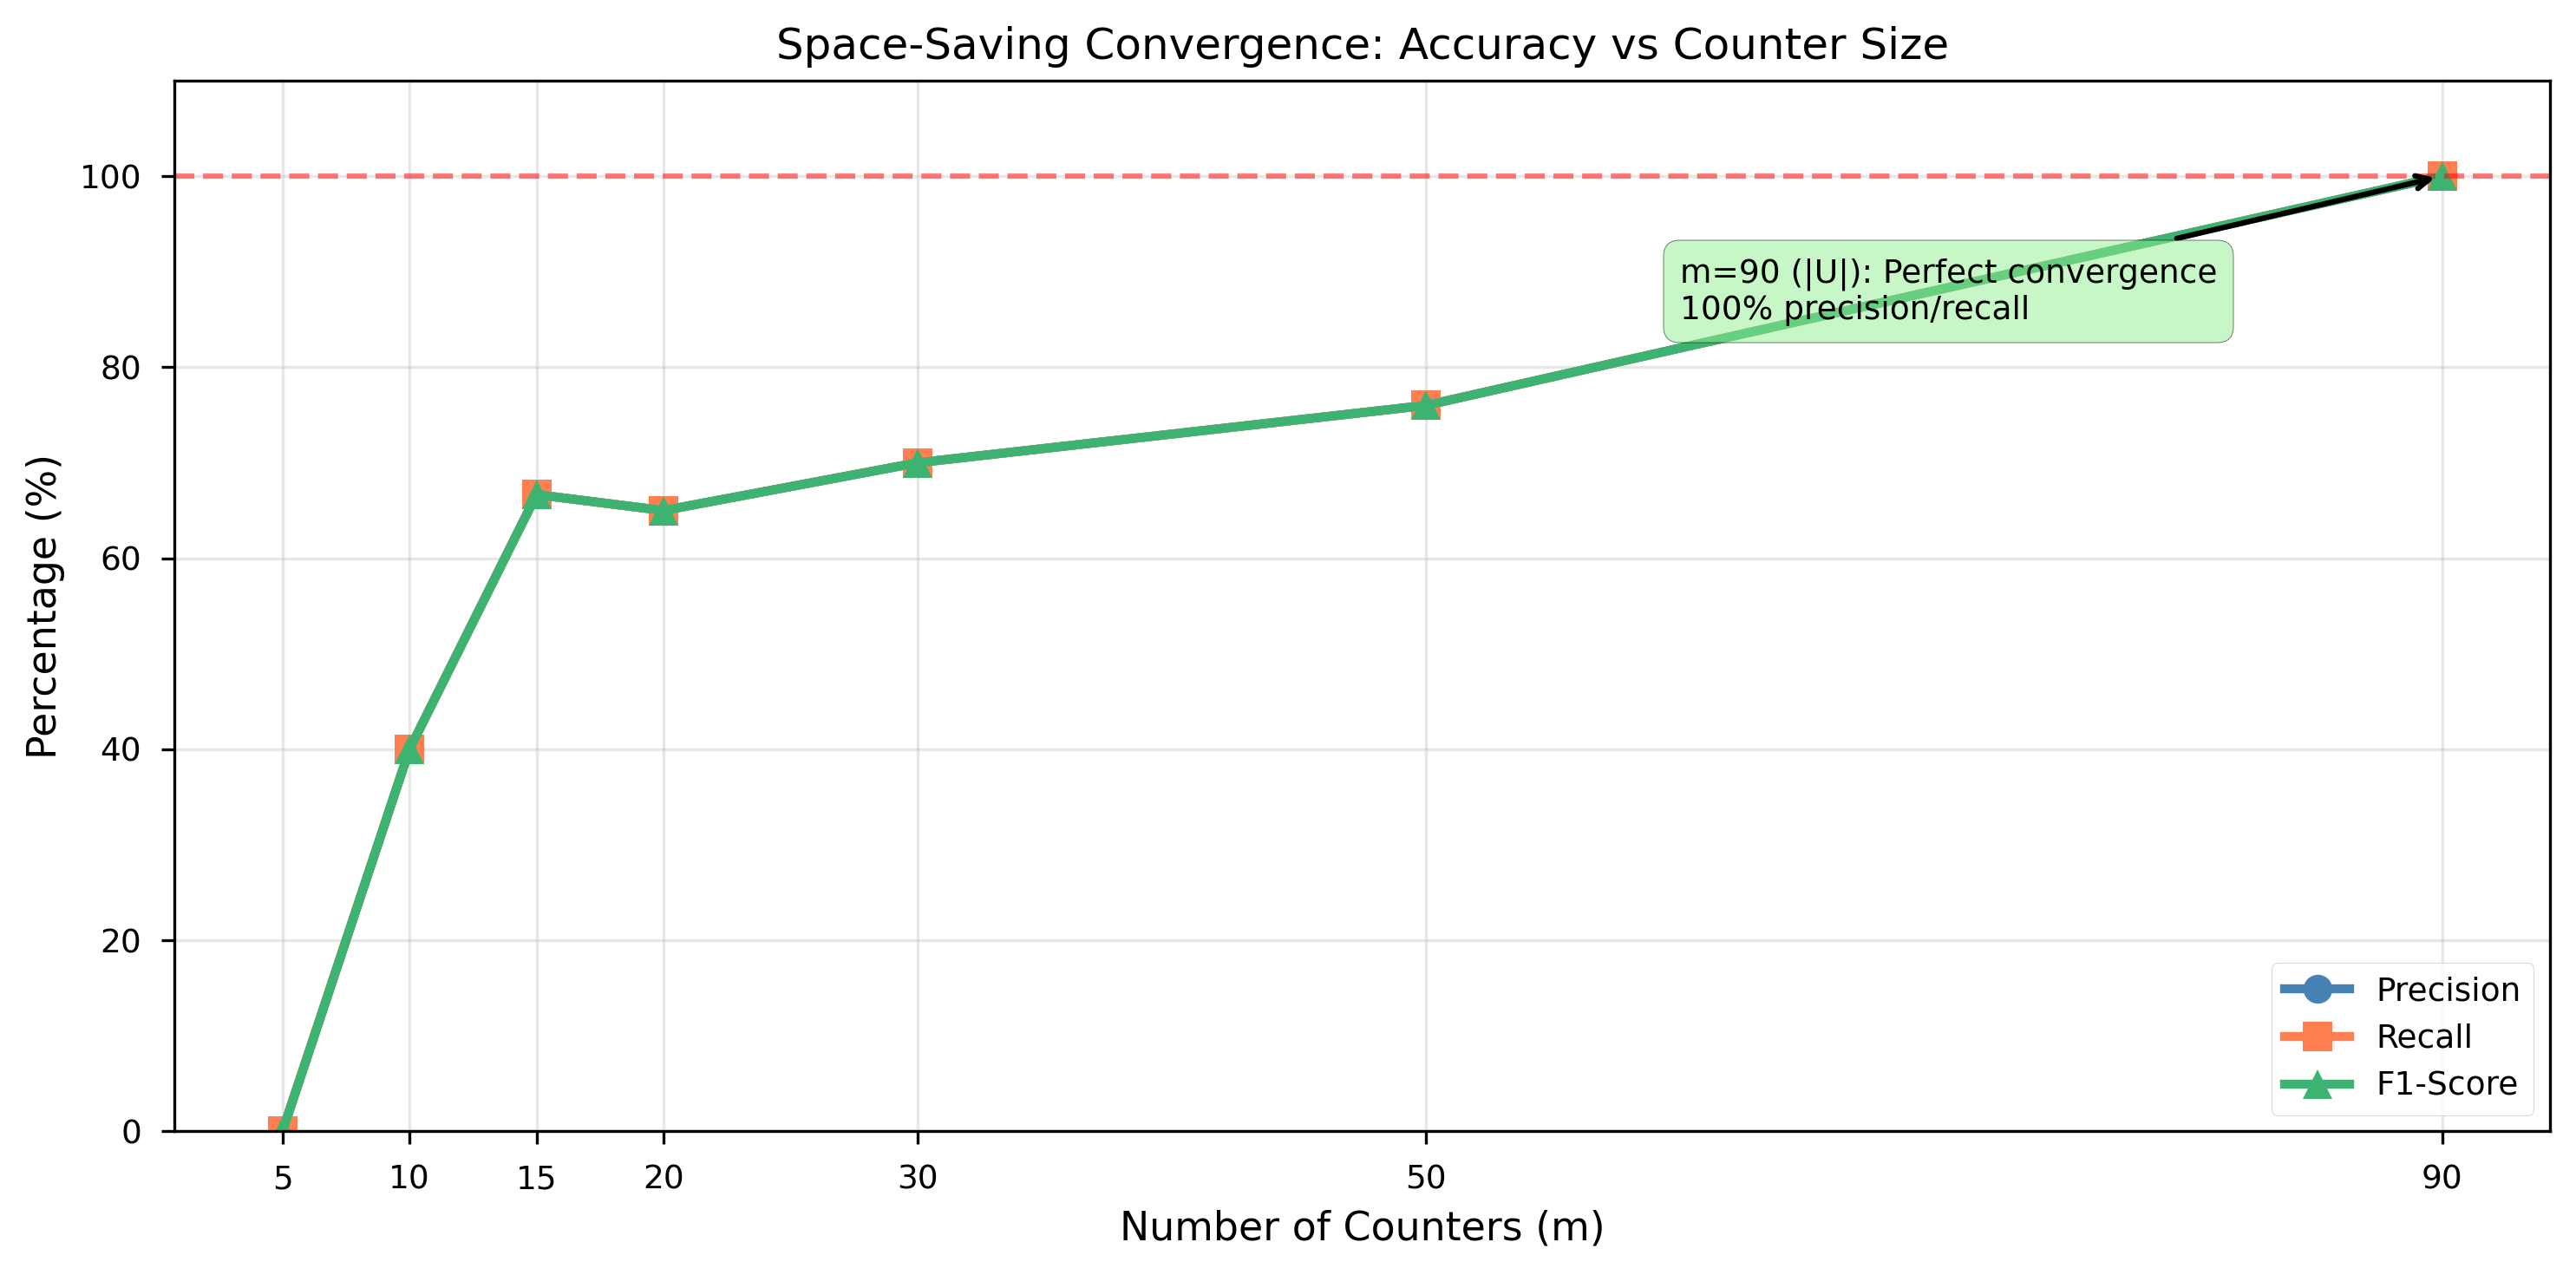

Space-Saving Convergence to Exact Counting:
m (counters) |  Precision % |   Recall % |  F1-Score %
------------------------------------------------------------
           5 |         0.0% |       0.0% |        0.0%
          10 |        40.0% |      40.0% |       40.0%
          15 |        66.7% |      66.7% |       66.7%
          20 |        65.0% |      65.0% |       65.0%
          30 |        70.0% |      70.0% |       70.0%
          50 |        76.0% |      76.0% |       76.0%
          90 |       100.0% |     100.0% |      100.0%


In [18]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot all three metrics
ax.plot(ss_performance['top_k'], ss_performance['precision_pct'], 
        marker='o', label='Precision', linewidth=2.5, markersize=8, color='steelblue')
ax.plot(ss_performance['top_k'], ss_performance['recall_pct'], 
        marker='s', label='Recall', linewidth=2.5, markersize=8, color='coral')
ax.plot(ss_performance['top_k'], ss_performance['f1_score_pct'], 
        marker='^', label='F1-Score', linewidth=2.5, markersize=8, color='mediumseagreen')

ax.set_xlabel('Number of Counters (m)')
ax.set_ylabel('Percentage (%)')
ax.set_title('Space-Saving Convergence: Accuracy vs Counter Size')
ax.set_xticks(ss_performance['top_k'])
ax.legend()
ax.grid(alpha=0.3)
ax.set_ylim(0, 110)

# Add horizontal line at 100%
ax.axhline(y=100, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='Perfect Accuracy')

# Annotate key convergence point (m=90 = |U|)
final_row = ss_performance[ss_performance['top_k'] == 90].iloc[0]
ax.annotate('m=90 (|U|): Perfect convergence\n100% precision/recall', 
            xy=(90, 100), xytext=(60, 85),
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
            fontsize=9, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

print("Space-Saving Convergence to Exact Counting:")
print(f"{'m (counters)':>12} | {'Precision %':>12} | {'Recall %':>10} | {'F1-Score %':>11}")
print("-" * 60)
for _, row in ss_performance.iterrows():
    print(f"{row['top_k']:>12.0f} | {row['precision_pct']:>11.1f}% | {row['recall_pct']:>9.1f}% | {row['f1_score_pct']:>10.1f}%")

## 10. Least Frequent Items Analysis

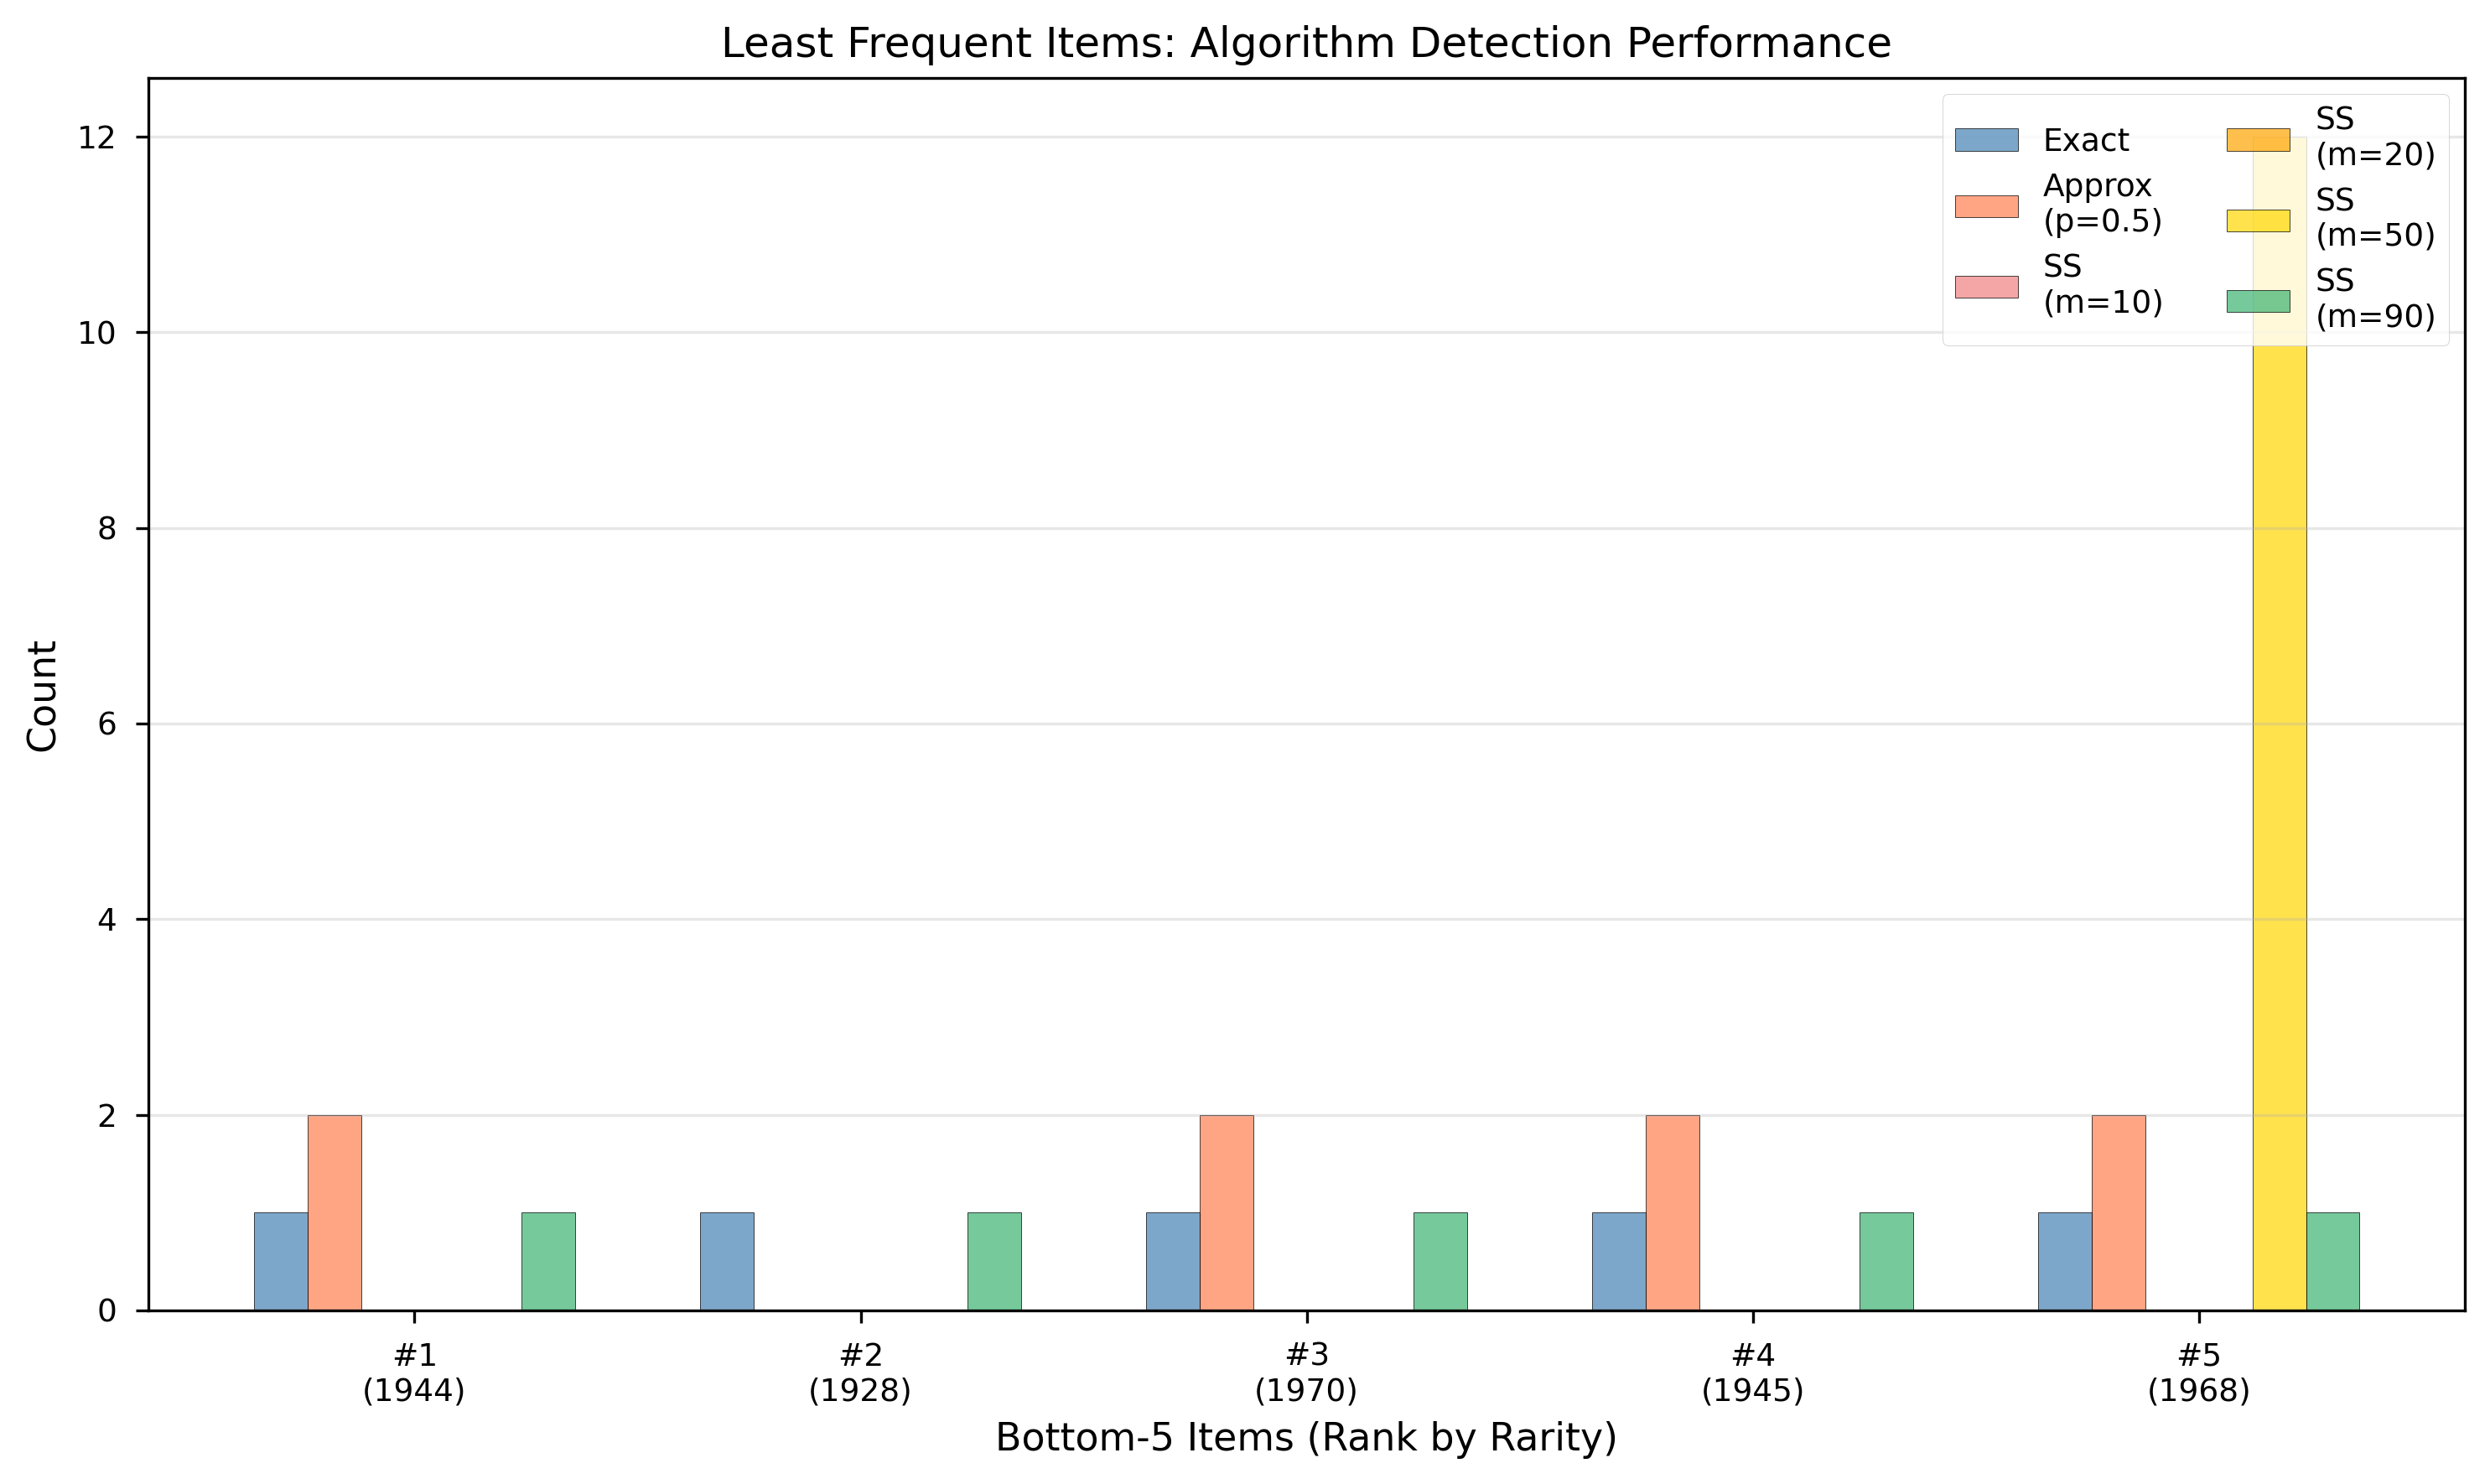

Bottom-5 Items Detection Summary:
Algorithm            |  Items Found |  Detection Rate
----------------------------------------------------
Approximate (p=0.5)  |            4/5 |             80%
SS 10                |            0/5 |              0%
SS 20                |            0/5 |              0%
SS 50                |            1/5 |             20%
SS 90                |            5/5 |            100%


In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create grouped bar chart for bottom-5 items
x = np.arange(len(least_freq))
width = 0.12

algorithms = ['exact_count', 'approx_count', 'ss_10_count', 'ss_20_count', 'ss_50_count', 'ss_90_count']
labels = ['Exact', 'Approx\n(p=0.5)', 'SS\n(m=10)', 'SS\n(m=20)', 'SS\n(m=50)', 'SS\n(m=90)']
colors = ['steelblue', 'coral', 'lightcoral', 'orange', 'gold', 'mediumseagreen']

for i, (algo, label, color) in enumerate(zip(algorithms, labels, colors)):
    offset = (i - len(algorithms)/2) * width + width/2
    ax.bar(x + offset, least_freq[algo], width, label=label, 
           edgecolor='black', color=color, alpha=0.7)

ax.set_xlabel('Bottom-5 Items (Rank by Rarity)')
ax.set_ylabel('Count')
ax.set_title('Least Frequent Items: Algorithm Detection Performance')
ax.set_xticks(x)
ax.set_xticklabels([f"#{row['rank']}\n({row['year']})" for _, row in least_freq.iterrows()])
ax.legend(loc='upper right', ncol=2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Detection summary
print("Bottom-5 Items Detection Summary:")
print(f"{'Algorithm':<20} | {'Items Found':>12} | {'Detection Rate':>15}")
print("-" * 52)
for algo in ['approx', 'ss_10', 'ss_20', 'ss_50', 'ss_90']:
    found_col = f'{algo}_found'
    num_found = least_freq[found_col].sum()
    detection_rate = num_found / len(least_freq) * 100
    algo_name = algo.replace('_', ' ').upper() if 'ss' in algo else 'Approximate (p=0.5)'
    print(f"{algo_name:<20} | {num_found:>12}/5 | {detection_rate:>14.0f}%")

## 11. Time-Space Trade-off: Space-Saving

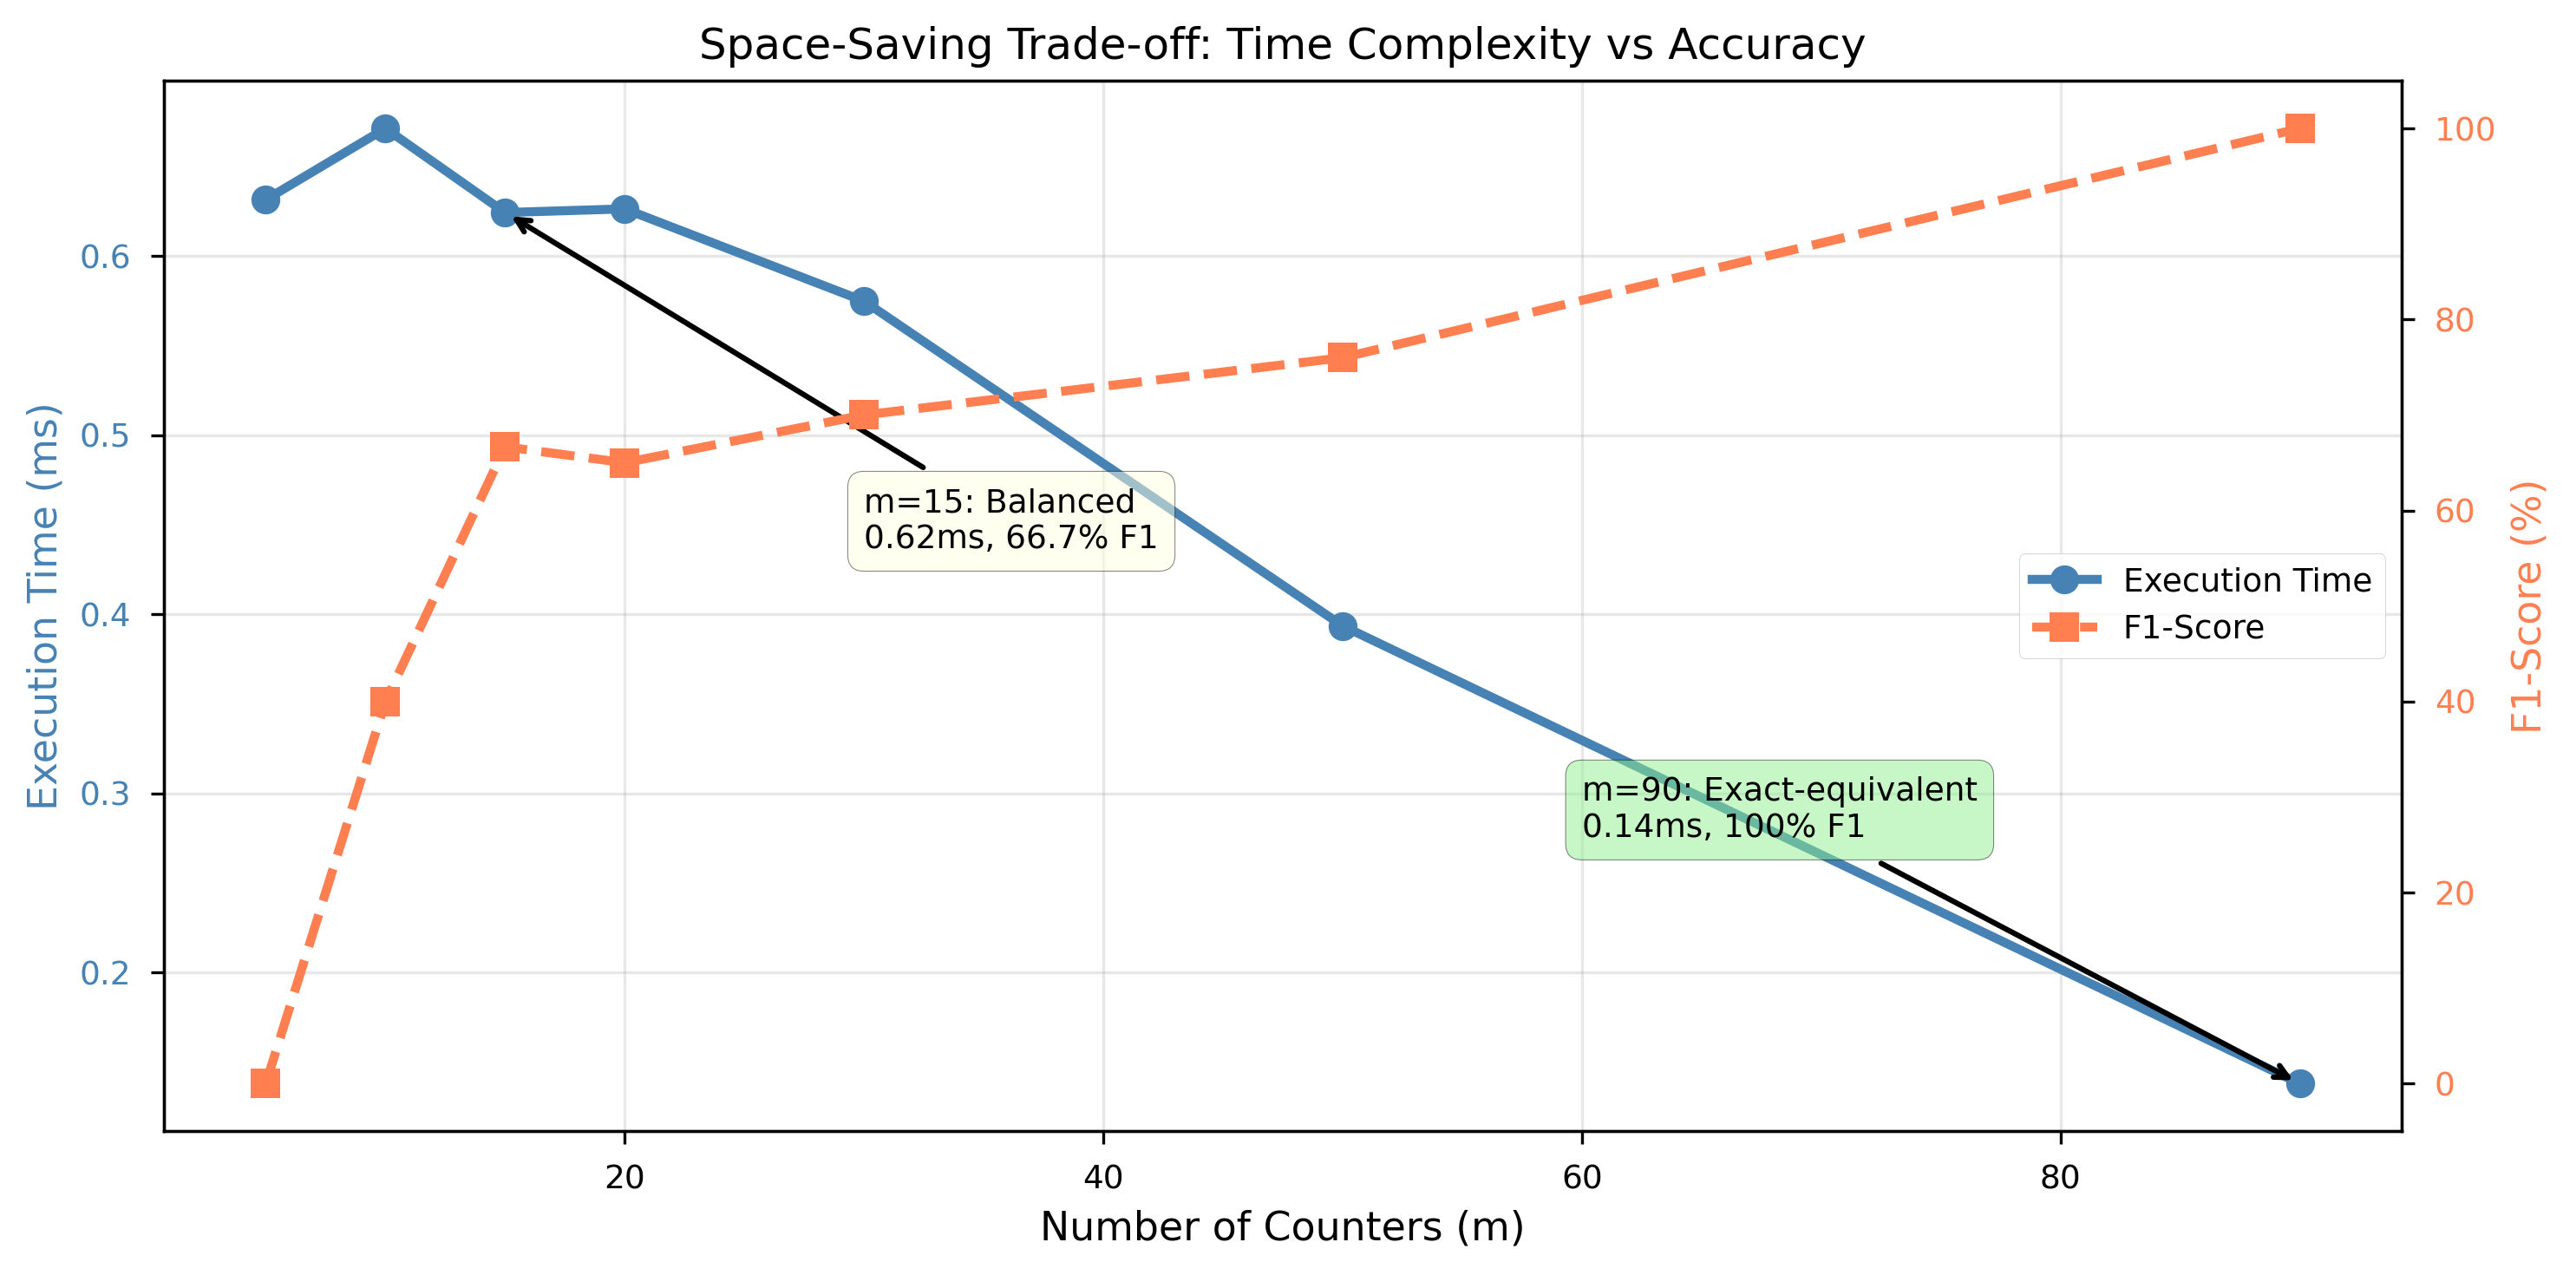

Time-Space-Accuracy Trade-off Analysis:
   m |  Time (ms) |  F1-Score % |  Memory Reduction
------------------------------------------------------------
   5 |      0.632 |        0.0% |             94.4%
  10 |      0.671 |       40.0% |             88.9%
  15 |      0.624 |       66.7% |             83.3%
  20 |      0.626 |       65.0% |             77.8%
  30 |      0.575 |       70.0% |             66.7%
  50 |      0.394 |       76.0% |             44.4%
  90 |      0.138 |      100.0% |              0.0%


In [20]:
# Extract Space-Saving data
ss_exec_data = exec_times[exec_times['algorithm'].str.contains('Space-Saving')].copy()
ss_exec_data['m_value'] = ss_exec_data['algorithm'].str.extract(r'm=(\d+)').astype(int)

# Merge with performance data
merged = pd.merge(ss_exec_data, ss_performance, left_on='m_value', right_on='top_k')

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot execution time on left axis
color_time = 'steelblue'
ax1.set_xlabel('Number of Counters (m)')
ax1.set_ylabel('Execution Time (ms)', color=color_time)
line1 = ax1.plot(merged['m_value'], merged['mean_time_ms'], 
                  linewidth=2.5, color=color_time, marker='o', markersize=8,
                  label='Execution Time')
ax1.tick_params(axis='y', labelcolor=color_time)
ax1.grid(alpha=0.3)

# Plot F1-score on right axis
ax2 = ax1.twinx()
color_accuracy = 'coral'
ax2.set_ylabel('F1-Score (%)', color=color_accuracy)
line2 = ax2.plot(merged['m_value'], merged['f1_score_pct'], 
                  linewidth=2.5, color=color_accuracy, marker='s', markersize=8,
                  linestyle='--', label='F1-Score')
ax2.tick_params(axis='y', labelcolor=color_accuracy)

ax1.set_title('Space-Saving Trade-off: Time Complexity vs Accuracy')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')

# Annotate sweet spot (m=15)
sweet_spot = merged[merged['m_value'] == 15].iloc[0]
ax1.annotate(f"m=15: Balanced\n{sweet_spot['mean_time_ms']:.2f}ms, {sweet_spot['f1_score_pct']:.1f}% F1", 
             xy=(15, sweet_spot['mean_time_ms']), xytext=(30, sweet_spot['mean_time_ms']*0.7),
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
             fontsize=9, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.5))

# Annotate convergence (m=90)
convergence = merged[merged['m_value'] == 90].iloc[0]
ax1.annotate(f"m=90: Exact-equivalent\n{convergence['mean_time_ms']:.2f}ms, 100% F1", 
             xy=(90, convergence['mean_time_ms']), xytext=(60, convergence['mean_time_ms']*2),
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
             fontsize=9, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

print("Time-Space-Accuracy Trade-off Analysis:")
print(f"{'m':>4} | {'Time (ms)':>10} | {'F1-Score %':>11} | {'Memory Reduction':>17}")
print("-" * 60)
for _, row in merged.iterrows():
    memory_reduction = (1 - row['m_value']/90) * 100
    print(f"{row['m_value']:>4.0f} | {row['mean_time_ms']:>10.3f} | {row['f1_score_pct']:>10.1f}% | {memory_reduction:>16.1f}%")

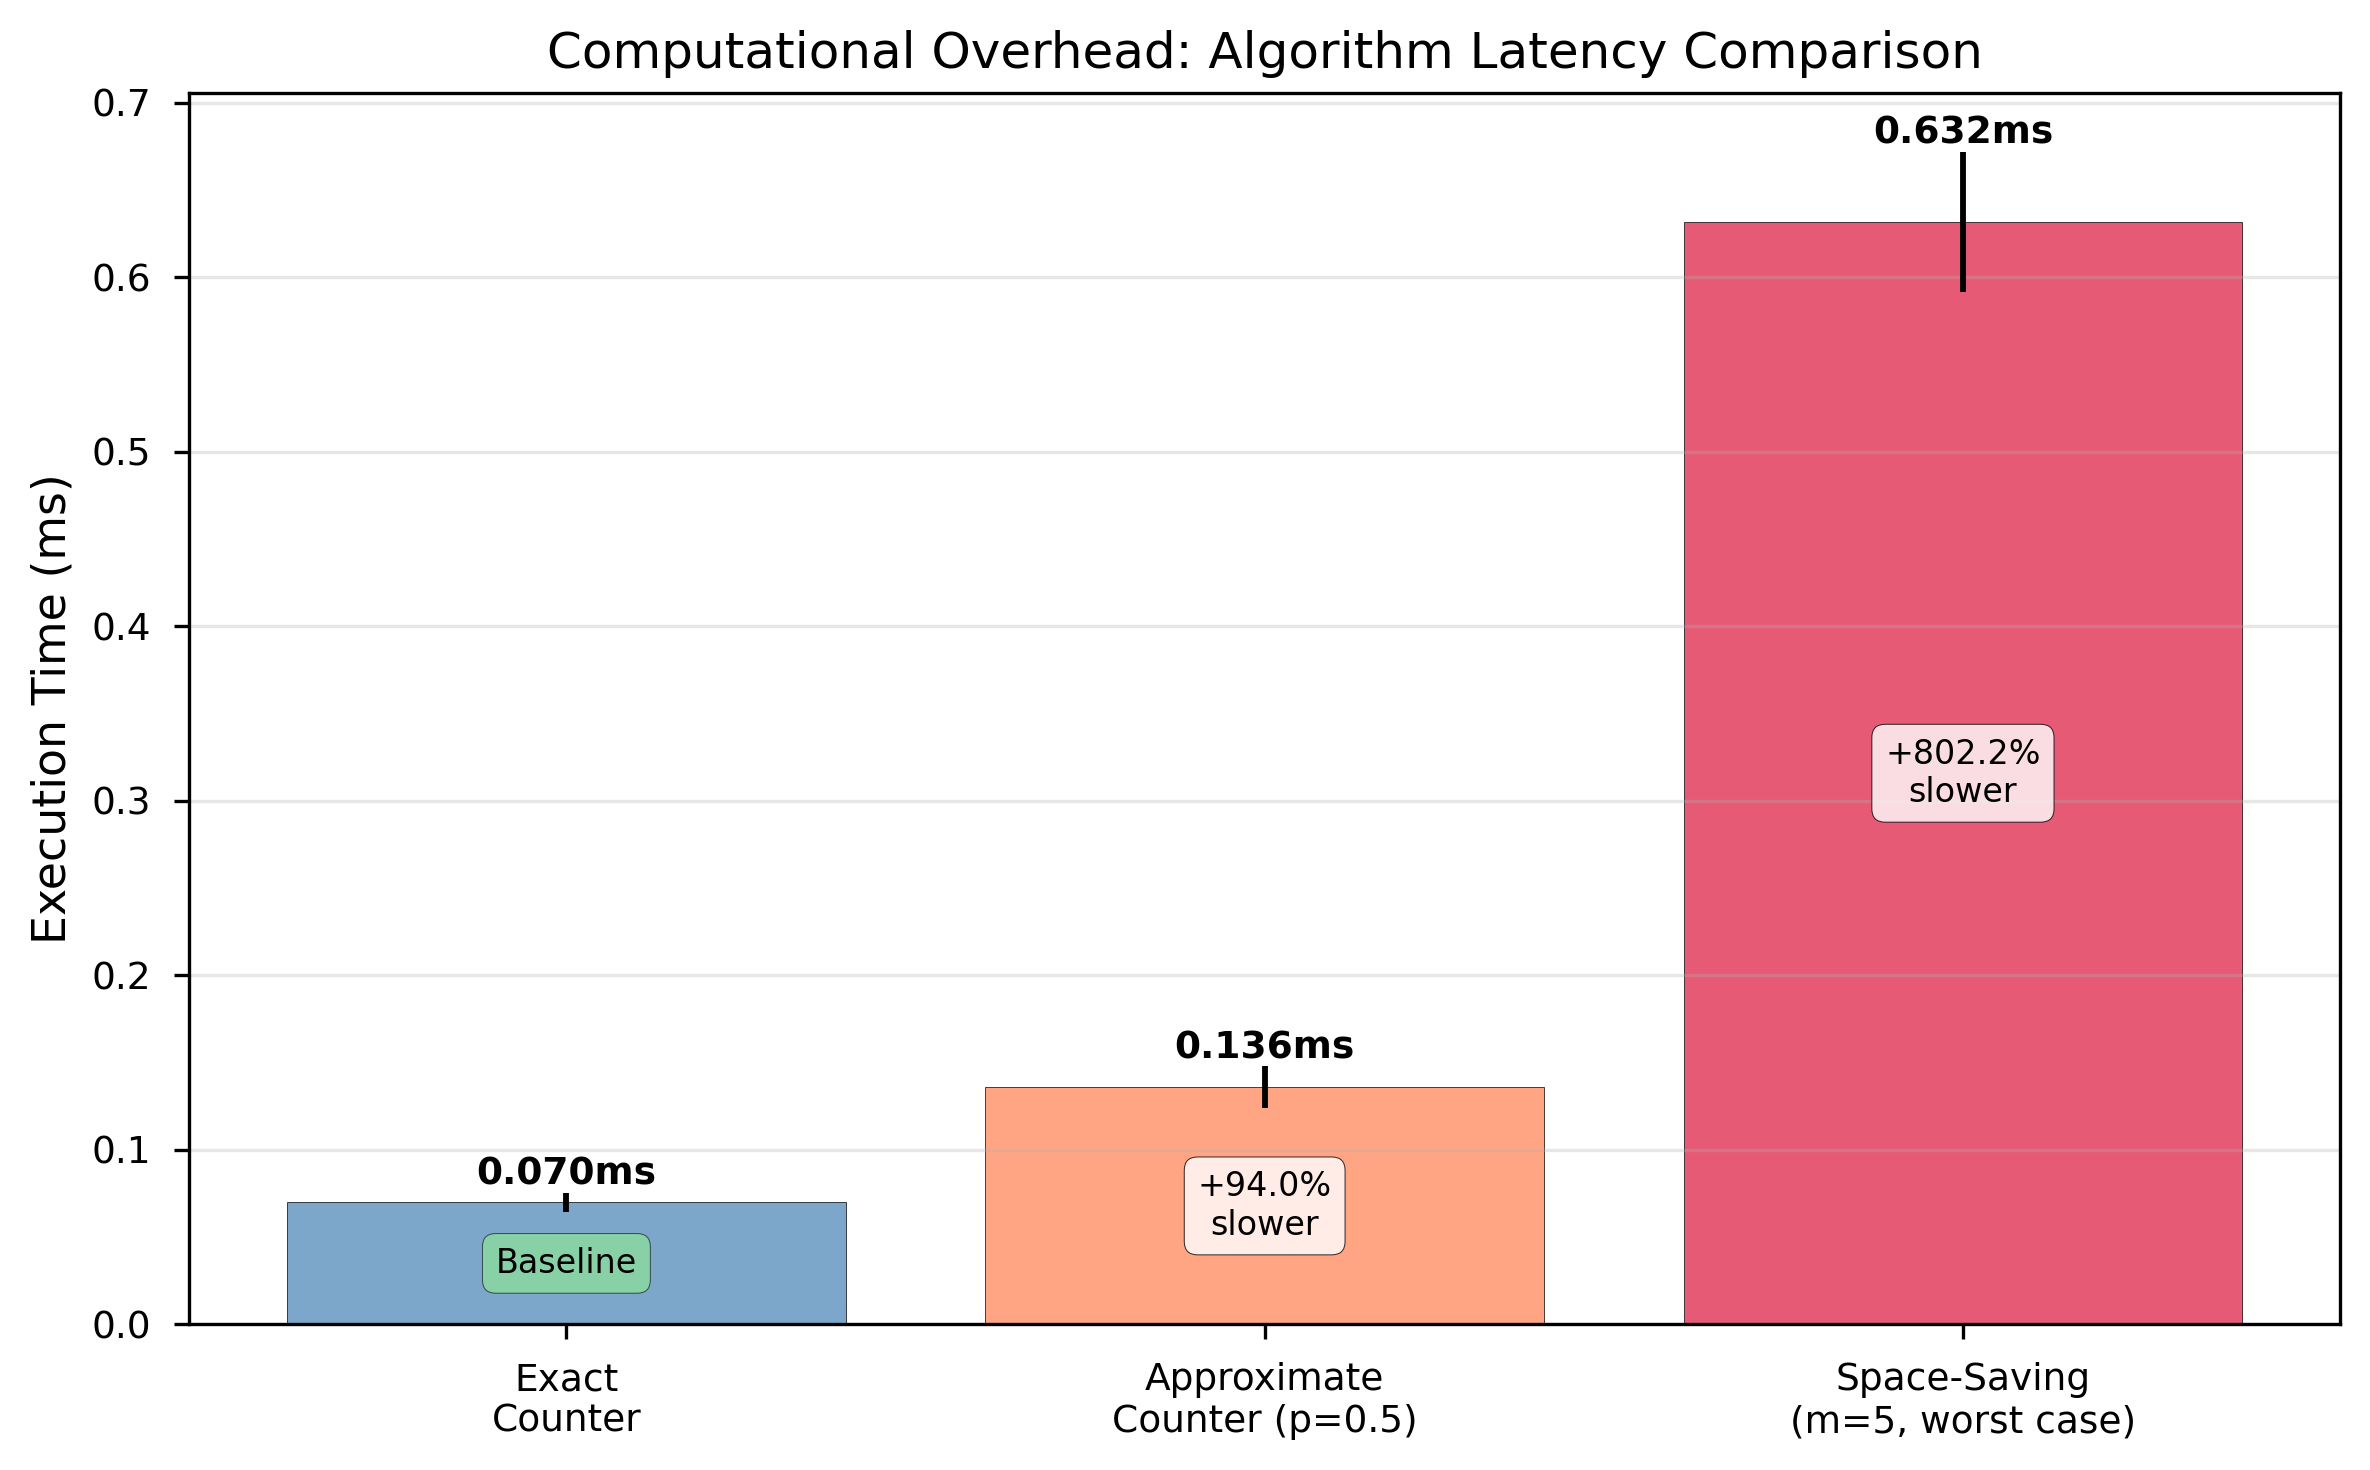

Algorithm Latency Comparison (processing 1,450 records):
Algorithm                      |  Mean (ms) |   vs Exact
-------------------------------------------------------
Exact Counter                  |      0.070 |   baseline
Approximate Counter (p=0.5)    |      0.136 |      94.0%
Space-Saving (m=5, worst case) |      0.632 |     802.2%


In [23]:
# Extract specific algorithms for comparison
exact_row = exec_times[exec_times['algorithm'] == 'Exact Counter'].iloc[0]
approx_row = exec_times[exec_times['algorithm'] == 'Approximate Counter (p=0.5)'].iloc[0]
ss_slowest_row = exec_times[exec_times['algorithm'] == 'Space-Saving (m=5)'].iloc[0]

fig, ax = plt.subplots(figsize=(8, 5))

algorithms = ['Exact\nCounter', 'Approximate\nCounter (p=0.5)', 'Space-Saving\n(m=5, worst case)']
mean_times = [exact_row['mean_time_ms'], approx_row['mean_time_ms'], ss_slowest_row['mean_time_ms']]
std_times = [exact_row['std_time_ms'], approx_row['std_time_ms'], ss_slowest_row['std_time_ms']]
colors = ['steelblue', 'coral', 'crimson']

bars = ax.bar(algorithms, mean_times, yerr=std_times, capsize=8,
               edgecolor='black', color=colors, alpha=0.7)

ax.set_ylabel('Execution Time (ms)')
ax.set_title('Computational Overhead: Algorithm Latency Comparison')
ax.grid(axis='y', alpha=0.3)

# Add value labels and speedup/slowdown annotations
for i, (bar, mean_val, std_val) in enumerate(zip(bars, mean_times, std_times)):
    # Value label
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + std_val,
            f'{mean_val:.3f}ms', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Relative performance vs Exact
    if i > 0:
        slowdown = ((mean_val - mean_times[0]) / mean_times[0]) * 100
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() * 0.5,
                f'+{slowdown:.1f}%\nslower', ha='center', va='center', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))

# Add baseline annotation
ax.text(bars[0].get_x() + bars[0].get_width()/2., bars[0].get_height() * 0.5,
        'Baseline', ha='center', va='center', fontsize=8,
        bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgreen', alpha=0.6))

plt.tight_layout()
plt.show()

print("Algorithm Latency Comparison (processing 1,450 records):")
print(f"{'Algorithm':<30} | {'Mean (ms)':>10} | {'vs Exact':>10}")
print("-" * 55)
print(f"{'Exact Counter':<30} | {exact_row['mean_time_ms']:>10.3f} | {'baseline':>10}")
approx_overhead = ((approx_row['mean_time_ms'] - exact_row['mean_time_ms']) / exact_row['mean_time_ms']) * 100
print(f"{'Approximate Counter (p=0.5)':<30} | {approx_row['mean_time_ms']:>10.3f} | {approx_overhead:>9.1f}%")
ss_overhead = ((ss_slowest_row['mean_time_ms'] - exact_row['mean_time_ms']) / exact_row['mean_time_ms']) * 100
print(f"{'Space-Saving (m=5, worst case)':<30} | {ss_slowest_row['mean_time_ms']:>10.3f} | {ss_overhead:>9.1f}%")

## 13. Algorithm Latency Comparison

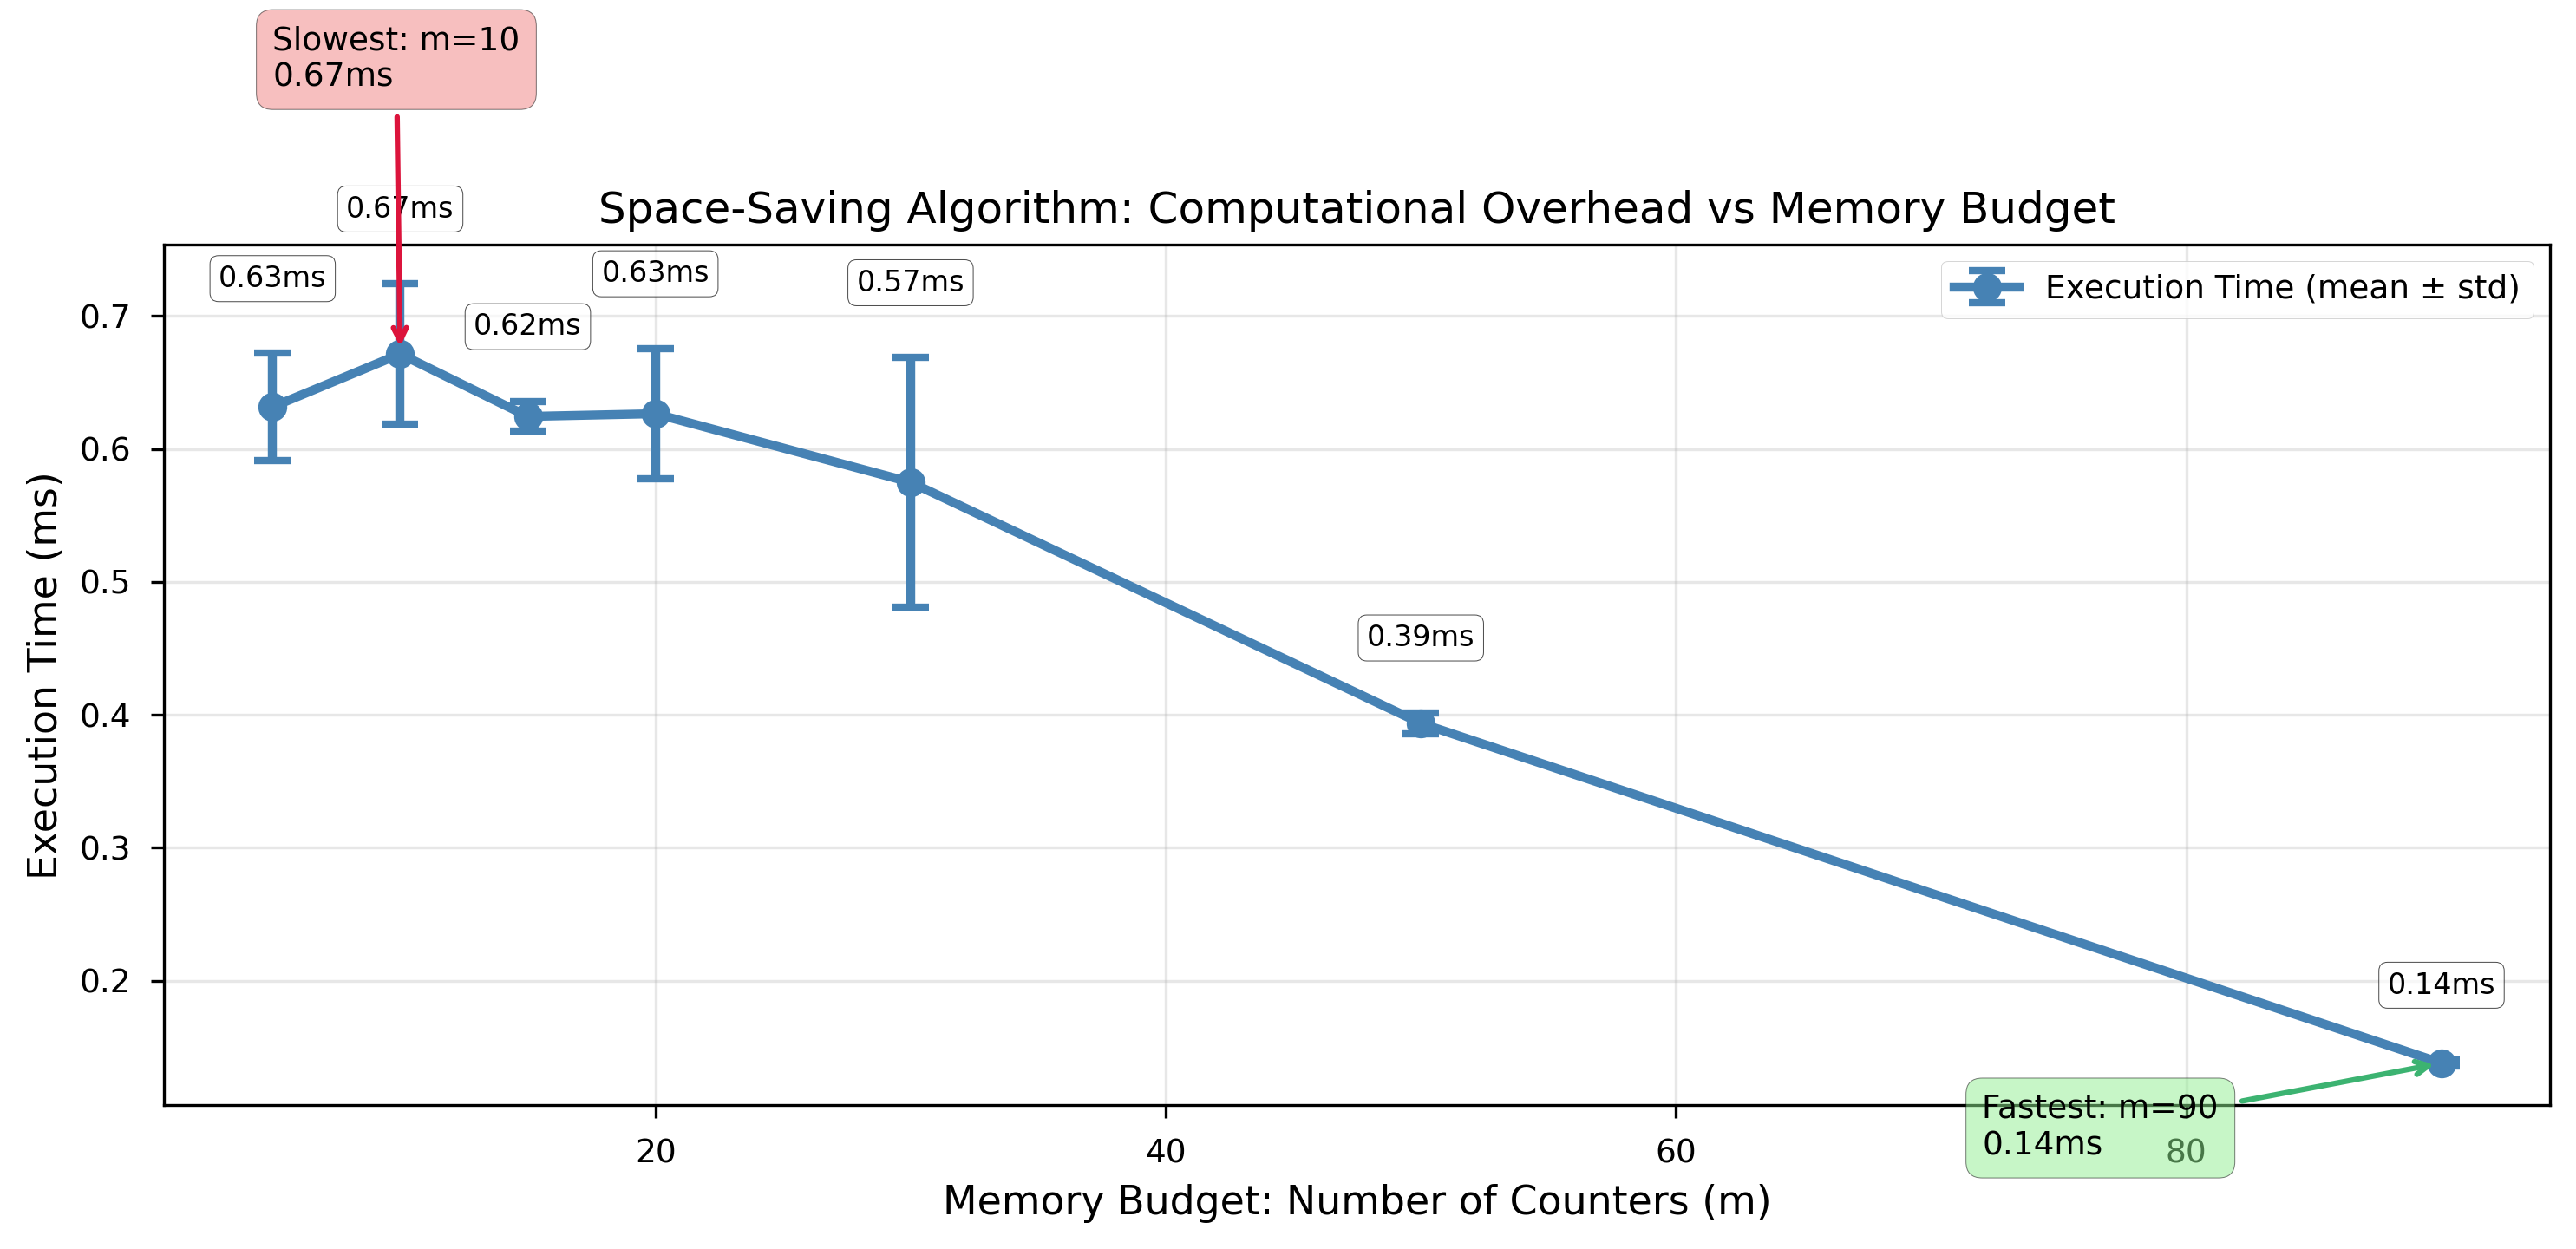

Space-Saving Execution Time vs Memory Budget:
m (counters) |  Mean (ms) |   Std (ms) | Overhead vs Exact
------------------------------------------------------------
           5 |      0.632 |      0.040 |            802.2%
          10 |      0.671 |      0.053 |            859.0%
          15 |      0.624 |      0.011 |            791.9%
          20 |      0.626 |      0.049 |            794.8%
          30 |      0.575 |      0.094 |            721.2%
          50 |      0.394 |      0.008 |            462.2%
          90 |      0.138 |      0.002 |             97.0%


In [24]:
# Extract Space-Saving execution times
ss_exec_data = exec_times[exec_times['algorithm'].str.contains('Space-Saving')].copy()
ss_exec_data['m_value'] = ss_exec_data['algorithm'].str.extract(r'm=(\d+)').astype(int)
ss_exec_data = ss_exec_data.sort_values('m_value')

fig, ax = plt.subplots(figsize=(10, 5))

# Plot execution time with error bars
ax.errorbar(ss_exec_data['m_value'], ss_exec_data['mean_time_ms'], 
            yerr=ss_exec_data['std_time_ms'],
            linewidth=2.5, color='steelblue', marker='o', markersize=8,
            capsize=5, capthick=2, label='Execution Time (mean ± std)')

ax.set_xlabel('Memory Budget: Number of Counters (m)')
ax.set_ylabel('Execution Time (ms)')
ax.set_title('Space-Saving Algorithm: Computational Overhead vs Memory Budget')
ax.grid(alpha=0.3)
ax.legend()

# Add value labels at each point
for _, row in ss_exec_data.iterrows():
    ax.text(row['m_value'], row['mean_time_ms'] + row['std_time_ms'] + 0.05, 
            f"{row['mean_time_ms']:.2f}ms", 
            ha='center', fontsize=8, 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

# Annotate counter-intuitive finding
max_time_row = ss_exec_data.loc[ss_exec_data['mean_time_ms'].idxmax()]
min_time_row = ss_exec_data.loc[ss_exec_data['mean_time_ms'].idxmin()]

ax.annotate(f"Slowest: m={int(max_time_row['m_value'])}\n{max_time_row['mean_time_ms']:.2f}ms", 
            xy=(max_time_row['m_value'], max_time_row['mean_time_ms']), 
            xytext=(max_time_row['m_value']*0.5, max_time_row['mean_time_ms']*1.3),
            arrowprops=dict(arrowstyle='->', color='crimson', lw=1.5),
            fontsize=9, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.5))

ax.annotate(f"Fastest: m={int(min_time_row['m_value'])}\n{min_time_row['mean_time_ms']:.2f}ms", 
            xy=(min_time_row['m_value'], min_time_row['mean_time_ms']), 
            xytext=(min_time_row['m_value']*0.8, min_time_row['mean_time_ms']*0.5),
            arrowprops=dict(arrowstyle='->', color='mediumseagreen', lw=1.5),
            fontsize=9, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

print("Space-Saving Execution Time vs Memory Budget:")
print(f"{'m (counters)':>12} | {'Mean (ms)':>10} | {'Std (ms)':>10} | {'Overhead vs Exact':>17}")
print("-" * 60)
exact_time = exec_times[exec_times['algorithm'] == 'Exact Counter']['mean_time_ms'].values[0]
for _, row in ss_exec_data.iterrows():
    overhead = ((row['mean_time_ms'] - exact_time) / exact_time) * 100
    print(f"{row['m_value']:>12.0f} | {row['mean_time_ms']:>10.3f} | {row['std_time_ms']:>10.3f} | {overhead:>16.1f}%")

## 12. Space-Saving: Execution Time vs Memory Budget